# <u>0) Ensemble des variables à modifier en début d'exécution du Notebook, selon l'exploitation qu'on veut en faire.</u>

In [ ]:
# Booléen d'activation (ou non) de l'installation des modules/librairies nécessaires au bon fonctionnement de ce Notebook (cf partie 1.1) du Notebook).
Installation = False
# Chemin de données (local) vers me répertoire de rangement de la base de donnée initiale, telle que disponible en ligne (cf partie 2) du Notebook).
abs_path_b2d = 'C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P3/Base2donees/'
# Nom du fichier dans lequel est enregistré de la base de donnée initiale
title_b2d_2015 = '2015-building-energy-benchmarking.csv'
title_b2d_2016 = '2016-building-energy-benchmarking.csv'
# Chemin de données (local) vers le repertoire de rangement de la base de donnée finale, après réduction et nettoyage.
# Factuellement, on a choisit de la ranger dans le même répertoire que la base de donnée initiale.
abs_path_b2d_rednet = abs_path_b2d
# Nom du fichier dans lequel on veut enregistrer la base de donnée finale.
title_b2d_rednet = 'b2d_15et16_rednet.csv'
# Sauvegarde des figures et chemin de données vers répertoire de stockage
Sauvegarde_figure, abs_path_fig = True, 'C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P3/Figures/Analyse/'

# 
# <u>1) Installations et importations des libriaries/modules python utiles pour ce Notebbok.</u>
 
## <u>1.1) Installation (sautez cette étape si vous les avez déjà sur votre ordinateur).</u>
### !!! LA LIBRAIRIE MISSINGNO EST DONN2E EN RESSOURCE DE CE PROJET? IL FAUDRA PEUT ËTRE LA METTRE DANS LE MEME REPERTOIRE DE RANGEMENT QUE CE NOTEBOOK !!!
### https://github.com/ResidentMario/missingno

In [ ]:
# Installation conditionnée au booléen précédent
if Installation :
    ! pip install pandas
    ! pip install numpy
    ! pip install missingno


## <u>1.2) Importations.</u>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib as plb
from missingno.missingno import bar, heatmap, matrix
import re
from sklearn.preprocessing import StandardScaler

## <u>1.3) Définitions de fonctions personnelles.</u>

In [4]:
def decrire(liste_annee=[], liste_df=[], liste_param=[], liste_categ=[]):
    #param = liste_param#['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'SiteEnergyUse(kBtu)']
    #categ = liste_categ#['BuildingType', 'CouncilDistrictCode', '']
    for annee, df in zip(liste_annee, liste_df):
        print(f'{annee} :')
        for cat in liste_categ :
            for par in liste_param :
                print(f'{par : <s} :')
                description = df[[par, cat]].groupby(cat).describe()
                clefs, categories = description.keys(), np.sort(df[cat].value_counts().keys())
                texte_1 = f'{cat : >20s}'
                for clef in clefs:
                    texte_1  += f'{clef[1] : >12s}'
                print(texte_1)
                for indx, categorie in zip(range(len(categories)), categories):
                    texte_2, valeurs = f'{categorie[:20] : >20}', description.values[indx]
                    for jndx, valeur in zip(range(len(valeurs)), valeurs):
                        #texte_2 += f'{valeur : >15.0f}' if 'count' in clefs[jndx][1] else f'{valeur : > 15.2f}' if np.logical_or('mean' in clefs[jndx][1], 'std' in clefs[jndx][1]) else f'{valeur : >-15}'
                        texte_2 += f'{valeur : >12.0f}' if 'count' in clefs[jndx][1] else f'{valeur : >-12.0f}' if valeur==0 else f'{valeur : >-12.2f}' if np.logical_and(abs(valeur)<1000, abs(valeur)>=0.1) else f'{valeur : >-12.2e}'
                    print(texte_2)
                print('')


# 
# <u>2) Chargement de la base de données complète.</u>
## La base de données a été téléchargée manuellement sur <i>insérer lien</i>. Elle a ensuite été répertoriée en local, mais pas dans le même répertoire que ce notebook.
## !!! Part la suite, on y fera référence sous l'abréviation 'b2d' !!!

In [5]:
# Chargement à proprement parler, sous forme d'un pandas.Dataframe.
df_2015, df_2016 = pd.read_csv(abs_path_b2d + title_b2d_2015), pd.read_csv(abs_path_b2d + title_b2d_2016)

## Affichage de quelques lignes de chacune des deux b2d.

In [6]:
df_2015.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2015  NonResidential               Hotel   
1              2      2015  NonResidential               Hotel   
2              3      2015  NonResidential               Hotel   
3              5      2015  NonResidential               Hotel   
4              8      2015  NonResidential               Hotel   

            PropertyName TaxParcelIdentificationNumber  \
0   MAYFLOWER PARK HOTEL                     659000030   
1        PARAMOUNT HOTEL                     659000220   
2           WESTIN HOTEL                     659000475   
3              HOTEL MAX                     659000640   
4  WARWICK SEATTLE HOTEL                     659000970   

                                            Location  CouncilDistrictCode  \
0  {'latitude': '47.61219025', 'longitude': '-122...                    7   
1  {'latitude': '47.61310583', 'longitude': '-122...                    7   
2  {'latitude': '47.61334897', 'longitude': '-122...                    7   
3  {'latitude': '47.61421585', 'longitude': '-122...                    7   
4  {'latitude': '47.6137544', 'longitude': '-122....                    7   

  Neighborhood  YearBuilt  ...  GHGEmissionsIntensity(kgCO2e/ft2)  \
0     DOWNTOWN       1927  ...                               2.64   
1     DOWNTOWN       1996  ...                               2.38   
2     DOWNTOWN       1969  ...                               1.92   
3     DOWNTOWN       1926  ...                              31.38   
4     DOWNTOWN       1980  ...                               4.02   

   DefaultData  Comment  ComplianceStatus       Outlier 2010 Census Tracts  \
0           No      NaN         Compliant           NaN                NaN   
1           No      NaN         Compliant           NaN                NaN   
2          Yes      NaN         Compliant           NaN                NaN   
3           No      NaN         Compliant  High Outlier                NaN   
4           No      NaN         Compliant           NaN                NaN   

  Seattle Police Department Micro Community Policing Plan Areas  \
0                                               14.0              
1                                               14.0              
2                                               56.0              
3                                               56.0              
4                                               56.0              

   City Council Districts SPD Beats  Zip Codes  
0                     NaN      31.0      18081  
1                     NaN      31.0      18081  
2                     NaN      31.0      18081  
3                     NaN      31.0      18081  
4                     NaN      31.0      19576  

[5 rows x 47 columns]

In [7]:
df_2016.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

# <u>3) Travail sur les colonnes.</u>

## <u>3.1) Recherche des colonnes communes.</u>

In [8]:
# Définition des colonnes en communs, et indices coorespondant au sein de chacune des deux b2d
col_com, indx_col_com_2015, indx_col_com_2016 = np.intersect1d(df_2015.columns, df_2016.columns, return_indices=True)
# Affichage
col_com

array(['BuildingType', 'ComplianceStatus', 'CouncilDistrictCode',
       'DataYear', 'DefaultData', 'ENERGYSTARScore', 'Electricity(kBtu)',
       'Electricity(kWh)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'ListOfAllPropertyUseTypes',
       'NaturalGas(kBtu)', 'NaturalGas(therms)', 'Neighborhood',
       'NumberofBuildings', 'NumberofFloors', 'OSEBuildingID', 'Outlier',
       'PrimaryPropertyType', 'PropertyGFABuilding(s)',
       'PropertyGFAParking', 'PropertyGFATotal', 'PropertyName',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SteamUse(kBtu)',
       'TaxParcelIdentificationNumber', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearBuilt',
       'YearsENERGYSTARCertified'], dtype=object)

In [9]:
### Suppression des varaibales desormais inutiles
del col_com, indx_col_com_2015, indx_col_com_2016

## <u>3.2) Exploration des colonnes particulières de deux b2d : recherche de fusions possibles.</u>

In [10]:
# Définitions des colonnes spécifiques à chaque b2d
col_part_2015, col_part_2016 = np.setdiff1d(df_2015.columns, np.intersect1d(df_2015.columns, df_2016.columns)), np.setdiff1d(df_2016.columns, np.intersect1d(df_2015.columns, df_2016.columns))

In [11]:
# Affichage des colonnes spécifiques à la b2d de 2015
col_part_2015

array(['2010 Census Tracts', 'City Council Districts', 'Comment',
       'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'Location',
       'OtherFuelUse(kBtu)', 'SPD Beats',
       'Seattle Police Department Micro Community Policing Plan Areas',
       'Zip Codes'], dtype=object)

In [12]:
# Affichage des colonnes spécifiques à la b2d de 2016
col_part_2016

array(['Address', 'City', 'Comments', 'GHGEmissionsIntensity', 'Latitude',
       'Longitude', 'State', 'TotalGHGEmissions', 'ZipCode'], dtype=object)

### On affiche quelques lignes de chacune des 2 bd2, mais réduites à leurs colonnes particulières.

In [13]:
df_2015[col_part_2015]

2010 Census Tracts  City Council Districts Comment  \
0                    NaN                     NaN     NaN   
1                    NaN                     NaN     NaN   
2                    NaN                     NaN     NaN   
3                    NaN                     NaN     NaN   
4                    NaN                     NaN     NaN   
...                  ...                     ...     ...   
3335                 NaN                     NaN     NaN   
3336                 NaN                     NaN     NaN   
3337                 NaN                     NaN     NaN   
3338                 NaN                     NaN     NaN   
3339                 NaN                     NaN     NaN   

      GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)  \
0                           249.43                               2.64   
1                           263.51                               2.38   
2                          2061.48                               1.92   
3                          1936.34                              31.38   
4                           507.70                               4.02   
...                            ...                                ...   
3335                          7.97                               0.07   
3336                         30.69                               0.61   
3337                        627.97                               1.89   
3338                          5.42                               0.04   
3339                          6.74                               0.05   

                                               Location  OtherFuelUse(kBtu)  \
0     {'latitude': '47.61219025', 'longitude': '-122...                 0.0   
1     {'latitude': '47.61310583', 'longitude': '-122...                 0.0   
2     {'latitude': '47.61334897', 'longitude': '-122...                 0.0   
3     {'latitude': '47.61421585', 'longitude': '-122...                 0.0   
4     {'latitude': '47.6137544', 'longitude': '-122....                 0.0   
...                                                 ...                 ...   
3335  {'latitude': '47.59950256', 'longitude': '-122...                 0.0   
3336  {'latitude': '47.65752471', 'longitude': '-122...                 0.0   
3337  {'latitude': '47.61649845', 'longitude': '-122...                 0.0   
3338  {'latitude': '47.68396954', 'longitude': '-122...                 0.0   
3339  {'latitude': '47.68396954', 'longitude': '-122...                 0.0   

      SPD Beats  \
0          31.0   
1          31.0   
2          31.0   
3          31.0   
4          31.0   
...         ...   
3335       16.0   
3336       38.0   
3337        7.0   
3338       48.0   
3339       48.0   

      Seattle Police Department Micro Community Policing Plan Areas  Zip Codes  
0                                                  14.0                  18081  
1                                                  14.0                  18081  
2                                                  56.0                  18081  
3                                                  56.0                  18081  
4                                                  56.0                  19576  
...                                                 ...                    ...  
3335                                               26.0                  18379  
3336                                               60.0                  18383  
3337                                               56.0                  19576  
3338                                               55.0                  18792  
3339                                               55.0                  18792  

[3340 rows x 10 columns]

In [14]:
df_2016[col_part_2016]

Address     City  Comments  GHGEmissionsIntensity  Latitude  \
0        405 Olive way  Seattle       NaN                   2.83  47.61220   
1      724 Pine street  Seattle       NaN                   2.86  47.61317   
2      1900 5th Avenue  Seattle       NaN                   2.19  47.61393   
3       620 STEWART ST  Seattle       NaN                   4.67  47.61412   
4        401 LENORA ST  Seattle       NaN                   2.88  47.61375   
...                ...      ...       ...                    ...       ...   
3371  1600 S Dakota St  Seattle       NaN                   1.70  47.56722   
3372     719 8th Ave S  Seattle       NaN                   2.01  47.59625   
3373    1920 1st Ave W  Seattle       NaN                  16.99  47.63644   
3374    8319 8th Ave S  Seattle       NaN                   1.57  47.52832   
3375  2820 S Myrtle St  Seattle       NaN                   2.26  47.53939   

      Longitude State  TotalGHGEmissions  ZipCode  
0    -122.33799    WA             249.98  98101.0  
1    -122.33393    WA             295.86  98101.0  
2    -122.33810    WA            2089.28  98101.0  
3    -122.33664    WA             286.43  98101.0  
4    -122.34047    WA             505.01  98121.0  
...         ...   ...                ...      ...  
3371 -122.31154    WA              20.94      NaN  
3372 -122.32283    WA              32.17      NaN  
3373 -122.35784    WA             223.54      NaN  
3374 -122.32431    WA              22.11      NaN  
3375 -122.29536    WA              41.27      NaN  

[3376 rows x 9 columns]

In [15]:
### Suppression de variables désormais inutiles 
del col_part_2015, col_part_2016

### Quelques colonnes ne diffèrent que de par leur orthographes :
- Zip Codes (15) et ZipCode (16)
- Comment (15) et Commments (16)
- (?) GHGEmissionIntensity (16) est peut être exprimé dans les mêmes unités que GHGEmissionIntensity(kgCO2e/ft2) (15)
- (?) idem pour TotalGHGEmissions (16) vis à vis de GHGEmission(MetricTonsCO2e) (15)

### Commençons par lever ces deux derniers doutes :
### <u>3.2.a) Comparaison des distributions d'émissions entre les deux années pour visualiser leurs ordres de grandeurs.</u>

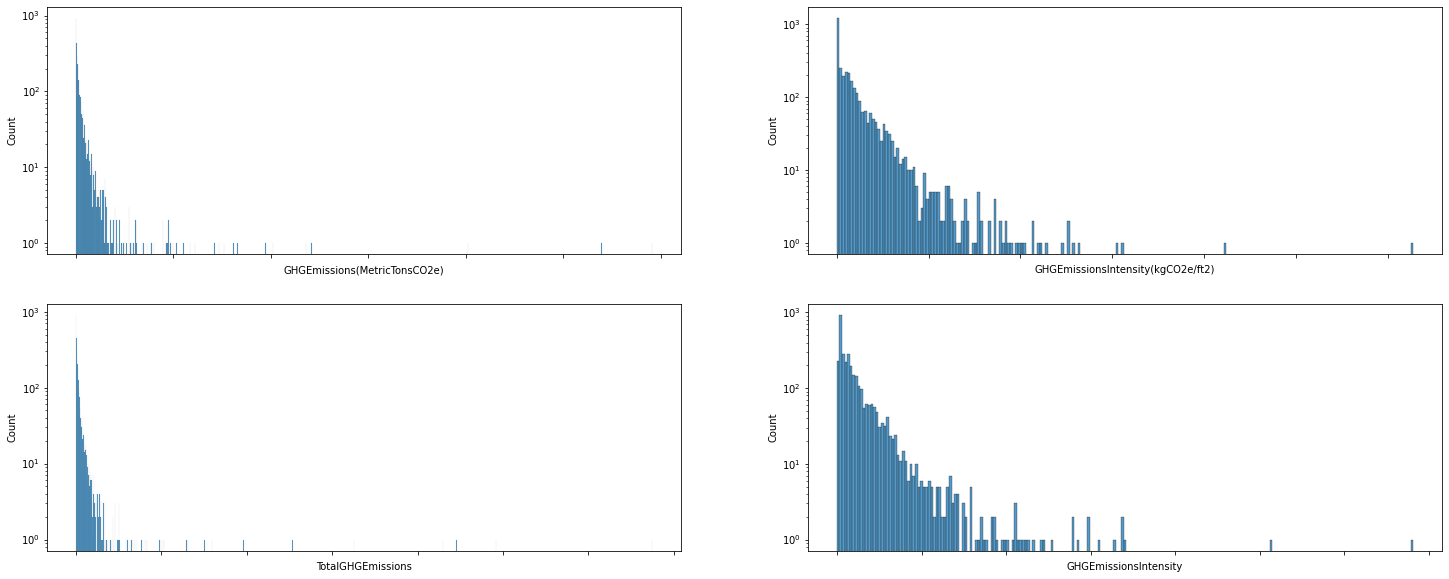

In [16]:
### Histogrammes de chacune de ces 4 pandas.Series
plt.figure('Comparaison 15-16 colonnes doute sur unites', figsize=(25,10)), plt.clf()
tab_col = np.array([df_2015['GHGEmissions(MetricTonsCO2e)'], df_2015['GHGEmissionsIntensity(kgCO2e/ft2)'], df_2016['TotalGHGEmissions'], df_2016['GHGEmissionsIntensity']])
for i, col in zip(range(1,5), tab_col):
    axe = plt.subplot(2,2,i)
    axe.set_xticklabels(labels = axe.get_xticklabels(), fontdict={'fontsize':16})
    sns.histplot(col, ax=axe, kde=False, log_scale=(False, True))
### Suppression des varaibales desormais inutiles
del tab_col, axe, i, col
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'01_Distribution_emissionsCO2_15vs16'+'.png')

In [17]:
### Descriptrion statistiques des deux colonnes en question pour la b2d de 2015
df_2015[['GHGEmissions(MetricTonsCO2e)','GHGEmissionsIntensity(kgCO2e/ft2)']].describe()

GHGEmissions(MetricTonsCO2e)  GHGEmissionsIntensity(kgCO2e/ft2)
count                   3330.000000                        3330.000000
mean                     110.094102                           0.985339
std                      409.450179                           1.637172
min                        0.000000                           0.000000
25%                        9.265000                           0.080000
50%                       32.740000                           0.460000
75%                       88.642500                           1.180000
max                    11824.890000                          31.380000

In [18]:
### Descriptrion statistiques des deux colonnes en question pour la b2d de 2015
df_2016[['TotalGHGEmissions','GHGEmissionsIntensity']].describe()

TotalGHGEmissions  GHGEmissionsIntensity
count        3367.000000            3367.000000
mean          119.723971               1.175916
std           538.832227               1.821452
min            -0.800000              -0.020000
25%             9.495000               0.210000
50%            33.920000               0.610000
75%            93.940000               1.370000
max         16870.980000              34.090000

### Nos doutes sont levés : il s'agit probablement de deux couples de paramètres équivalents, exprimés dans les mêmes unités.
### Gardons en tête qu'il y a des valeurs négatives dans la b2d 2016, ce qui a priori n'a pas de sens pour des émissions de gaz. Il faudra peut-être supprimer les éléments correspondants plus tard.

### <u>3.2.b) Intérêt des colonnes 'State' et 'City' de la b2d 2016 :</u>

In [19]:
df_2016['City'].value_counts(), df_2016['State'].value_counts()

(Seattle    3376
 Name: City, dtype: int64,
 WA    3376
 Name: State, dtype: int64)

### Ces colonnes ne nous apprennent rien, car l'information contenue y est constante, et ne permet de faire aucune différence parmis les éléments de la b2d. D'autant plus que la nature de cette information est déjà largement suggérée par l'intitulé du projet...
### On décide donc de s'en passer.

### <u>3.2.c) Exploration de la colonne 'Location' de la b2d 2015 :</u>

In [20]:
df_2015.loc[0,'Location']

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

### La plupart des clefs des dictionnaires constituant Location (15) correspondent à des colonnes de la b2d de 2016.
### On décide donc de préparer la création des nouvelles colonnes dans df_2015, à partir des informations contenues dans ces dictionnaires, en nommant ces colonnes explicitement comme celles de df_2016 (sauf pour 'City' et 'State', qui ne nous apprennent rien).
### Pour l'instant, on recueille les données, la création de colonnes se fera un peu plus loin dans ce script (voir partie 3.3.b), et dans des copies des b2d originales.

In [21]:
### On remplit des tableaux avec les valeurs associées à chaque clefs, en parcourant l'ensemble des éléments
tab_lat, tab_lon, tab_add, tab_zip = [], [], [], []
for elem in df_2015['Location'] :
    for dictio in plb.re.split(pattern='{|}', string=elem)[1:-2]:
        for keys_values in plb.re.split(pattern=',', string=dictio) :
            key_value = plb.re.split(pattern=':', string=keys_values)
            if 'latitude' in key_value[0] :
                tab_lat.append(float(plb.re.search(pattern='\d{1,10}\.\d{1,10}|-\d{1,10}\.\d{1,10}', string=key_value[1]).group(0)))
            elif 'longitude' in key_value[0] :
                tab_lon.append(float(plb.re.search(pattern='\d{1,10}\.\d{1,10}|-\d{1,10}\.\d{1,10}', string=key_value[1]).group(0)))
            elif 'address' in key_value[0] :
                if 'human_address' not in key_value[0] :
                    tab_add.append(plb.re.split('"', key_value[1])[1])
            elif 'zip' in key_value[0] :
                tab_zip.append(int(plb.re.search(pattern='\d{1,10}', string=key_value[1]).group(0)))
tab_lat, tab_lon, tab_add, tab_zip = np.array(tab_lat), np.array(tab_lon), np.array(tab_add), np.array(tab_zip)
# Suppression des varaibales desormais inutiles
del elem, dictio, keys_values, key_value

### On vérifie d'ailleurs que les adresses et les zipcodes correspondent, afin de repérer d'éventuelles erreures, ainsi que les batiments créées/disparus entre 2015 et 2016.
### On commence par utiliser le paramètre d'identification des batiments, qui constitue la colonne commune 'OSEBuildingID', pour vérifier que l'adresse est toujours la même :

In [22]:
# OSE ID communes aux deux années, avec indices correspondants au sein de chacune des deux b2d
oseid_commun, oseid_com15_indx, oseid_com16_indx = np.intersect1d(df_2015['OSEBuildingID'], df_2016['OSEBuildingID'], return_indices=True)
# OSE ID Spécifiques à chacune des deux années
oseid_specf15, oseid_specf16 = np.setdiff1d(df_2015['OSEBuildingID'], oseid_commun), np.setdiff1d(df_2016['OSEBuildingID'], oseid_commun)

### Regardons quelques exemples :

### <u>3.2.d) Vérifier que </u>

### <u>3.2.?) Explorations des colonnes authentiquement uniques de la b2d 2015 :</u>
### Il s'agit des paramètres suivants :
- 2010 Census Tracts (=recensement en 2010 ?) 
- City Councils Districs
- OyherFuelsUse(kBtu)
- SPD Beats (=subdivision territoriale correspondant à des patrouilles de polices)
- Seattle Police Department Micro Community Policing Plan Areas

df_2015[2010 Census Tracts] :
	 dtype = float64
df_2015[City Council Districts] :
	 dtype = float64
df_2015[OtherFuelUse(kBtu)] :
	 dtype = float64
df_2015[SPD Beats] :
	 dtype = float64
df_2015[Seattle Police Department Micro Community Policing Plan Areas] :
	 dtype = float64


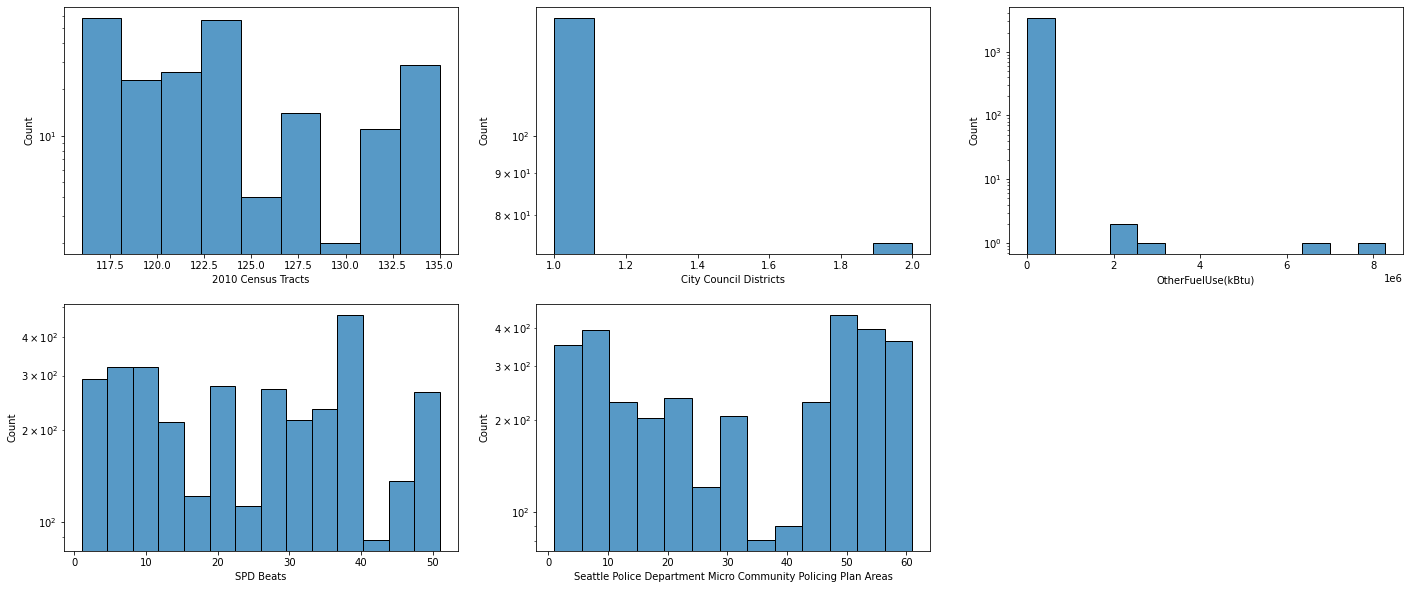

In [23]:
tab_col_vraiment_unique_2015 = ['2010 Census Tracts', 'City Council Districts', 'OtherFuelUse(kBtu)', 'SPD Beats', 'Seattle Police Department Micro Community Policing Plan Areas']
for colonne in tab_col_vraiment_unique_2015:
    print(f'df_2015[{colonne}] :\n\t dtype = {df_2015[colonne].dtype}')
plt.figure('Colonnes vraiment uniques 2015', figsize=(24,10)), plt.clf()
for i, colonne in zip(range(1,6), tab_col_vraiment_unique_2015):
    axe = plt.subplot(2,3,i)
    sns.histplot(df_2015[colonne], ax=axe, kde=False, log_scale=(False, True))
# Suppression des varaibales desormais inutiles
del colonne, i, axe
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'02_Distribution_colonnes_specfq_15'+'.png')

## <u>3.3) Mise au même format des colonnes effectivement communes au deux b2d.</u>

### <u>3.3.a) Créations de deux copies des b2d originales.</u>
### Avec deep=True, de sorte à pouvoir modifier ces deux copies sans répercutions sur les originaux.

In [24]:
df_15, df_16 = df_2015.copy(deep=True), df_2016.copy(deep=True)

In [25]:
df_15.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'DefaultData', '

In [26]:
df_16.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

### <u>3.3.b) Création et destruction de colonnes dans df_15 ; destruction de colonnes dans df_16.</u>
### On transforme 'Location' de df_15 en 4 colonnes homonyme à celles de df_16 (grâce aux données extraites en 3.2.c).
### A l'issue de cette opération, on détruit la colonne 'Location', désormais redondante. On supprime également l'ancienne colonne 'Zip Codes'.
### Enfin, on veille également à supprimer de df_16 les inutiles 'City' et 'State'.

In [27]:
### Créations des colonnes correspondantes
# On garde un booléen de protection, histoire de ne pas  créer par erreur les mêmes colonnes de multiples fois
if 'Location' in df_15.columns :
    if 'Latitude' not in df_15.columns :
        df_15['Latitude'] = tab_lat
    if 'Longitude' not in df_15.columns :
        df_15['Longitude'] = tab_lon
    if 'Address' not in df_15.columns :
        df_15['Address'] = tab_add
    if 'ZipCode' not in df_15.columns :
        df_15['ZipCode'] = tab_zip
### Destruction de 'Location' une fois ces colonnes bien crées
if np.logical_and(np.logical_and('Latitude' in df_15.columns, 'Longitude' in df_15.columns), np.logical_and('Address' in df_15.columns, 'ZipCode' in df_15.columns)):
    if 'Location' in df_15.columns :
        df_15.drop(columns=['Location'], inplace=True)
    if 'Zip Codes' in df_15.columns :
        df_15.drop(columns=['Zip Codes'], inplace=True)
### Destruction de 'Cigy' et 'State' dans df_16
if 'City' in df_16.columns :
    df_16.drop(columns=['City'], inplace=True)
if 'State' in df_16.columns :
    df_16.drop(columns=['State'], inplace=True)
### Suppression des variables desormais inutiles 
del tab_lat, tab_lon, tab_add, tab_zip

In [28]:
### On vérifie l'exécution de ces opérations
df_15.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'DefaultData', 'Comment',
       'C

In [29]:
df_16.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comments', 'ComplianceStatus', 'Outlier',
       'TotalGHGEmiss

### <u>3.3.c) Renommage de colonnes dans df_16.</u>
### Suite à nos remarques faites en 3.2.a), on aligne les noms des colonnes de df_16 sur celles de df_15, car ces dernières ont le mérite de faire explicitement apparaître l'unité des grandeurs qu'elles représentent.
### On fait également le changement 'Comments' -> 'Comment'

In [30]:
if np.logical_and('TotalGHGEmissions' in df_16.columns, 'GHGEmissionsIntensity' in df_16.columns):
    df_16.rename(columns={'TotalGHGEmissions':'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity':'GHGEmissionsIntensity(kgCO2e/ft2)'}, inplace=True)
if 'Comments' in df_16.columns :
    df_16.rename(columns={'Comments':'Comment'}, inplace=True)

In [31]:
### On vérifie l'exécution de ces opérations
df_16.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'ZipCode', 'TaxParcelIdentificationNumber',
       'CouncilDistrictCode', 'Neighborhood', 'Latitude', 'Longitude',
       'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'Comment', 'ComplianceStatus', 'Outlier',
       'GHGEmissions(M

### <u>3.3.d) Suppression des colonnes propres à la df_15, sans équivalents au sein de df_16.</u>
### Au pire, on pourra toujours aller les chercher dans la b2d originale de 2015.

In [32]:
for col15 in tab_col_vraiment_unique_2015:
    if col15 in df_15.columns :
        df_15.drop(columns=[col15], inplace=True)
del col15

In [33]:
#On vérifie que toutes les colonnes sont en commun
len(np.intersect1d(df_15.columns, df_16.columns)), len(df_15.columns), len(df_16.columns)

(44, 44, 44)

### <u>3.3.e) Interrogation sur les adresses et coordonnées gps des bâtiments commun aux deux b2d.</u>

In [34]:
# Initialisation de tableaux de rangement
tab_address, tab_gps = [], []
### Parcours des batiments communs entre 2015 et 2016
for indx_15, indx_16 in zip(oseid_com15_indx, oseid_com16_indx):
    ### Adresses
    # Accès aux adresses
    add15, add16 = df_15.loc[indx_15, 'Address'], df_16.loc[indx_16, 'Address']
    # Un peu d'égalisation de format des chaînes de caractère
    add15, add16 = add15.lower().replace('.', '').replace(' -', ''), add16.lower().replace('.', '').replace(' -', '')
    # Rangement dans la liste correspondante
    tab_address.append([add15, add16])
    ### Coordonnées GPS (latitude, longitude)
    # Accès aux coordonnées
    lat15, lat16, lon15, lon16 = df_15.loc[indx_15, 'Latitude'], df_16.loc[indx_16, 'Latitude'], df_15.loc[indx_15, 'Longitude'], df_16.loc[indx_16, 'Longitude']
    # Rangement dans la liste correspondante
    tab_gps.append([[lat15, lon15], [lat16, lon16]])
tab_address, tab_gps = np.array(tab_address), np.array(tab_gps)
for i in np.random.randint(0, len(tab_address), size=5):
    print(f'OSE ID = {oseid_commun[i]}')
    print(f'\t2015 :\n\t\tAdress = {tab_address[i,0]}\n\t\tLatitude = {tab_gps[i,0,0]}\n\t\tLongitude = {tab_gps[i,0,1]}')
    print(f'\t2016 :\n\t\tAdress = {tab_address[i,1]}\n\t\tLatitude = {tab_gps[i,1,0]}\n\t\tLongitude = {tab_gps[i,1,1]}')
### Suppression de vartaibles devenues désormais inutiles
del indx_15, indx_16, add15, add16, lat15, lat16, lon15, lon16

OSE ID = 21704
	2015 :
		Adress = 320 w republican st
		Latitude = 47.62351739
		Longitude = -122.3616359
	2016 :
		Adress = 320 w republican st
		Latitude = 47.6235
		Longitude = -122.3617
OSE ID = 503
	2015 :
		Adress = 3670 e marginal way s
		Latitude = 47.56886018
		Longitude = -122.3377912
	2016 :
		Adress = 3670 e marginal way s
		Latitude = 47.56895
		Longitude = -122.33775
OSE ID = 24276
	2015 :
		Adress = 1800 eastlake ave e
		Latitude = 47.63515404
		Longitude = -122.3250062
	2016 :
		Adress = 1800 eastlake ave e
		Latitude = 47.63516
		Longitude = -122.32502
OSE ID = 25554
	2015 :
		Adress = 304 alaskan way s
		Latitude = 47.59977722
		Longitude = -122.33515167
	2016 :
		Adress = 304 alaskan way s
		Latitude = 47.599759999999996
		Longitude = -122.33514
OSE ID = 20047
	2015 :
		Adress = 2623 ne university village st
		Latitude = 47.66375728
		Longitude = -122.3002168
	2016 :
		Adress = 2627 ne university village st
		Latitude = 47.662459999999996
		Longitude = -122.29898


### On y voit que même lorsque l'adresse ne diffère que de par son format (ce qui est facilement corrigeable par le cerveau humain, mais moins par celui de la machine), il existe des petites différences de coordonnées GPS. Elles ne sont d'ailleurs pas systématiquement imputables à une troncature décimale différente. Peut être ont elles été mesurées en des points légèrement différents des bâtiments concernés, mais en l'état, nous ne sommes pas capable de savoir à quoi elles sont dûes.
### Peut être vaut il mieux - pour l'instant en tout cas - ne pas perdre plus de temps avec ces écarts d'informations, car cela peut représenter bcp de travail pour peu de résultats immédiats.

In [35]:
### Suppression de vartaibles devenues désormais inutiles
del tab_address, tab_gps

### <u>3.3.f) Fusion des deux b2d :</u>.
### Enfin, pour faciliter notre travail, on fusionne ces deux copies des b2d originales, le paramètre <i>DataYear</i> permettant de remonter si besoin à chacune d'entre elle.

In [36]:
df_fusion = pd.concat([df_15, df_16], ignore_index=True).sort_values(by=['OSEBuildingID', 'DataYear'], axis=0, ignore_index=True)

In [37]:
df_fusion

OSEBuildingID  DataYear        BuildingType PrimaryPropertyType  \
0                 1      2015      NonResidential               Hotel   
1                 1      2016      NonResidential               Hotel   
2                 2      2015      NonResidential               Hotel   
3                 2      2016      NonResidential               Hotel   
4                 3      2015      NonResidential               Hotel   
...             ...       ...                 ...                 ...   
6711          50222      2016  Nonresidential COS              Office   
6712          50223      2016  Nonresidential COS               Other   
6713          50224      2016  Nonresidential COS               Other   
6714          50225      2016  Nonresidential COS  Mixed Use Property   
6715          50226      2016  Nonresidential COS  Mixed Use Property   

                             PropertyName TaxParcelIdentificationNumber  \
0                    MAYFLOWER PARK HOTEL                     659000030   
1                    Mayflower park hotel                    0659000030   
2                         PARAMOUNT HOTEL                     659000220   
3                         Paramount Hotel                    0659000220   
4                            WESTIN HOTEL                     659000475   
...                                   ...                           ...   
6711                Horticulture building                    1624049080   
6712  International district/Chinatown CC                    3558300000   
6713                      Queen Anne Pool                    1794501150   
6714          South Park Community Center                    7883603155   
6715          Van Asselt Community Center                    7857002030   

      CouncilDistrictCode           Neighborhood  YearBuilt  \
0                       7               DOWNTOWN       1927   
1                       7               DOWNTOWN       1927   
2                       7               DOWNTOWN       1996   
3                       7               DOWNTOWN       1996   
4                       7               DOWNTOWN       1969   
...                   ...                    ...        ...   
6711                    2       GREATER DUWAMISH       1990   
6712                    2               DOWNTOWN       2004   
6713                    7  MAGNOLIA / QUEEN ANNE       1974   
6714                    1       GREATER DUWAMISH       1989   
6715                    2       GREATER DUWAMISH       1938   

      NumberofBuildings  ...  GHGEmissions(MetricTonsCO2e)  \
0                   1.0  ...                        249.43   
1                   1.0  ...                        249.98   
2                   1.0  ...                        263.51   
3                   1.0  ...                        295.86   
4                   1.0  ...                       2061.48   
...                 ...  ...                           ...   
6711                1.0  ...                         20.94   
6712                1.0  ...                         32.17   
6713                1.0  ...                        223.54   
6714                1.0  ...                         22.11   
6715                1.0  ...                         41.27   

      GHGEmissionsIntensity(kgCO2e/ft2)  DefaultData  Comment  \
0                                  2.64           No      NaN   
1                                  2.83        False      NaN   
2                                  2.38           No      NaN   
3                                  2.86        False      NaN   
4                                  1.92          Yes      NaN   
...                                 ...          ...      ...   
6711                               1.70         True      NaN   
6712                               2.01        False      NaN   
6713                              16.99        False      NaN   
6714                               1.57        False      NaN   
6715       

# 
# 
# <u>4) Exploration.</u>

## <u>4.1) Densité de remplissage des différents paramètres.</u>
### On l'observe sous forme de diagramme en bar, pour chaque année, et sur tous les bâtiments.

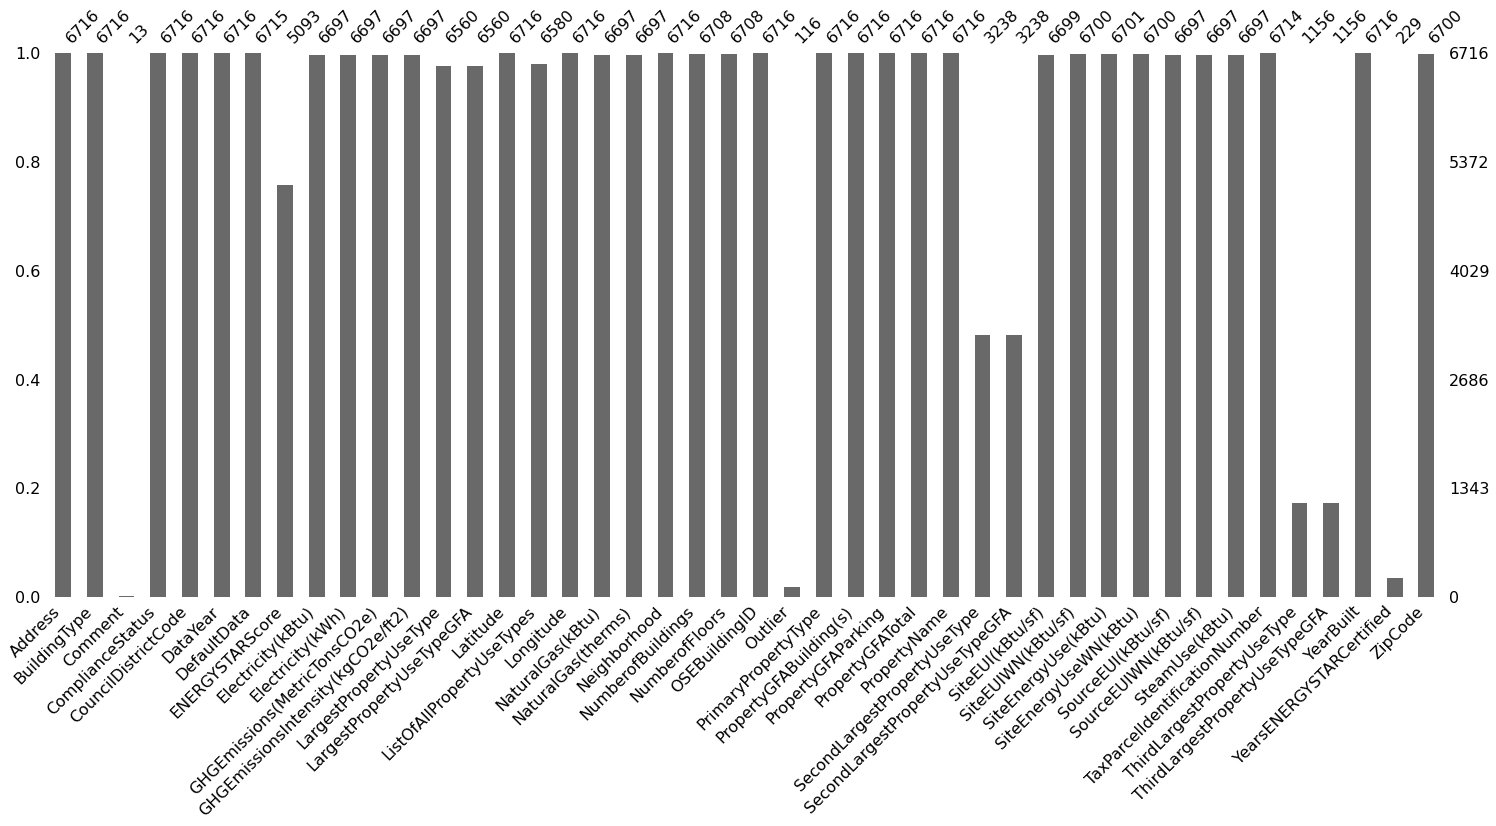

In [38]:
plt.figure('Densite de remplissage 15&s16', figsize=(25,6)), plt.clf()
bar(df_fusion.sort_index(axis=1))
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'03_Densite_remplissage_15et16'+'.png')

### Globalement, la b2d est remplie.
### Les quelques parmètres avec des taux de remplissages inférieurs à 50% sont les suivants (et les mêmes pour les deux années) :

In [39]:
for colonne_moitie_vide in df_fusion.columns[[df_fusion[col].value_counts().sum()/df_fusion.shape[0] < 0.5 for col in df_fusion.columns]]:
    print(colonne_moitie_vide, f'\n\trempli à {100*df_fusion[colonne_moitie_vide].value_counts().sum()/df_fusion.shape[0] : .1f} prct\n\tde type : ',df_fusion[colonne_moitie_vide].dtype, '\n')
### Suppression des varaibales desormais inutiles
del colonne_moitie_vide

SecondLargestPropertyUseType 
	rempli à  48.2 prct
	de type :  object 

SecondLargestPropertyUseTypeGFA 
	rempli à  48.2 prct
	de type :  float64 

ThirdLargestPropertyUseType 
	rempli à  17.2 prct
	de type :  object 

ThirdLargestPropertyUseTypeGFA 
	rempli à  17.2 prct
	de type :  float64 

YearsENERGYSTARCertified 
	rempli à  3.4 prct
	de type :  object 

Comment 
	rempli à  0.2 prct
	de type :  object 

Outlier 
	rempli à  1.7 prct
	de type :  object 



### Spontannément, les 4 premiers pourraient poser des PB à la marge pour l'algorithme final.
### En effet, ils concernent des informations sur le type d'emploi (<i>PropertyUseType</i>) ou la surface (<i>PropertyUseTypeGFA</i>, avec <i>GFA=Ground Floor Accessible</i>=Surface Accessible au Sol) des bâtiments.
### Cependent, ils n'apportent ces précisions que pour les bâtiments ayant plus d'un immeuble/d'un type d'emploi, c'est à dire probablement pas la majorité des bâtiments (ce qu'on verre par la suite). De fait, ces informations ne sont pas prioritaires pour bâtir un algorithme de prédictions, elles seront davantage utilent au moment d'améliorer au détail la précision du modèle.
### 
### Quelles valeurs ont les autres paramètres quasi vides ?

In [40]:
for categ in ['YearsENERGYSTARCertified', 'Comment', 'Outlier']:
    print(f'{categ}')
    print(df_fusion[categ].value_counts())
    print('')
### Suppression des varaibales desormais inutiles
del categ

YearsENERGYSTARCertified
2016                                    34
2014                                    12
2017                                     9
2016, 2015                               8
20172016                                 8
                                        ..
201620142012                             1
2017, 2015, 2014, 2013                   1
2015, 2014, 2012, 2010, 2008             1
2016201520122009                         1
201720162014201320122011201020092007     1
Name: YearsENERGYSTARCertified, Length: 116, dtype: int64

Comment
Under construction starting 09/2014 (old building demolished) and ending 9/2017. New Buildings (two) re-open 9/2017. Year built changed from 1953 to 2017.                                                                                                         1
Construction completed in mid 2015. The building was unoccupied for most of 2015.                                                                                             

### <i>YearsENERGYSTARCertified</i> nous apprend une année de certification 'ENERGYSTAR' --> <i>a priori</i> inutile --> on supprime cette colonne.
### <i>Comment</i> nous apprend des infos au détail --> dommage qu'il y en ait si peu, ce paramètre pourrait éventuellement servir si les bâtiments conicernés (petite dizaine sur 6676...) posent PB à l'algorithme, mais dans un 1er temps, on peut s'en passer --> on supprime cette colonne ET les éléments concernés.
### <i>Outlier</i> est une classification binaire qui nous apprend si il y a des valeurs abhérentes, et leur intensité (au passage, on remaqrue qu'on a oublié de faire la même mise au format entre 2015 et 2016) --> en raison de leur faible nombre (116 sur 6676), on ne prend pas un gros risque en supprimant cette colonne ET les éléments concernés.

In [41]:
### Suppression de la colonne 'YearsENERGYSTARCertified'
if 'YearsENERGYSTARCertified' in df_fusion.columns :
    df_fusion.drop(columns=['YearsENERGYSTARCertified'], inplace=True)
### Suppression de la colonne 'Comment' et des éléments qui ont des valeurs définies pour cette colonne 
if 'Comment' in df_fusion.columns :
    # Recherches des indices des éléments en question
    indices_comment = df_fusion['Comment'].dropna(axis=0, how='any').index
    # Suppression de ces éléments POUR TOUTES LES COLONNES
    df_fusion.drop(index=indices_comment, inplace=True)
    # Suppression de la colonne 'Comment'
    df_fusion.drop(columns=['Comment'], inplace=True)
    del indices_comment
### Suppression de la colonne 'Outlier' et des éléments qui ont des valeurs définies pour cette colonne
if 'Outlier' in df_fusion.columns :
    # Recherches des indices des éléments en question
    indices_outlier = df_fusion['Outlier'].dropna(axis=0, how='any').index
    # Suppression de ces éléments POUR TOUTES LES COLONNES
    df_fusion.drop(index=indices_outlier, inplace=True)
    # Suppression de la colonne 'Outlier'
    df_fusion.drop(columns=['Outlier'], inplace=True)
    del indices_outlier

In [42]:
### Affichage des colonnes de df_fusion pour vérifier la méthode :
df_fusion.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'DefaultData', 'ComplianceStatus',
       'Latitude', 'Longitude', 'Address', 'ZipCode'],
  

### Enfin, on crée donc un tableau dans lequel on rangera les noms des paramètres qui seront finalement retenus à l'issue de ce script pour constituer la base de données réduite et nettoyée surlaquelle s'appuira notre algorithme (donc étiquettes ET caractéristiques). Ce tableau sera régulièrement mise à jour au cours de l'analyse.

In [43]:
tab_param_retenus = []

### On renseigne les deux premiers paramètres de cette liste, à savoir ceux qui permettent l'identification formelle de chaque bâtiment : <i>OSEBuildingID</i> et <i>DataYear</i>.

In [44]:
for param in ['OSEBuildingID', 'DataYear']:
    if param in tab_param_retenus :
        print('Paramètre déjà retenu.')
    else :
        tab_param_retenus.append(param)
del param    

## 
## <u>4.2) Analyse sommaire des étiquettes<u>.

### A propos d'algorithme, celui-ci doit prédire la consommation totale d'énergie et la consommation de CO2 de tous les bâtiments.
### On repère un grand nombre de colonnes des b2d qui pourraient correspondre. 
### Au passage, quelques remarques plus ou moins à voix haute :
- <i>EUI</i> = <i>Energy Use Intensity</i> : homogène à une énergie / surface / année (donc sur une année, homogène à une énergie par unité de surface) ;
- <i>BTU</i> = <i>British Thermal Units</i> : homogène à une énergie (~ 0.293 Wh ou 1054 J);
- <i>SF</i> = <i>Square Feet</i> : unité de surface (~0.093 m²);
- <i>FT2</i> = <i>Foot²</i> : unité de surface, identique à la précédente;
- <i>Site vs Source</i> : la source tient compte de tout ce qui est fourni depuis l'extérieur au bâtiment (elle inclut donc les pertes Joules, entre autres), alors que <i>site</i> traduit les énergies primaires et secondaires (c'est à dire la consommation brute, et ce qui est produit à partir de cette consommation brute).

### (On fera un traitement à part pour ENERGYSCORE). 
### Commençons par nommer explicitement ces paramètres :

In [45]:
colonnes_energies = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
       'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)',
       'NaturalGas(therms)', 'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)']

### De part la nature des grandeurs physiques qu'ils représentent, ces paramètres ne doivent pas incorporer de valeurs strictement négatives. Une analyse rapide indique néanmoins la présence de quelques valeurs abhérentes. Bien qu'ultra-minoritaires, on prend nénamoins le temps de les supprimer de la b2d df_fusion :

In [46]:
# On crée une variable locale pour se faciliter le travail à venir
df_ene_neg = df_fusion[colonnes_energies].where(df_fusion[colonnes_energies]<0).dropna(axis=0, how='all')
df_ene_neg

SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  \
6453               NaN                 NaN                 NaN   

      SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  \
6453                  -2.1                  NaN                    NaN   

      SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  \
6453             NaN      -33826.80078          -115417.0                 NaN   

      NaturalGas(kBtu)  GHGEmissions(MetricTonsCO2e)  \
6453               NaN                          -0.8   

      GHGEmissionsIntensity(kgCO2e/ft2)  
6453                              -0.02

In [47]:
if df_ene_neg.empty == False :
    print('Il y avait bien des éléments conduisants à des valeurs négatives pour ces paramètres.')
    # Recherche des indices des éléments correspondants
    ind_ene_neg = df_ene_neg.index
    # Suppression de ces éléments au sein de toute la b2d
    df_fusion.drop(index=ind_ene_neg, inplace=True)
    del ind_ene_neg
else :
    print('Il n y avait finalement aucune valeur négative parmi celles prises par ces paramètres.')
del df_ene_neg

Il y avait bien des éléments conduisants à des valeurs négatives pour ces paramètres.


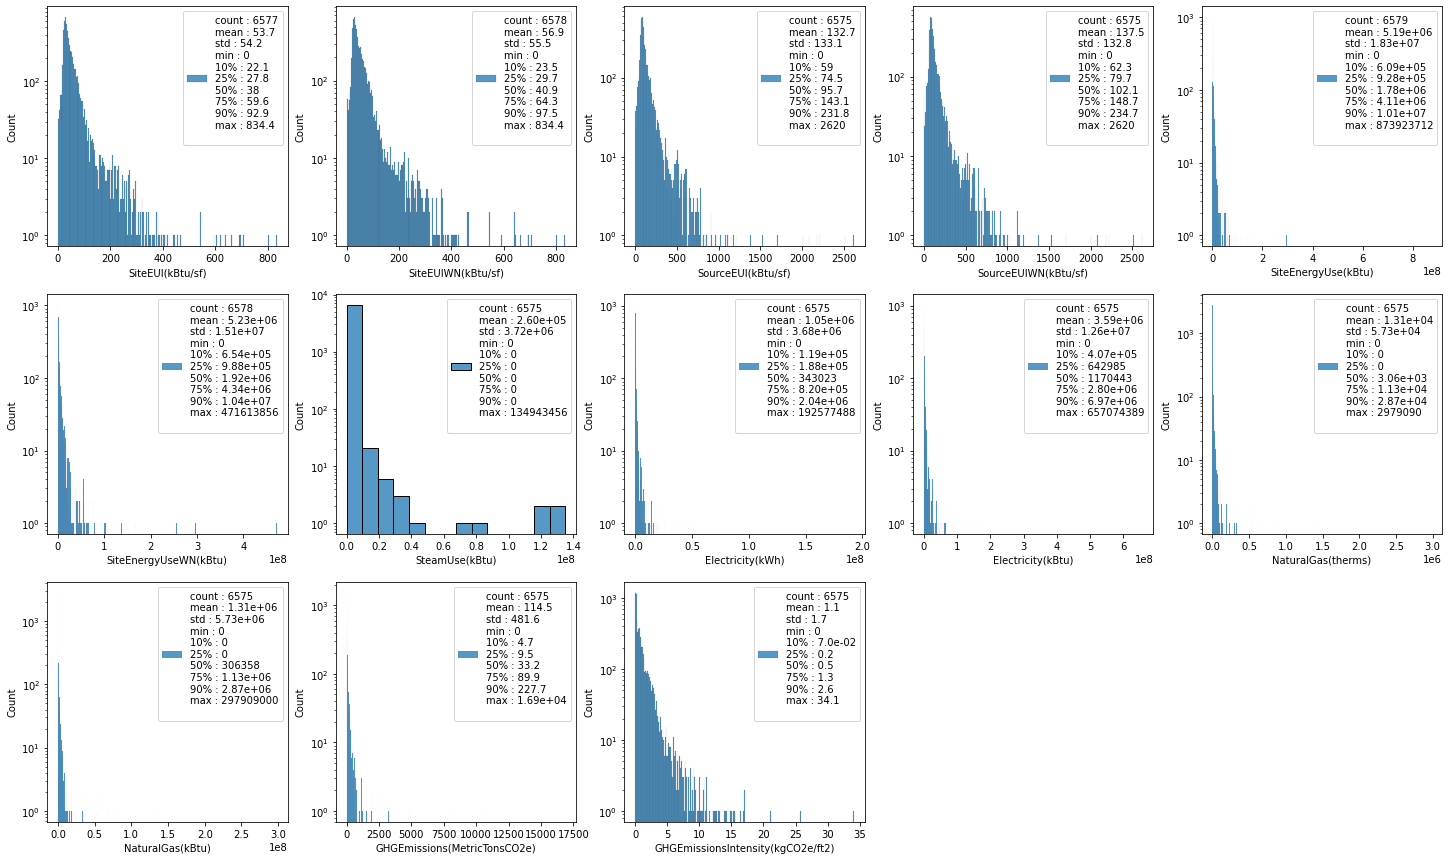

In [48]:
if 1==1:
    # Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
    df = df_fusion[colonnes_energies]
    plt.figure('Distribution grandeurs énergies - df_fusion', figsize=(25,15)), plt.clf()
    for i, colonne in zip(range(1,len(df.columns)+1), df.columns):
        axe = plt.subplot(3,5,i)
        text, description = f'', dict(df[colonne].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))
        # on met en légende de chaque graphes une description statistique du paramètre concerné
        for clef in description:
            text += '%s : %i\n'%(clef, description[clef]) if description[clef]==int(description[clef]) else '%s : %.1e\n'%(clef, description[clef]) if description[clef]<0.1 else '%s : %.2e\n'%(clef, description[clef]) if description[clef]>1000 else '%s : %.1f\n'%(clef, description[clef])
        sns.histplot(df[colonne], ax=axe, kde=False, log_scale=(False, True), legend=True, label=text)
        plt.legend(loc='best')
    del df, i, colonne, axe, text, description, clef
    if Sauvegarde_figure :
        plt.savefig(abs_path_fig+'04_Distribution_toutes_etiquettes_15et16'+'.png')

### Quelques remarques :

### (1) Les profils de distributions ont l'air assez semblables, à 1ère vue la gaussienne mono-mode ne serait pas une mauvaise approximation. Cela ne serait pas vraiment surprennant car la nature de ces grandeurs laisse supposer qu'il existe des conversions simples, et sûrement linéaires entre elles. Affichons donc les matrices des corrélations linéaires de ces deux Dataframe : 

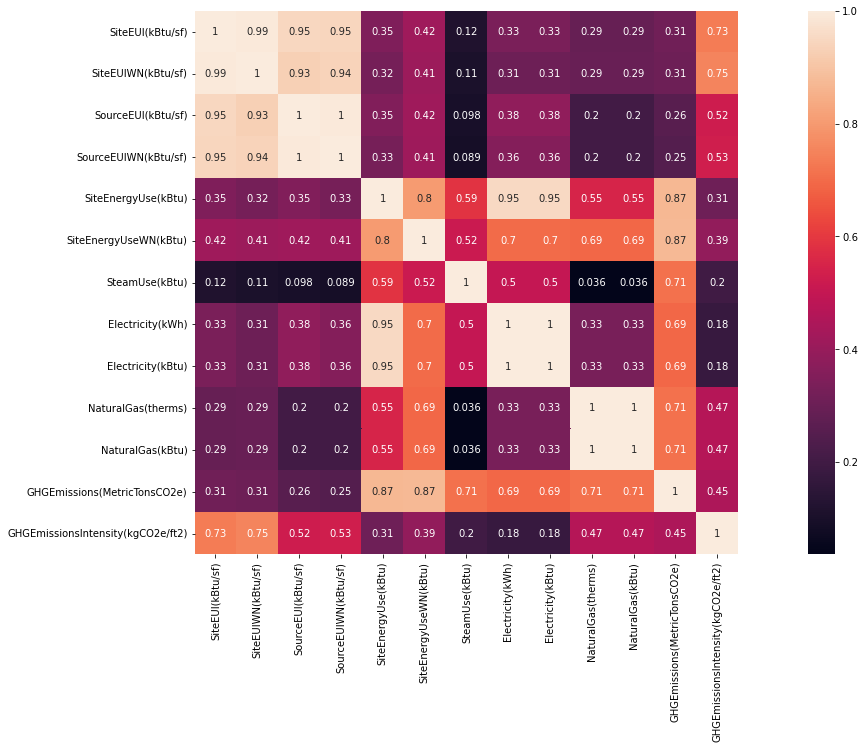

In [49]:
if 1==1 :
    # Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
    df = df_fusion[colonnes_energies]
    plt.figure('Matrice correlation grandeurs energies - df_fusion', figsize=(25,10)), plt.clf()
    axe = plt.subplot(1,1,1)
    sns.heatmap(df.corr(), ax=axe, cbar=True, square=True, annot=True)
    del df, axe
    if Sauvegarde_figure :
        plt.savefig(abs_path_fig+'05_Matrice_corr_toutes_etiquettes_15et16'+'.png')

### (1.bis) De très fortes corrélations linéaires appraissent entre plusieurs paramètres :
###     a) Pour certains, cela vient du fait qu'ils portent la même information exprimée selon deux unités différentes (kBtu et kWh ; kBtu et therms), et dans ce cas là, le coeffcient est d'ailleurs égal à 1. Autrement dit, on n'a pas besoin de conserver les deux paramètres, car connaître l'un permet de déduire exactement l'autre par simple proportionalité. 
###     b) Certains paramètres (comme par exemple entre <i>SiteEUI</i> et <i>SourceEUI</i>) sont liés par la relation <i>Site-Source</i> (voir explications sur https://www.energystar.gov/buildings/benchmark/understand_metrics/source_site_difference), rendnat ainsi le coefficient de corrélation linéaire très proche de 1 ( > 0.92).
###     c) Certains paramètres (comme par exemple entre <i>SiteEUI</i> et <i>SiteEUIWN</i>) présentent aussi des coeeficient quasiment égaux, ou égaux à 1, ce qui démontre qu'il doit exister une relation de type <i>EnergyUse-EnergyUseWN</i>. Cette relation doit cependant être un peu moins linéaire que <i>Site-Source</i>, car le coeff. entre <i>SiteEnergyUse</i> et <i>SiteEnergyUseWN</i> n'est "que" de 0.8.
###     d) <i>SiteEnergyUse</i> et <i>Electricity</i>  présentent un coeff. quasi-égal à 1, quand <i>SiteEnergyUse</i> et <i>GHGEmissions(MetricTonsCO2e)</i> présentent un très fort coefficient (0.87) mais qui demeure toute fois un peu moins impressionnant que les précédents.

### !!!
### <u>CHOIX FORT</u>
### De fait, sans avoir pour l'instant besoin de passer par de l'APC pour déduire de meilleure composante, on peut, dans une 1er temps, délaisser les paramètres qui présentent un coeeficient de corrélation linéaire > à 0.9 avec d'autres paramètres, car au delà de ce seuil, et en 1ère approximations, les distributions sont les mêmes à un facteur multiplicatif constant près.
### !!!
### Pour choisir 1 seul paramètre parmis ceux liés par de tels coefficients, on se fixe les règles suivantes (par ordre de priorité) :
- il nous faut absolument conserver le paramètre SiteEnergyUse(kBtu) 
- par cohérence avec la ligne précédente, on privilégie, si cela peut avoir lieu, l'unité British Thermal Units  ;
- par cohérence avec la ligne N-2, on privilégie le <i>Site</i> sur la <i>Source</i> (bien que selon les ressources du projet, <i>Source</i> est un meilleur moyen de comparer objectivement des batiments entre eux) ;
- on privilégie la <i>EnergyUse</i> sur le <i>EnergyUseWN</i>, car on n'a pas trouvé dans les ressource ce à quoi correspondait physiquement le terme WN.

### Ca nous laisse le vecteur étiquette suivant (composé "manuellement" car on a finalement un nombre de paramètres très gérable en tenant compte de ces critères) :

In [50]:
param_target = ['SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)']

In [51]:
### Ajout des étiquettes :
for param in param_target:
    if param in tab_param_retenus :
        print('Paramètre déjà retenu.')
    else :
        tab_param_retenus.append(param)
del param

<Figure size 2160x2160 with 0 Axes>

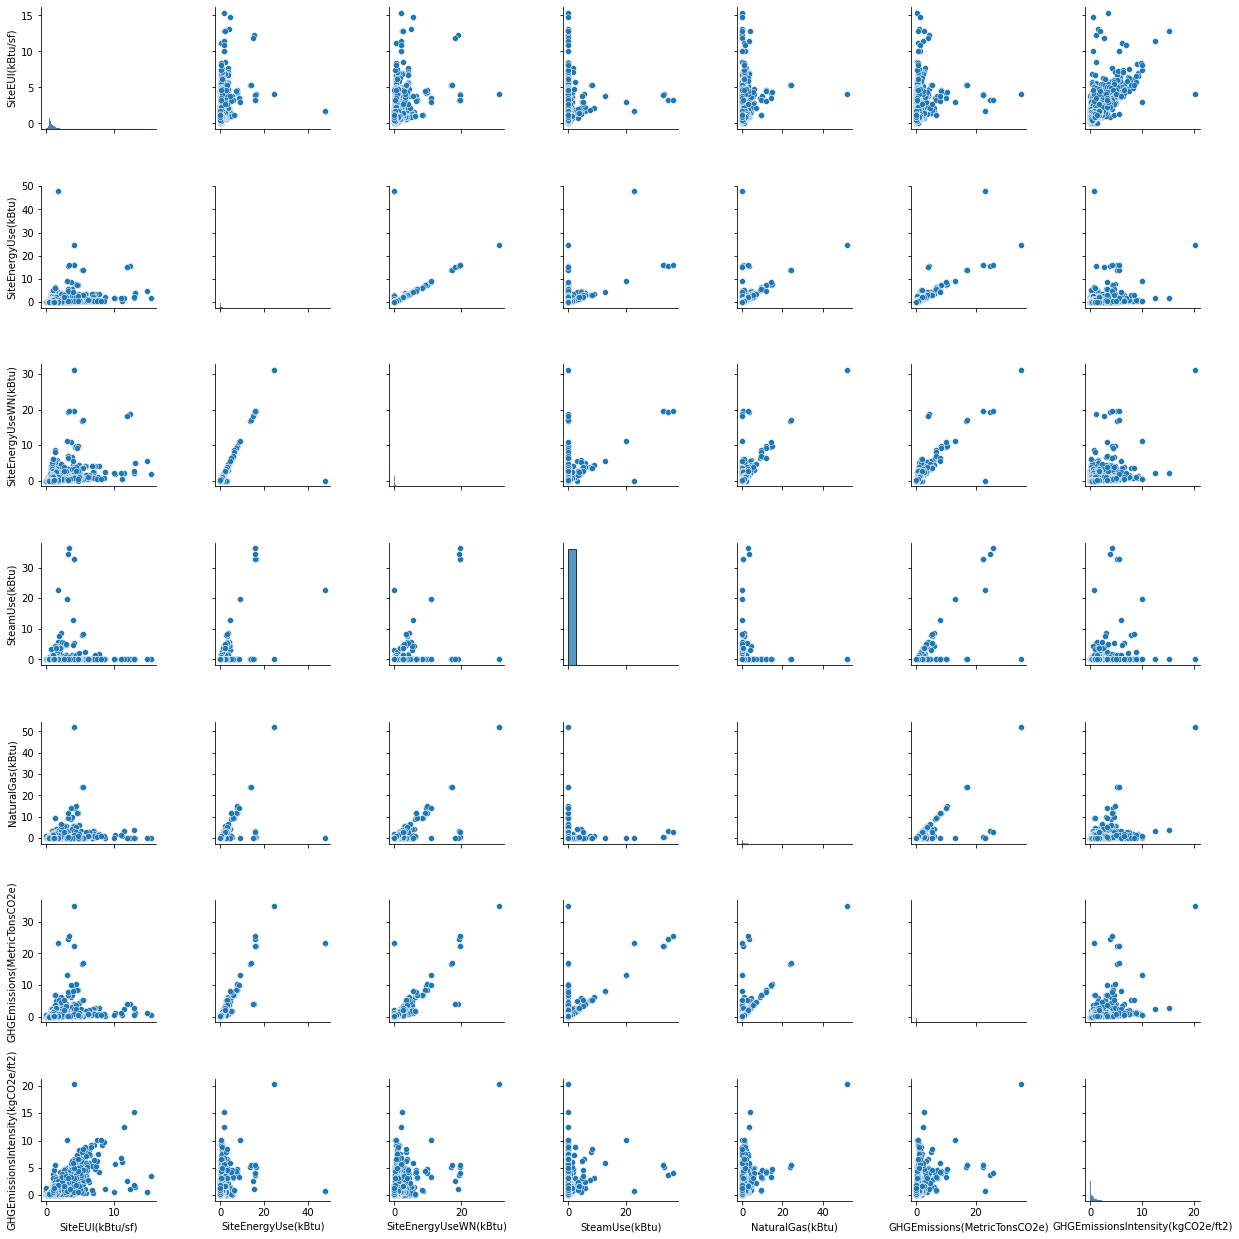

In [52]:
plt.figure('Param target - df_fusion - pairplot', figsize=(30,30))
df, scaler =df_fusion[param_target], StandardScaler(with_mean=False)
df_plot = pd.DataFrame(scaler.fit_transform(df), columns=param_target)
sns.pairplot(df_plot)
del df, df_plot, scaler
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'06_Pairplot_toutes_etiquettes_15et16'+'.png')

## 
## <u>4.3) Recherche des paramètres<u>.

### Il nous faut maintenant retenir un premier jeu de paramètres surlequel baser notre algorithme.
### Quelles sont les difficultés posées par ce jeu de données ?
### (1) L'énoncé suggère des paramètres de natures très différentes :
- taille (quantitatif)
- usage des bâtiments (qualitatif)
- mention de travaux récent (quali)
- année de construction (quanti)
- etc
### Spontannément, on peut inclure des paramètres tels que :
- le nombre de bâtiments (quanti)
- le nombre d'étage (quanti)
- la localisation (quanti si par coordonnées GPS, quanti si par District, quali si par Voisinage).

### (2) Comme on vient de le voir, certains paramètres sont numériques/quantitatifs, quand d'autres sont catégoriques/qualitatifs. 
### (2bis) Certains paramètres numériques (tels que <i>CouncilDistrictCode</i>, ou encore <i>YearBuilt</i>) peuvent même être facilement convertis en catégories. Ces différences sont importantes car elles vont conditionner le type d'algorithme employé, voire vont nécessiter de combiner différents algorithmes.

### 
### <u>4.3.a) Analyse quant à la taille des bâtiments.</u>
#### 
### <u>4.3.a(1) Paramètres concernés.</u>
### Commençons par faire un peu d'analyse univariée entre des paramètres directement liés à la taille des bâtiments. Ces paramètres sont ceux qui incorporent le terme <i>GFA</i> dans leur libellés :

In [53]:
param_gfa = df_fusion.columns[['GFA' in col for col in df_fusion.columns.values]]
param_gfa

Index(['PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA'],
      dtype='object')

#### 
### <u>4.3.a(2) Nettoyage :</u>
### <u>A) Eliminer les valeurs négatives :</u>
### Puisqu'il s'agit de surfaces, nous devons nous assurer que toutes les éléments de la b2d prennent des valeurs positives ou nulles pour ces paramètres : on recherche donc d'éventuelles valeurs négatives, et si c'est le cas, on éliminera les éléments correspondant de l'intégralité de la b2d :

In [54]:
df_gfa_neg = df_fusion[param_gfa].where(df_fusion[param_gfa]<0).dropna(axis=0, how='all')
df_gfa_neg

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
4827               NaN                -3.0                     NaN   
6231               NaN                -2.0                     NaN   
6237               NaN                 NaN                -43310.0   
6616               NaN                 NaN                -50550.0   

      LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
4827                        NaN                              NaN   
6231                        NaN                              NaN   
6237                        NaN                              NaN   
6616                        NaN                              NaN   

      ThirdLargestPropertyUseTypeGFA  
4827                             NaN  
6231                             NaN  
6237                             NaN  
6616                             NaN

In [55]:
if df_gfa_neg.empty == False :
    print('Il y avait bien des éléments conduisants à des valeurs négatives pour ces paramètres.')
    # Recherche des indices des éléments correspondants
    ind_gfa_neg = df_gfa_neg.index
    # Suppression de ces éléments au sein de toute la b2d
    df_fusion.drop(index=ind_gfa_neg, inplace=True)
    del ind_gfa_neg
else :
    print('Il n y avait finalement aucune valeur négative parmi celles prises par ces paramètres.')
del df_gfa_neg

Il y avait bien des éléments conduisants à des valeurs négatives pour ces paramètres.


### <u>B)Eliminer les éléments qui ne respectent pas un minimum de hierarchie.</u>
### Comme on le verra par la suite de ce script, les définitions des différents types de surfaces ne sont pas toujours exclusives (c'est à dire qu'il y a parfois du recouvrement de même surface entre les différentes catégories définies par ces paramètres).
### Néanmoins, on peut affirmer que si un élément ne respecte pas au minimum la relation <i>PropertyGFATotal</i> >= <i>LargestPropertyUseTypeGFA</i>, c'est donc qu'il y a un PB avec celui-ci, et qu'il doit être éliminé de la b2d.
### (NB : Pour ce qui est de <i>PropertyGFAParking</i> et <i>PropertyGFABuilding</i>, on prouvera dans quelques lignes que non seulement ils respectent toujours cette hiérarchie, mais qu'en plus ils sont complémentaires entre eux pour restituer <i>PropertyGFATotal</i>)

In [56]:
(df_fusion['PropertyGFATotal']-df_fusion['LargestPropertyUseTypeGFA']).describe(percentiles=[0.01, 0.05, 0.075, 0.09, 0.1])

count      6430.000000
mean      15861.136703
std       50238.514202
min     -635669.000000
1%       -33952.000000
5%        -3464.000000
7.5%       -858.475000
9%          -98.780000
10%           0.000000
50%         495.500000
max      887309.000000
dtype: float64

### Bien que trè sminoritaires, on a quand même 9% des éléments qui ne respectent pas cette hiérarchie. Nous décidons donc de les retirer de TOUTE la b2d :

In [57]:
df = df_fusion[['PropertyGFATotal', 'LargestPropertyUseTypeGFA']].copy(deep=True)
indx_elem_pb_hier_gfa = df.where(df['PropertyGFATotal']-df['LargestPropertyUseTypeGFA']<0).dropna(axis=0, how='any').index
df_fusion.drop(index=indx_elem_pb_hier_gfa, inplace=True)
del df, indx_elem_pb_hier_gfa

#### 
### <u>4.3.a(3) Description statistique de ces paramètres.</u>
### Bien, jettons un oeil à la description statistique de ces paramètres :

In [58]:
df_fusion[param_gfa].describe(percentiles=np.linspace(0.1,0.9,9))

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
count      5.955000e+03         5955.000000            5.955000e+03   
mean       9.294268e+04        10089.223678            8.285346e+04   
std        1.940229e+05        35053.403667            1.789955e+05   
min        1.128500e+04            0.000000            5.236000e+03   
10%        2.277880e+04            0.000000            2.223400e+04   
20%        2.607500e+04            0.000000            2.530100e+04   
30%        3.061400e+04            0.000000            2.922620e+04   
40%        3.643160e+04            0.000000            3.472800e+04   
50%        4.364400e+04            0.000000            4.153600e+04   
60%        5.477000e+04            0.000000            5.156800e+04   
70%        7.388440e+04            0.000000            6.684900e+04   
80%        1.087530e+05         5204.400000            9.667780e+04   
90%        1.935000e+05        25355.400000            1.638700e+05   
max        9.320156e+06       512608.000000            9.320156e+06   

       LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
count               5.801000e+03                      2940.000000   
mean                7.378578e+04                     27213.166428   
std                 1.707282e+05                     50412.441897   
min                 5.656000e+03                         0.000000   
10%                 2.046000e+04                      1774.000000   
20%                 2.305000e+04                      4200.000000   
30%                 2.600000e+04                      6183.100000   
40%                 3.101700e+04                      8241.000000   
50%                 3.758000e+04                     10900.000000   
60%                 4.592900e+04                     14572.800000   
70%                 6.000000e+04                     21203.000000   
80%                 8.824800e+04                     32885.000000   
90%                 1.467410e+05                     66452.000000   
max                 9.320156e+06                    686750.000000   

       ThirdLargestPropertyUseTypeGFA  
count                     1073.000000  
mean                     11104.999440  
std                      23406.641888  
min                          0.000000  
10%                        530.200000  
20%                       1595.000000  
30%                       2825.000000  
40%                       4000.000000  
50%                       5090.000000  
60%                       6491.200000  
70%                       9000.000000  
80%                      13070.800000  
90%                      21782.000000  
max                     303910.000000

### Plusieurs remarques :
- (1) Il y a de nettes différences de moyennes, ce qui confirme une hiérarchisation de ces surfaces, comme les intitulés des paramètres pouvaient le suggérer.
- (2) Les paramètres <i>2nd et 3rtd LargestPropert[...]</i> présentent un minimum = à 0, ce qui pourrait compliquer notre envie de remplacer chacune de leur NaN par 0; si ion conserve ces paramètres, il faudra vérifier que là où il y a NaN, on est en état d'assurer qu'il n'y a qu'un seul type d'usage du bâtiment avant de remplacer cette NaN par 0.
- (3) <i>PropertGFAParking</i> contient au contraire énormément de 0 (au moins 70% de ses valeurs), ce paramètre posera peut être problèlme au moment de faire subbir des transformations à sa distribution (en tout cas, le StandardScaler() en est probablement compromis.

#### 
### <u>4.3.a(4) Potentielle réduction du nombre de NaN des paramètres <i>2nd et 3rtd LargestProperty[...]</i>.</u>
### On a très envie de remplacer chaque NaN par un 0 pour ces deux paramètres, du fait de leur définition. Mais il faut pour cela s'assurer que là où il y a une NaN, c'est parce que toute la surface est déjà exprimée au sein d'autres paramètres.

In [59]:
# On recherche les indices des NaN pour ces deux paramètres
indx_na_2nd_gfa, indx_na_3nd_gfa = df_fusion.index[df_fusion['SecondLargestPropertyUseTypeGFA'].isna()], df_fusion.index[df_fusion['ThirdLargestPropertyUseTypeGFA'].isna()]
# On vérifie que les indices des NaN de SecondLargestPropertyUseTypeGFA correspondent également à des Nan pour ThirdLargestPropertyUseTypeGFA
np.array_equal(indx_na_2nd_gfa, np.intersect1d(indx_na_2nd_gfa, indx_na_3nd_gfa))

True

### On ne peut changer une NaN en 0 avec certitude QUE pour les éléments dont <i>PropertyGFATotal</i> et <i>LargestPropertyUseTypeGFA</i> sont égaux (car ça signifie qu'il n'ya QU'UN SEUL type d'usage du bâtiment, donc une seul type de surface).

In [60]:
(df_fusion['PropertyGFATotal']-df_fusion['LargestPropertyUseTypeGFA']).loc[indx_na_2nd_gfa].value_counts()

0.0        2155
5248.0        4
20.0          4
6645.0        4
10.0          4
           ... 
5982.0        1
3643.0        1
40498.0       1
7020.0        1
506.0         1
Length: 395, dtype: int64

### On peut remplacer NaN par 0 de façon certaine pour 2155 éléments sur 3015 NaN (soit ~72% d'entre elles). C'est déjà pas mal ! D'autant que ça vaut aussi pour <i>3rdLargestPropert[...]</i> aux mêmes indices ! D'une pierre deux coups !

In [61]:
df = df_fusion[['PropertyGFATotal', 'LargestPropertyUseTypeGFA']].loc[indx_na_2nd_gfa].copy(deep=True)
indx_2ndgfa_nannulles = df.where(df['PropertyGFATotal']-df['LargestPropertyUseTypeGFA']==0).dropna(axis=0, how='any').index
df_fusion.loc[indx_2ndgfa_nannulles, 'SecondLargestPropertyUseTypeGFA'] = 0
df_fusion.loc[indx_2ndgfa_nannulles, 'ThirdLargestPropertyUseTypeGFA'] = 0
del df, indx_2ndgfa_nannulles

### On peut reprendre ces opérations, mais pour <i>ThirdLargestPropertyUseTypeGFA</i> cette fois ci (car ce paramètre vient de s'enrichir de 2155 nouveaux 0)

In [62]:
indx_na_3nd_gfa = df_fusion.index[df_fusion['ThirdLargestPropertyUseTypeGFA'].isna()]
indx_na_3nd_gfa

Int64Index([   5,   10,   11,   12,   13,   18,   19,   20,   21,   26,
            ...
            6681, 6682, 6683, 6684, 6687, 6688, 6689, 6690, 6697, 6698],
           dtype='int64', length=2727)

### Voici notre critère de sécurité cette fois-ci : on ne peut changer une NaN en 0 avec certitude QUE pour les éléments dont <i>PropertyGFATotal</i> et la somme <i>LargestPropertyUseTypeGFA</i>+<i>SecondLargestPropertyUseTypeGFA</i> sont égaux (car ça signifie qu'il n'y a AU PLUS QUE DEUX types d'usage du bâtiment, donc pas de 3ème type de surface).

In [63]:
(df_fusion['PropertyGFATotal']-df_fusion['LargestPropertyUseTypeGFA']-df_fusion['SecondLargestPropertyUseTypeGFA']).loc[indx_na_3nd_gfa].value_counts()

 0.0         753
-15000.0       6
-400.0         5
-4000.0        5
 1.0           5
            ... 
 4322.0        1
 366893.0      1
 49558.0       1
-31746.0       1
-2880.0        1
Length: 608, dtype: int64

### On peut donc remplacer Nan par 0 de façon certaine pour 753 éléments sur 2727 Nan (soit ~27% d'entre elles). C'est toujours ça de pris.

In [64]:
df = df_fusion[['PropertyGFATotal', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA']].loc[indx_na_3nd_gfa].copy(deep=True)
indx_3rdgfa_nannulles = df.where(df['PropertyGFATotal']-df['LargestPropertyUseTypeGFA']-df['SecondLargestPropertyUseTypeGFA']==0).dropna(axis=0, how='any').index
df_fusion.loc[indx_3rdgfa_nannulles, 'ThirdLargestPropertyUseTypeGFA'] = 0
del df, indx_3rdgfa_nannulles

#### 
### <u>4.3.a(5) La surface a t'elle bien une influence sur la consommation/production de CO2 ?</u>
### Bien, assurons nous désormais que chaquye surface influe sur les données de consommation/production d'énergie, sans quoi il ne serait pas utile de les prendre en considération.
### On affuiche donc ci-dessous la position de chaque élément de la b2d dans un espace (X,Y) où :
- X appartient aux paramètres surfaciques
- Y appartient aux paramètres du vecteur étiquette.
### On notera que les distributions ont toutes vu leurs écart-types préalablement normalisés, du fait de leurs natures physiques et leurs ordres de grandeurs parfois très différents. En revanche, la moyenne n'a pas été ramenée à 0, car 0 est une borne inférieure physique pour chacun de ces paramètres. 

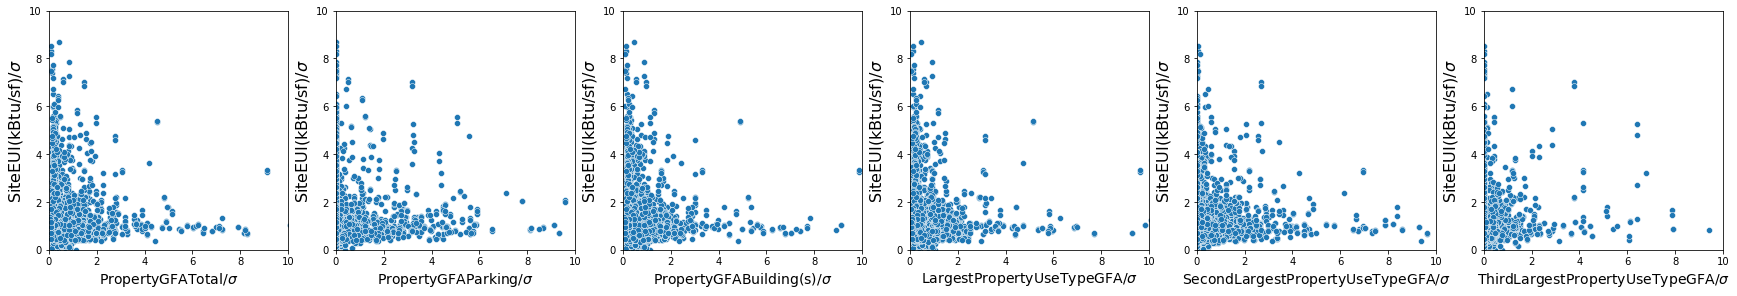

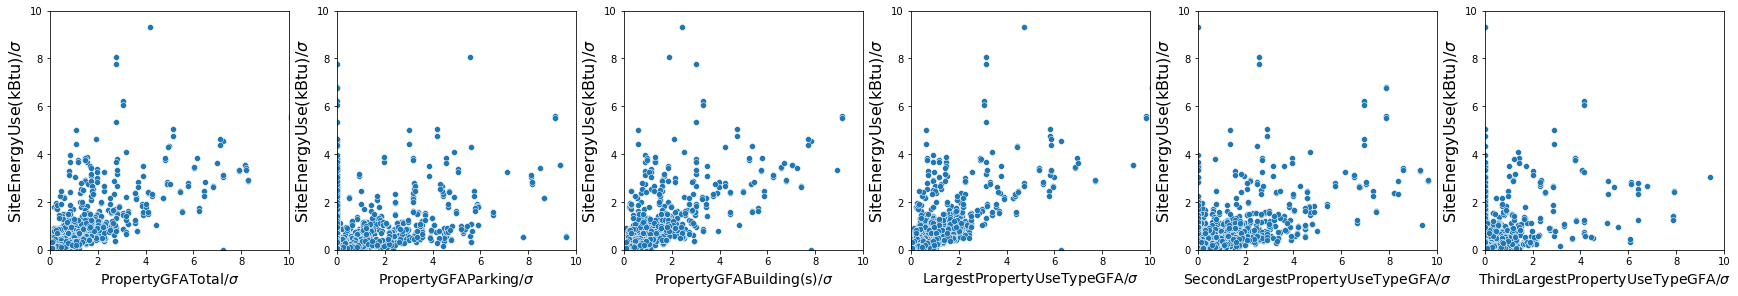

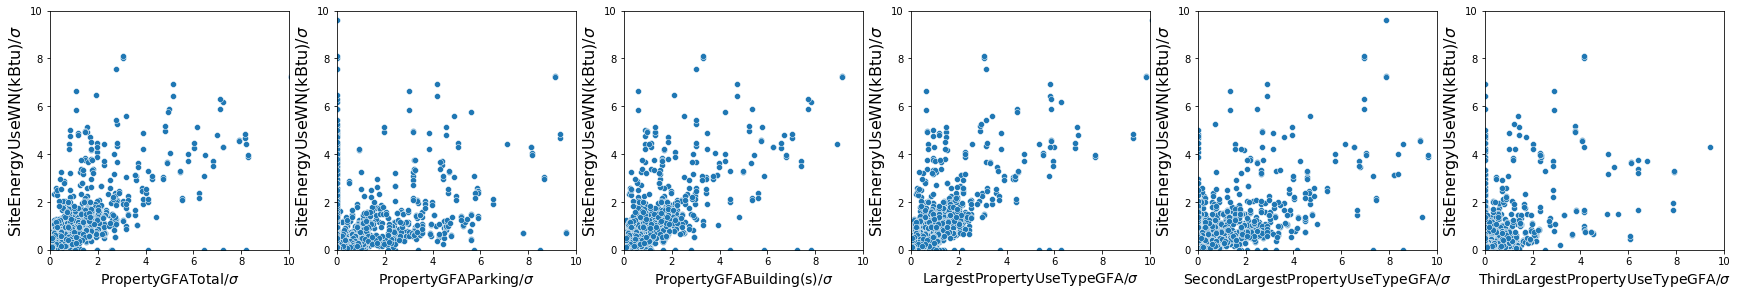

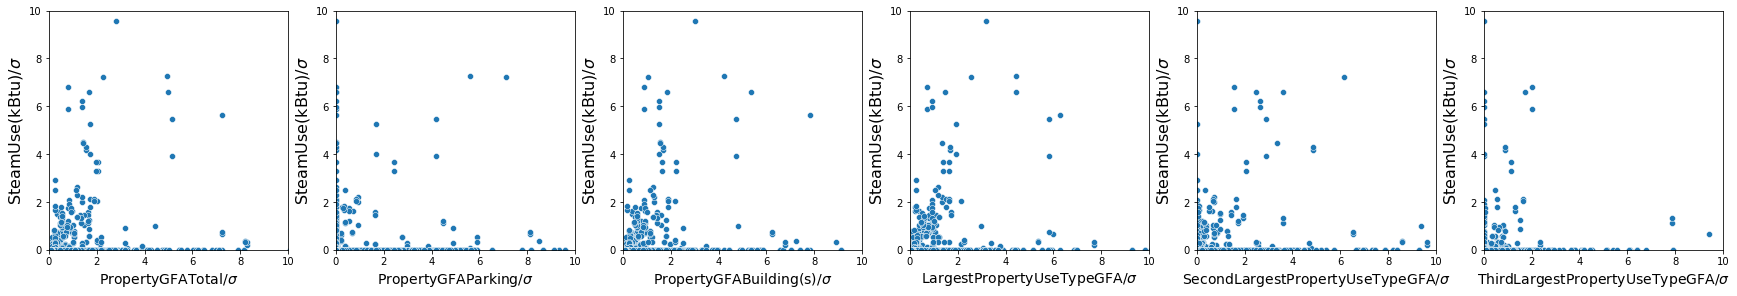

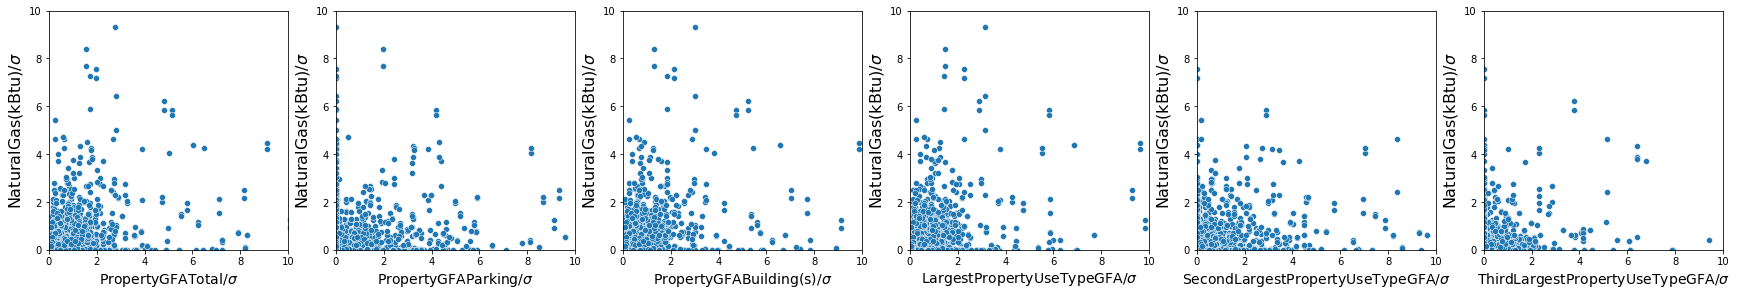

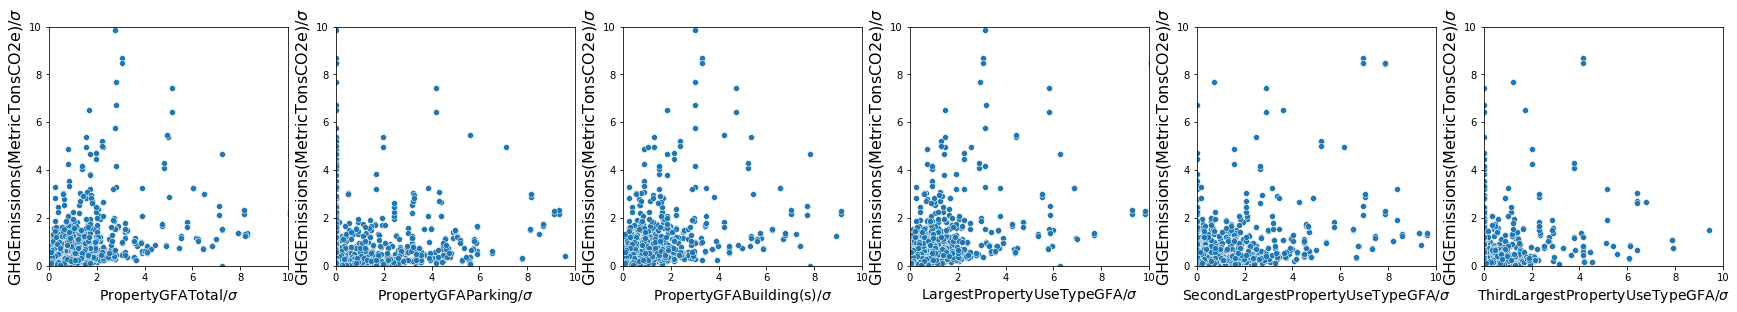

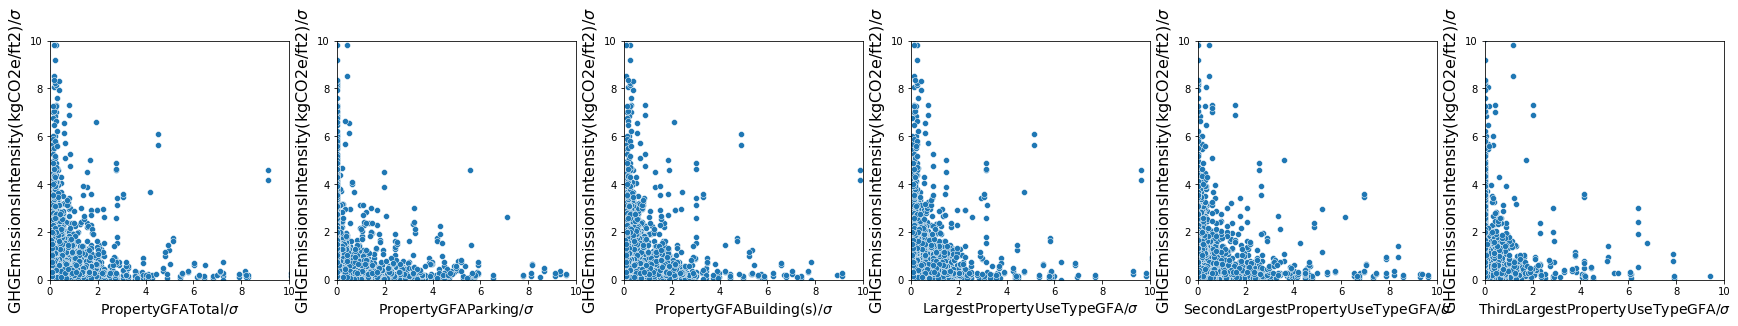

In [65]:
for Y in param_target :
    plt.figure(f'{Y} = f(GFA) - df_fusion - scatterplot', figsize=(30,10)), plt.clf()
    for i, X in zip(range(1,len(param_gfa)+1), param_gfa):
        axe = plt.subplot(1,len(param_gfa),i)
        scaler = StandardScaler(with_mean=False)
        df = pd.DataFrame(scaler.fit_transform(df_fusion[[X,Y]]), columns=[X,Y])#df_fusion[[X,Y]]#
        label = '/$\sigma$'
        axe.set_xlabel(xlabel=X+label, fontsize=14), axe.set_ylabel(ylabel=Y+label, fontsize=16), axe.set_aspect(aspect='equal'), axe.set_xlim([0,10]), axe.set_ylim([0,10])
        sns.scatterplot(data=df, y=Y, x=X)
    if Sauvegarde_figure :
        plt.savefig(abs_path_fig+f'07_Scatterplot_Etiquette{param_target.index(Y)}=f(GFA)_15et16'+'.png')
del i, Y, X, axe, df, scaler

### C'est bien le cas, nous sommes soulagés, même si toutes les surfaces n'ont pas d'influences aussi claires les unes que les autres sur la distribution des paramètres d'énergies.
### On prendra le temps de noter que :
- <i>SiteEnrgyUse</i> semble adopter un comportement +/- linéaire V.a.v des différentes surfaces ;
- au contraire, <i>GHEmissionsIntensity</i> semble être inversement proportionnel aux différentes surfaces.

#### 
### <u>4.3.a(6) Corrélations linéaires, et autres types de relations éventuelles, entre ces partamètres.</u>
### Il est important de noter que, pour un paramètre du vecteur étiquette donné, ses distributions en fonctions des différentes surfaces semblent d'allures similaires. Pourrait-il y avoir de la linéarité entre les différents paramètres surfaciques ? C'est ce qu'on recherche à élucider en affichant ci-dessous la matrice de corrélation linéaire des ces paramètres :

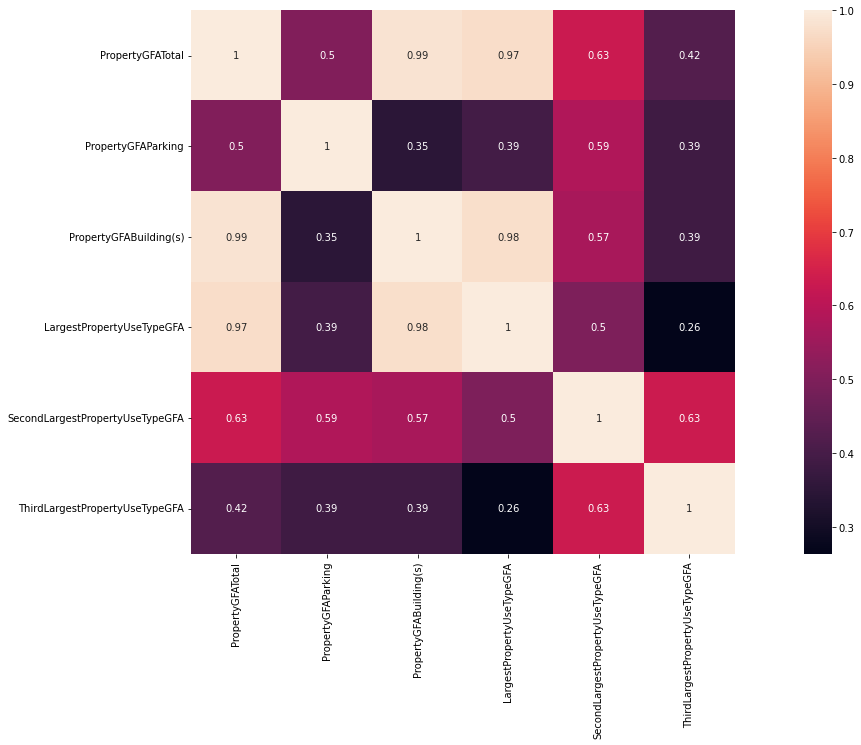

In [66]:
plt.figure('Matrice correlation grandeur - df_fusion', figsize=(25,10)), plt.clf()
sns.heatmap(df_fusion[param_gfa].corr(), cbar=True, square=True, annot=True)
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'07_Mattrice_corr_GFA_15et16'+'.png')

### La matrice de corrélation révèle que ces paramètres sont assez bien corrélés linéairement entre eux (si ce n'est peut être <i>PropertyGFAParking</i>), particulièrement le trio <i>PropertyGFATotal</i>, <i>PropertyGFABuilding(s)</i> et <i>LargestPropertyUseTypeGFA</i>.
### On s'attend donc à pouvoir déceler des relations plus ou moins explicites entre ces différents paramètres. 
### Par exemple : 
### La somme des GFA renseignés pour les parking et les building doit sans doute être inférieure ou égale au GFA total rensigné dans <i>PropertyGFATotal</i>. Vérifions le sur tous les éléments de la b2d :

In [67]:
(df_fusion[param_gfa[1:3]].sum(axis=1) - df_fusion[param_gfa[0]]).value_counts()

0    5955
dtype: int64

### Parfait !

### De même, est-ce que la somme des GFA rensignés pour les 1ères, 2ndes et 3èmes <i>LargestPropertyUseType</i> est bien inféieure ou égale au GFA rensigné pour <i>PropertyGFATotal</i> ?

In [68]:
(df_fusion[param_gfa[0]] - df_fusion[param_gfa[3:]].sum(axis=1)).describe(percentiles=np.linspace(0.1,0.9,9))

count      5955.000000
mean       5628.878808
std       38898.008131
min     -358750.000000
10%       -2381.800000
20%           0.000000
30%           0.000000
40%           0.000000
50%           0.000000
60%           0.000000
70%         877.000000
80%        5120.000000
90%       18371.400000
max      714095.000000
dtype: float64

### Hélas : on a au moins 10% des éléments pour lesquels la somme de ce trois paramètre est supérieure au GFA total, ce qui confirme que les définitions de certaines des <i>LargestPropertyUseType</i> doivent se recouper...
### Néanmoins, au moins 80% des éléments vérifient cette relation, c'est pas si mal.

#### 
### <u>4.3.a(7)Paramètres retenus.</u>
### En conséquence de ces remarques, on décide de se baser sur ces 6 paramètres, même si certains seront plus délicats à manipuler que d'autres.

In [69]:
### Mise à jour du tableau de rangement des paramètres sélectionnés :
for param in ['PropertyGFATotal', 
              'PropertyGFAParking', 
              'PropertyGFABuilding(s)', 
              'LargestPropertyUseTypeGFA', 
              'SecondLargestPropertyUseTypeGFA', 
              'ThirdLargestPropertyUseTypeGFA']:
    if param in tab_param_retenus :
        print(f'{param} déjà retenu.')
    else :
        tab_param_retenus.append(param)
del param

### 
### <u>4.3.b) Analyse quant à l'usage des bâtiments.</u>
#### 
### <u>4.3.b(1) Paramètres concernés.</u>
### On commence par créer la liste de tous les paramètres qui concernent l'usage des bâtiments (en excluant le comptage des surfaces associées)

In [70]:
param_type = df_fusion.columns[['Type' in col for col in df_fusion.columns.values]]
# On exclue le décompte des surfaces associées, c'est à dire les paramètres contenant la mention 'GFA'
param_type = param_type[['GFA' not in col for col in param_type]]
param_type

Index(['BuildingType', 'PrimaryPropertyType', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'SecondLargestPropertyUseType',
       'ThirdLargestPropertyUseType'],
      dtype='object')

#### 
### <u>4.3.b(2) Description statistique des paramètres concernés.</u>
### Puis on affiche une courte description statistique de ces paramètres qualitatifs :

In [71]:
df_fusion[param_type].describe()

BuildingType   PrimaryPropertyType ListOfAllPropertyUseTypes  \
count             5955                  5955                      5820   
unique               7                    32                       465   
top     NonResidential  Low-Rise Multifamily       Multifamily Housing   
freq              2562                  1823                      1584   

       LargestPropertyUseType SecondLargestPropertyUseType  \
count                    5801                         2940   
unique                     56                           48   
top       Multifamily Housing                      Parking   
freq                     2981                         1673   

       ThirdLargestPropertyUseType  
count                         1073  
unique                          45  
top                   Retail Store  
freq                           200

### Outre les grandes disparités de taux de remplissages (qui sont calquées sur celles des paramètres surfaciques correpsondants), on remarque que le nombre de valeurs uniques peut-être très différent d'un paramètre à l'autre, les classant de fait en 3 niveaux de description :
- peu détaillée pour <i>BuildingType</i> ;
- moyennement détaillée pour <i>PrimaryPropertyType</i>, <i>LargestPropertyUseType</i>, <i>SecondLargestPropertyUseType</i> et <i>ThirdLargestPropertyUseType</i> ;
- très détaillée <i>ListOfAllPropertyUseTypes</i>.

#### 
### <u>4.3.b(3) Nettoyage de valeurs prises exprimées sous plusieurs formats.</u>
### On anticipe un peu le résultat suivant, mais certaines valeurs de <i>PrimaryPropertyType</i> sont en réalités identiques, simplement exprimées selon des formats d'écriture différentes.
### Les lignes de codes ci-dessous se chargent de le mettre ne évidence, et de corriger ce léger PB.

In [72]:
 df_fusion['PrimaryPropertyType'].value_counts()

Low-Rise Multifamily           1823
Mid-Rise Multifamily           1010
Small- and Mid-Sized Office     533
Other                           430
Large Office                    319
Mixed Use Property              256
K-12 School                     183
High-Rise Multifamily           178
Warehouse                       170
Non-Refrigerated Warehouse      168
Retail Store                    156
Hotel                           130
Worship Facility                119
Medical Office                   73
Senior Care Community            72
Distribution Center              47
Distribution Center\n            45
Supermarket / Grocery Store      31
Supermarket/Grocery Store        27
Self-Storage Facility            25
Self-Storage Facility\n          23
Refrigerated Warehouse           22
Residence Hall                   20
University                       19
College/University               15
Restaurant                       13
Residence Hall/Dormitory         13
Restaurant\n                

In [73]:
for indx in df_fusion['PrimaryPropertyType'].index :
    element = df_fusion.loc[indx, 'PrimaryPropertyType']
    if element[-1]=='\n' :
        df_fusion.loc[indx, 'PrimaryPropertyType']=element[:-1]
    if ' / ' in element :
        df_fusion.loc[indx, 'PrimaryPropertyType']=element.replace(' / ','/')
df_fusion['PrimaryPropertyType'].value_counts()

Low-Rise Multifamily           1823
Mid-Rise Multifamily           1010
Small- and Mid-Sized Office     533
Other                           430
Large Office                    319
Mixed Use Property              256
K-12 School                     183
High-Rise Multifamily           178
Warehouse                       170
Non-Refrigerated Warehouse      168
Retail Store                    156
Hotel                           130
Worship Facility                119
Distribution Center              92
Medical Office                   73
Senior Care Community            72
Supermarket/Grocery Store        58
Self-Storage Facility            48
Restaurant                       24
Refrigerated Warehouse           22
Residence Hall                   20
University                       19
College/University               15
Residence Hall/Dormitory         13
Hospital                          9
Laboratory                        8
SPS-District K-12                 4
Office                      

#### 
### <u>4.3.b(4) Le type d'usage a t'il une influence sur la consommation d'énergie/la production de CO2 ?</u>
### Bien, il nous faut désormais justifier que le type d'usage influe sur la consammation/production d'énergie des bâtiments.
### EN raison du TRES grand nomnbre de valeurs uniques de ces paramètres, et afin d'économiser de la taille d'écran, on affichera la description statistique de seulment 2 paramètres du vecteur étiquette (<i>SiteEnergyUse</i> et <i>GHGEmissionsIntensity</i>, qui ont un faible coefficent de corrélation linéaire), en fonction de l'usage des bâtiment pour seulement deux paramètres de type d'usage (<i>BuildingType</i> et <i>PrimaryPropertyType</i>, pour avoir deux niveaux de description différents) :

In [74]:
decrire(liste_annee=['Sur 2015 et 2016'], 
        liste_df=[df_fusion], 
        liste_param=['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)'], 
        liste_categ=['BuildingType', 'PrimaryPropertyType'])

Sur 2015 et 2016 :
SiteEnergyUse(kBtu) :
        BuildingType       count        mean         std         min         25%         50%         75%         max
              Campus          35    5.94e+07    1.49e+08    1.56e+06    3.54e+06    1.49e+07    5.29e+07    8.74e+08
Multifamily HR (10+)         185    9.05e+06    7.73e+06    1.15e+06    4.27e+06    6.77e+06    1.14e+07    5.91e+07
Multifamily LR (1-4)        1873    1.30e+06    1.06e+06           0    6.79e+05    9.49e+05    1.51e+06    1.25e+07
Multifamily MR (5-9)        1040    2.77e+06    2.48e+06    3.92e+05    1.17e+06    1.97e+06    3.41e+06    1.92e+07
      NonResidential        2559    7.25e+06    1.73e+07           0    1.15e+06    2.47e+06    6.75e+06    2.92e+08
  Nonresidential COS         124    6.33e+06    9.25e+06    3.88e+05    1.71e+06    2.85e+06    8.41e+06    6.47e+07
   SPS-District K-12         130    3.81e+06    3.72e+06           0    1.80e+06    2.24e+06    4.73e+06    2.11e+07

GHGEmissionsIntensity(

### C'est mitigé : quelques soit le niveau de description, seuls quelques classes de bâtiments se démarquent des autres. C'est particulièrement vrai pour <i>SiteEnergyUse</i>, les résultats sont meilleurs malgré tout pour <i>GHGEmissionsIntensity</i>.
### De plus, toutes ces valeurs n'ont pas forcément le même poids, du fait des grandes disparités du nombre de représentation.
### L'affichage graphique sous forme de nuage de points nous aidera t'il ? On affiche la position de chaque bâtiment dasn un repère (<i>SiteEnergyUse</i>, <i>GHGEmissionsIntensity</i>), avec -de nouveau- normalisation de l'écart-type, pour les deux niveau de description précédents :

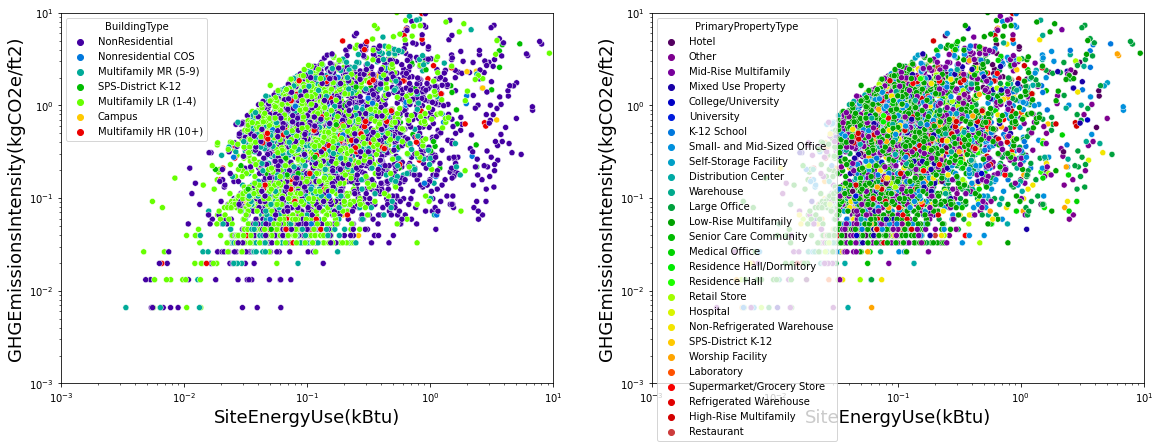

In [75]:
plt.figure('Qlqs energies = f(Typpe usage) - df_fusion - scatterplot', figsize=(30,15)), plt.clf()
for i, Hue in zip(range(1,3), ['BuildingType', 'PrimaryPropertyType']) :
    axe = plt.subplot(2,3,i)
    df, X, Y = df_fusion[['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)', Hue]], 'SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)'
    scaler = StandardScaler(with_mean=False)
    df_plot = pd.DataFrame(scaler.fit_transform(df[[X,Y]]), columns=[X,Y])#df#
    df_plot[Hue] = df[Hue]
    axe.set_xscale('log'), axe.set_yscale('log')
    axe.set_xlabel(xlabel=axe.get_xlabel(), fontsize=18), axe.set_ylabel(ylabel=axe.get_ylabel(), fontsize=18)
    axe.set_xlim([1e-3, 1e1]), axe.set_ylim([1e-3, 1e1])#axe.set_xlim([0,10]), axe.set_ylim([0,10])
    sns.scatterplot(data=df_plot.where(np.logical_and(df[X]>0, df[Y]>0)), x=X, y=Y, hue=Hue, ax=axe, palette="nipy_spectral")#
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+f'08_GHE=f(SEU_Buildingtype)_15et16'+'.png')
del i, df, df_plot, X, Y, Hue, axe

### De nouveau, c'est mitigé, et les différences de nombre de représentations n'aident pas.
### Affichons plutôt les distributions individuelles des paramètres d'énergies restreintes à chaque type d'usage :

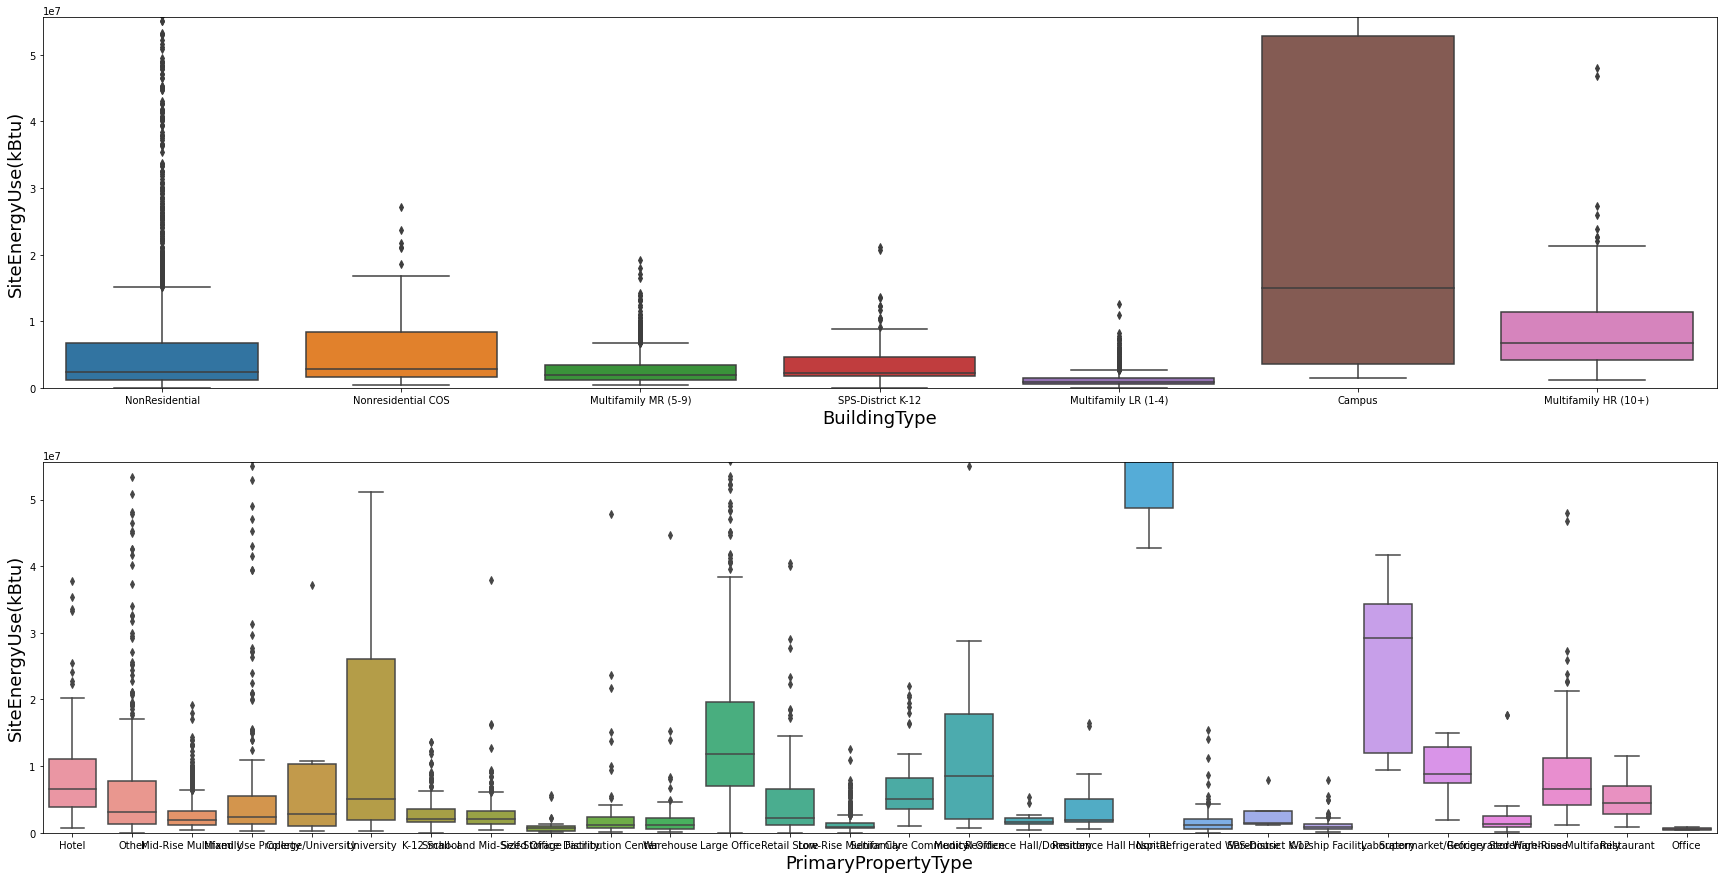

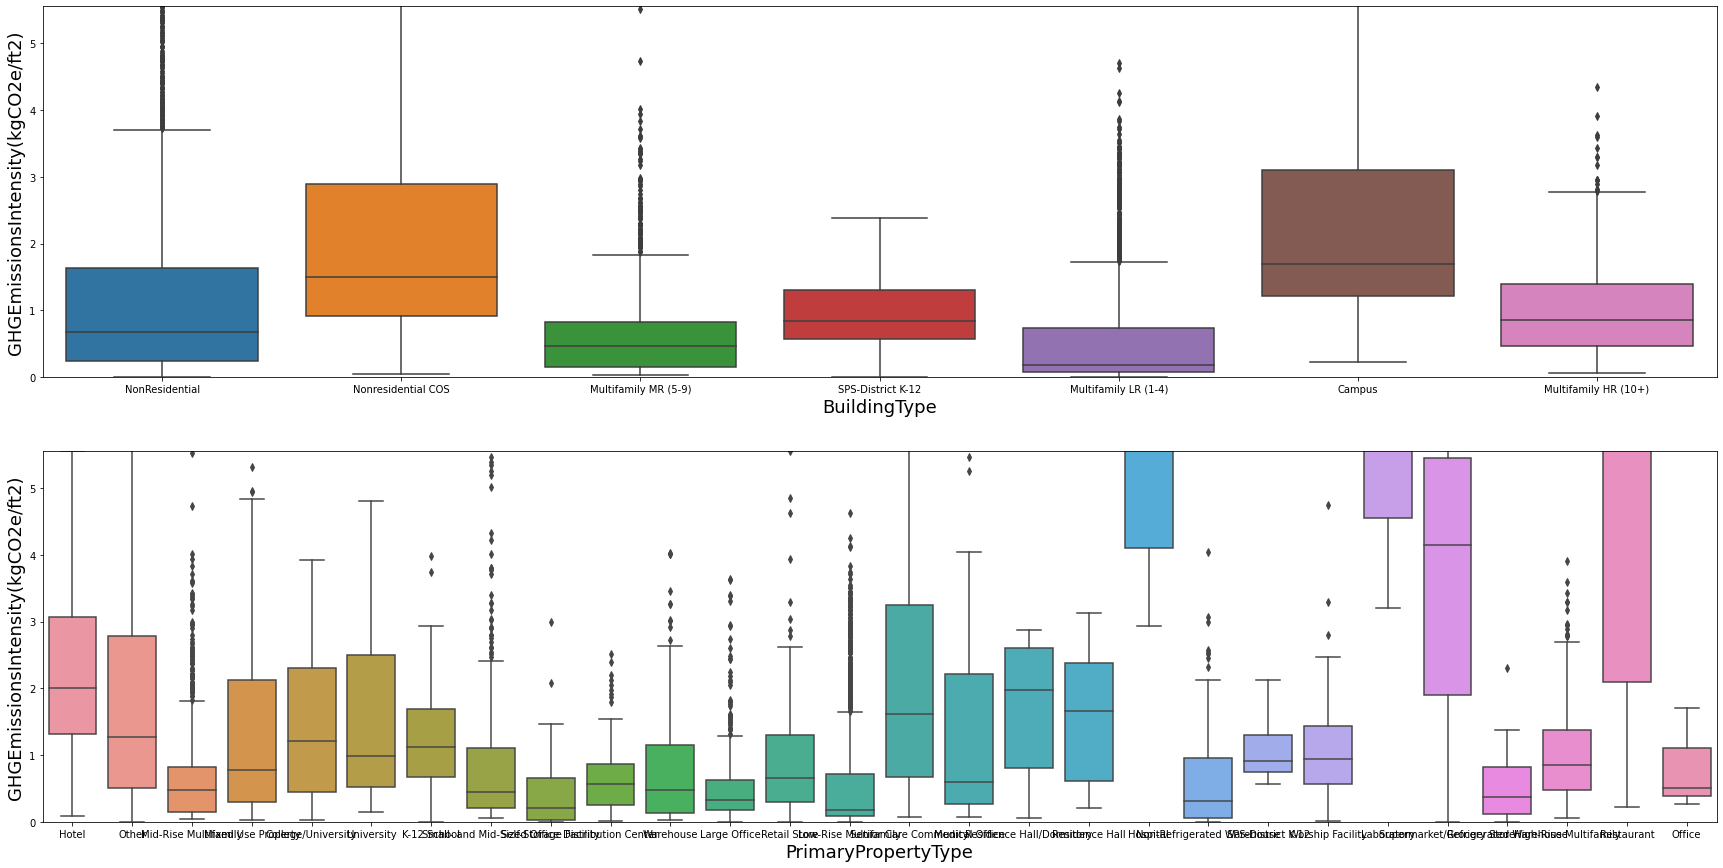

In [76]:
tab = ['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)']
for X in tab :
    plt.figure(X+' = f(Type Usage) - df_fusion - violinplot', figsize=(30,15)), plt.clf()
    for i, Y in zip([1,2], ['BuildingType', 'PrimaryPropertyType']):
        axe = plt.subplot(2,1,i)
        #scaler = StandardScaler(with_mean=False)
        df =  df_fusion[[X, Y]]#pd.DataFrame(scaler.fit_transform(df_fusion[X]), columns=X)#.where(df_fusion[Y]>0)
        #df[Y] = df_fusion[Y]
        axe.set_xlabel(xlabel=axe.get_xlabel(), fontsize=18), axe.set_ylabel(ylabel=axe.get_ylabel(), fontsize=18)
        axe.set_ylim([0, df[X].mean()+3*df[X].std()])
        sns.boxplot(data=df, x=Y, y=X)#, scale='width')
    if Sauvegarde_figure :
        plt.savefig(abs_path_fig+f'09_Boxplot_Energie_{tab.index(X)}=f(UseType)_15et16'+'.png')
    del i, Y, axe, df, X

### C'est mieux ! Même pour le faible niveau de détails, les types d'usage font des représentations différentes. Cependant, on n'a toujours pas une distribution distincte et "unique" par type d'usage, particulièrement pour <i>SiteEnergyUse</i>.
### Cela veut donc dire que le type d'usage a bien une influence sur la consommation/production d'énergie, avec des différence de netteté selon le paramètre de consommation/production considéré.

### On peut de fait conserver tous les paramètres de niveau faible à intermédiaire de description.
### POur le paramètre <i>ListOfAllPropertyUseTypes</i>, il nous faut d'abord lui faire modifier son format afin de pouvoir le confronter à nos étiquettes.

#### 
### <u>4.3.b(5) Modification du format de <i>ListOfAllPropertyUseTypes</i></u>
### On a dejà montré que la classification peu détaillée de <i>BuildingType</i> permettait d'induire des différences de distributions au sein de paramètres du vecteur étiquette, bien que non optimales. Pour ce qui est de <i>ListOfAllPropertyUseTypes</i>, on aimerait produire une démarche similaire, mais le format de l'information contenue par ce paramètre ne nous y aide pas --> Essayons donc d'extraire tous les type d'usage (<i>UseType</i>) possible de <i>ListOfAllPropertyUseTypes</i>, afin de voir si il n'y a pas moyen de simplifier ce paramètre.

In [77]:
tab_aPUT = [] 
for element in df_fusion['ListOfAllPropertyUseTypes'].dropna(axis=0).values :
    if ', ' in element :
        valeurs = []
        if '(' in element :
            # On sépare l'élement en 3 groupes selon les parenthèse
            groupes = re.split(pattern='\(|\)', string=element)
            # On sépare le 1er groupe selon les virgules
            grp_0 = re.split(pattern=', ', string=groupes[0])
            # On reconstitue le UseType initial qui contenenait des parenthèse
            terme_parenthese = grp_0[-1]+'('+groupes[1]+')'
            # On sépare le 3er groupe selon les virgules !!! Attention, le premier terme est de fait nécessairement = à ''
            grp_2 = re.split(pattern=', ', string=groupes[2])
            ###On ajoute les différents UseTypes ainsi reconstitués dans la liste valeurs
            # 1er groupe
            for grp in grp_0[:-1] :
                valeurs.append(grp)
            valeurs.append(terme_parenthese)
            if len(grp_2)>1:
                for grp in grp_2[1:]:
                    valeurs.append(grp)
        else :
            valeurs = element.split(', ')
        for val in valeurs :
            tab_aPUT.append(val)
    else :
        tab_aPUT.append(element)
tab_aPUT = np.array(tab_aPUT)
del element, valeurs, val, groupes, grp, grp_0, grp_2, terme_parenthese

### On affiche les types d'usages obtenus :

In [78]:
np.sort(pd.Series(tab_aPUT).value_counts().keys()), len (np.sort(pd.Series(tab_aPUT).value_counts().keys()))

(array(['Adult Education', 'Automobile Dealership', 'Bank Branch',
        'Bar/Nightclub', 'College/University',
        'Convenience Store without Gas Station', 'Convention Center',
        'Courthouse', 'Data Center', 'Distribution Center',
        'Enclosed Mall', 'Fast Food Restaurant', 'Financial Office',
        'Fitness Center/Health Club/Gym', 'Food Sales', 'Food Service',
        'Hospital (General Medical & Surgical)', 'Hotel', 'K-12 School',
        'Laboratory', 'Library', 'Lifestyle Center',
        'Manufacturing/Industrial Plant', 'Medical Office',
        'Movie Theater', 'Multifamily Housing', 'Museum',
        'Non-Refrigerated Warehouse', 'Office', 'Other',
        'Other - Education', 'Other - Entertainment/Public Assembly',
        'Other - Lodging/Residential', 'Other - Mall',
        'Other - Public Services', 'Other - Recreation',
        'Other - Restaurant/Bar', 'Other - Services',
        'Other - Technology/Science', 'Other - Utility',
        'Other/Specia

### C'est bien mieux ! Il y a en réalité 66 type d'usages de bâtiments, et non 484. On notera que certaines catégories d'usage ont l'air d'être redondantes par rapport à d'autres (par exemple : <i>Other - Restaurant/Bar</i> vis à vis de <i>Restaurant</i> et <i>Bar/Nightclub</i>, etc), mais on ne simplifiera pas davantage de peur de corrompre le jeu de données.

### Ce nombre de catégorie étant beaucoup plus gérable, on décide de modifier le format de <i>ListOfAllPropertyUseTypes</i>, qui contiendra une liste de tous les usages concernant le bâtiment de la ligne correspondante, et non plus une seule châine de caractères

In [79]:
### Initialisation
# Liste de tous les types précis d'usage des bâtiments :
liste_tous_usages = np.sort(pd.Series(tab_aPUT).value_counts().keys())
# Initialisation du tableau qui constituera le nouveau paramètre
nouvelle_colonne = []
### On parcours l'ensemble des éléments de la b2d pour crée une liste de 68 booléens adaptée aux informations contenues dans 'ListOfAllPropertyUseTypes'
for indx in df_fusion.index :
    # Initialisation de la liste d'usages
    tab_usages = []
    # Si jamais c'est une NaN
    if df_fusion['ListOfAllPropertyUseTypes'].isna().loc[indx]:
        tab_usages.append(np.nan)
    # Si la valeur de l'élément pour 'ListOfAllPropertyUseTypes' est bien définie
    else :
        # On parcours la liste des usage répertoriée dans 'ListOfAllPropertyUseTypes' pour l'élément correspondant
        for usage in liste_tous_usages :
            #tab_usages.append(1 if usage in df_fusion.loc[indx, 'ListOfAllPropertyUseTypes'] else 0)
            if usage in df_fusion.loc[indx, 'ListOfAllPropertyUseTypes'] :
                tab_usages.append(usage)
        # On s'assure d'une cohérence supplémentaire : si la taille de parking est renseignée (>0), alors 'Parking' doit être renseigné dans la liste des usages
        if np.logical_and(df_fusion.loc[indx, 'PropertyGFAParking'] > 0, 'Parking' not in tab_usages) :
            #tab_usages[np.argwhere(liste_tous_usages=='Parking')[0,0]] = 'Parking'
            tab_usages.append('Parking')
    nouvelle_colonne.append(tab_usages)
### On transforme la liste en tableau
nouvelle_colonne = np.array(nouvelle_colonne)
del indx, tab_usages, usage
### AFfichage
nouvelle_colonne

array([list(['Hotel']), list(['Hotel']),
       list(['Hotel', 'Parking', 'Restaurant']), ...,
       list(['Fitness Center/Health Club/Gym', 'Other', 'Other - Recreation', 'Swimming Pool']),
       list(['Fitness Center/Health Club/Gym', 'Food Service', 'Office', 'Other', 'Other - Recreation', 'Pre-school/Daycare']),
       list(['Fitness Center/Health Club/Gym', 'Food Service', 'Office', 'Other', 'Other - Recreation', 'Pre-school/Daycare'])],
      dtype=object)

### On remplace les valeurs prises par <i>ListOfAllPropertyUseTypes</i> par celles de ce tableau :

In [80]:
df_fusion['ListOfAllPropertyUseTypes'] = pd.Series(nouvelle_colonne)
df_fusion['ListOfAllPropertyUseTypes']

0                               [Hotel]
1                               [Hotel]
2          [Hotel, Parking, Restaurant]
3          [Hotel, Parking, Restaurant]
4       [Hotel, Parking, Swimming Pool]
                     ...               
6711                                NaN
6712                                NaN
6713                                NaN
6714                                NaN
6715                                NaN
Name: ListOfAllPropertyUseTypes, Length: 5955, dtype: object

### Au passage, on a retrouvé toutes les classes déjà présentes au sein de <i>LargestPropertyUseType</i>. Les classes supplémentaires sont affichées ci-dessous :

In [81]:
np.setdiff1d(liste_tous_usages, np.sort(df_fusion['LargestPropertyUseType'].value_counts().keys()))

array(['Bar/Nightclub', 'Convenience Store without Gas Station',
       'Enclosed Mall', 'Fast Food Restaurant', 'Food Sales',
       'Other - Technology/Science', 'Single Family Home',
       'Swimming Pool', 'Vocat', 'Vocational School'], dtype=object)

#### 
### <u>4.3.b(6) Vérification que ces classes ont également une influence sur la consommation d'énergie/la production de CO2 des bâtiments.</u>
### On va donc se baser sur les classes de ce dernier paramètre pour avoir une idée plutôt fidèle de la description statistique de <i>SiteEnergyUse(kBtu)</i> et <i>GHGEmissions(MetricTonsCO2e)</i> en fonction des différentes catégories d'usage de bâtiment de <i>LargestPropertyUseType</i> (à l'image de ce qu'on avait déjà fait au début de cette section) :

In [82]:
decrire(liste_annee=['Sur 2015 et 2016'], liste_df=[df_fusion], liste_param=['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)'], liste_categ=['LargestPropertyUseType'])

Sur 2015 et 2016 :
SiteEnergyUse(kBtu) :
LargestPropertyUseType       count        mean         std         min         25%         50%         75%         max
     Adult Education           4    2.24e+06    9.96e+05    1.29e+06    1.42e+06    2.28e+06    3.09e+06    3.11e+06
Automobile Dealershi          11    2.03e+06    1.13e+06    5.44e+05    1.35e+06    1.92e+06    2.56e+06    4.29e+06
         Bank Branch           8    1.39e+06    1.89e+05    1.10e+06    1.29e+06    1.43e+06    1.49e+06    1.64e+06
  College/University          33    4.49e+07    1.52e+08    3.15e+05    1.36e+06    4.12e+06    1.64e+07    8.74e+08
   Convention Center           2    3.86e+07    5.46e+07           0    1.93e+07    3.86e+07    5.79e+07    7.72e+07
          Courthouse           2    4.92e+07    5.90e+06    4.50e+07    4.71e+07    4.92e+07    5.12e+07    5.33e+07
         Data Center           5    1.33e+08    1.34e+08    3.00e+07    3.26e+07    4.17e+07    2.75e+08    2.85e+08
 Distribution Center 

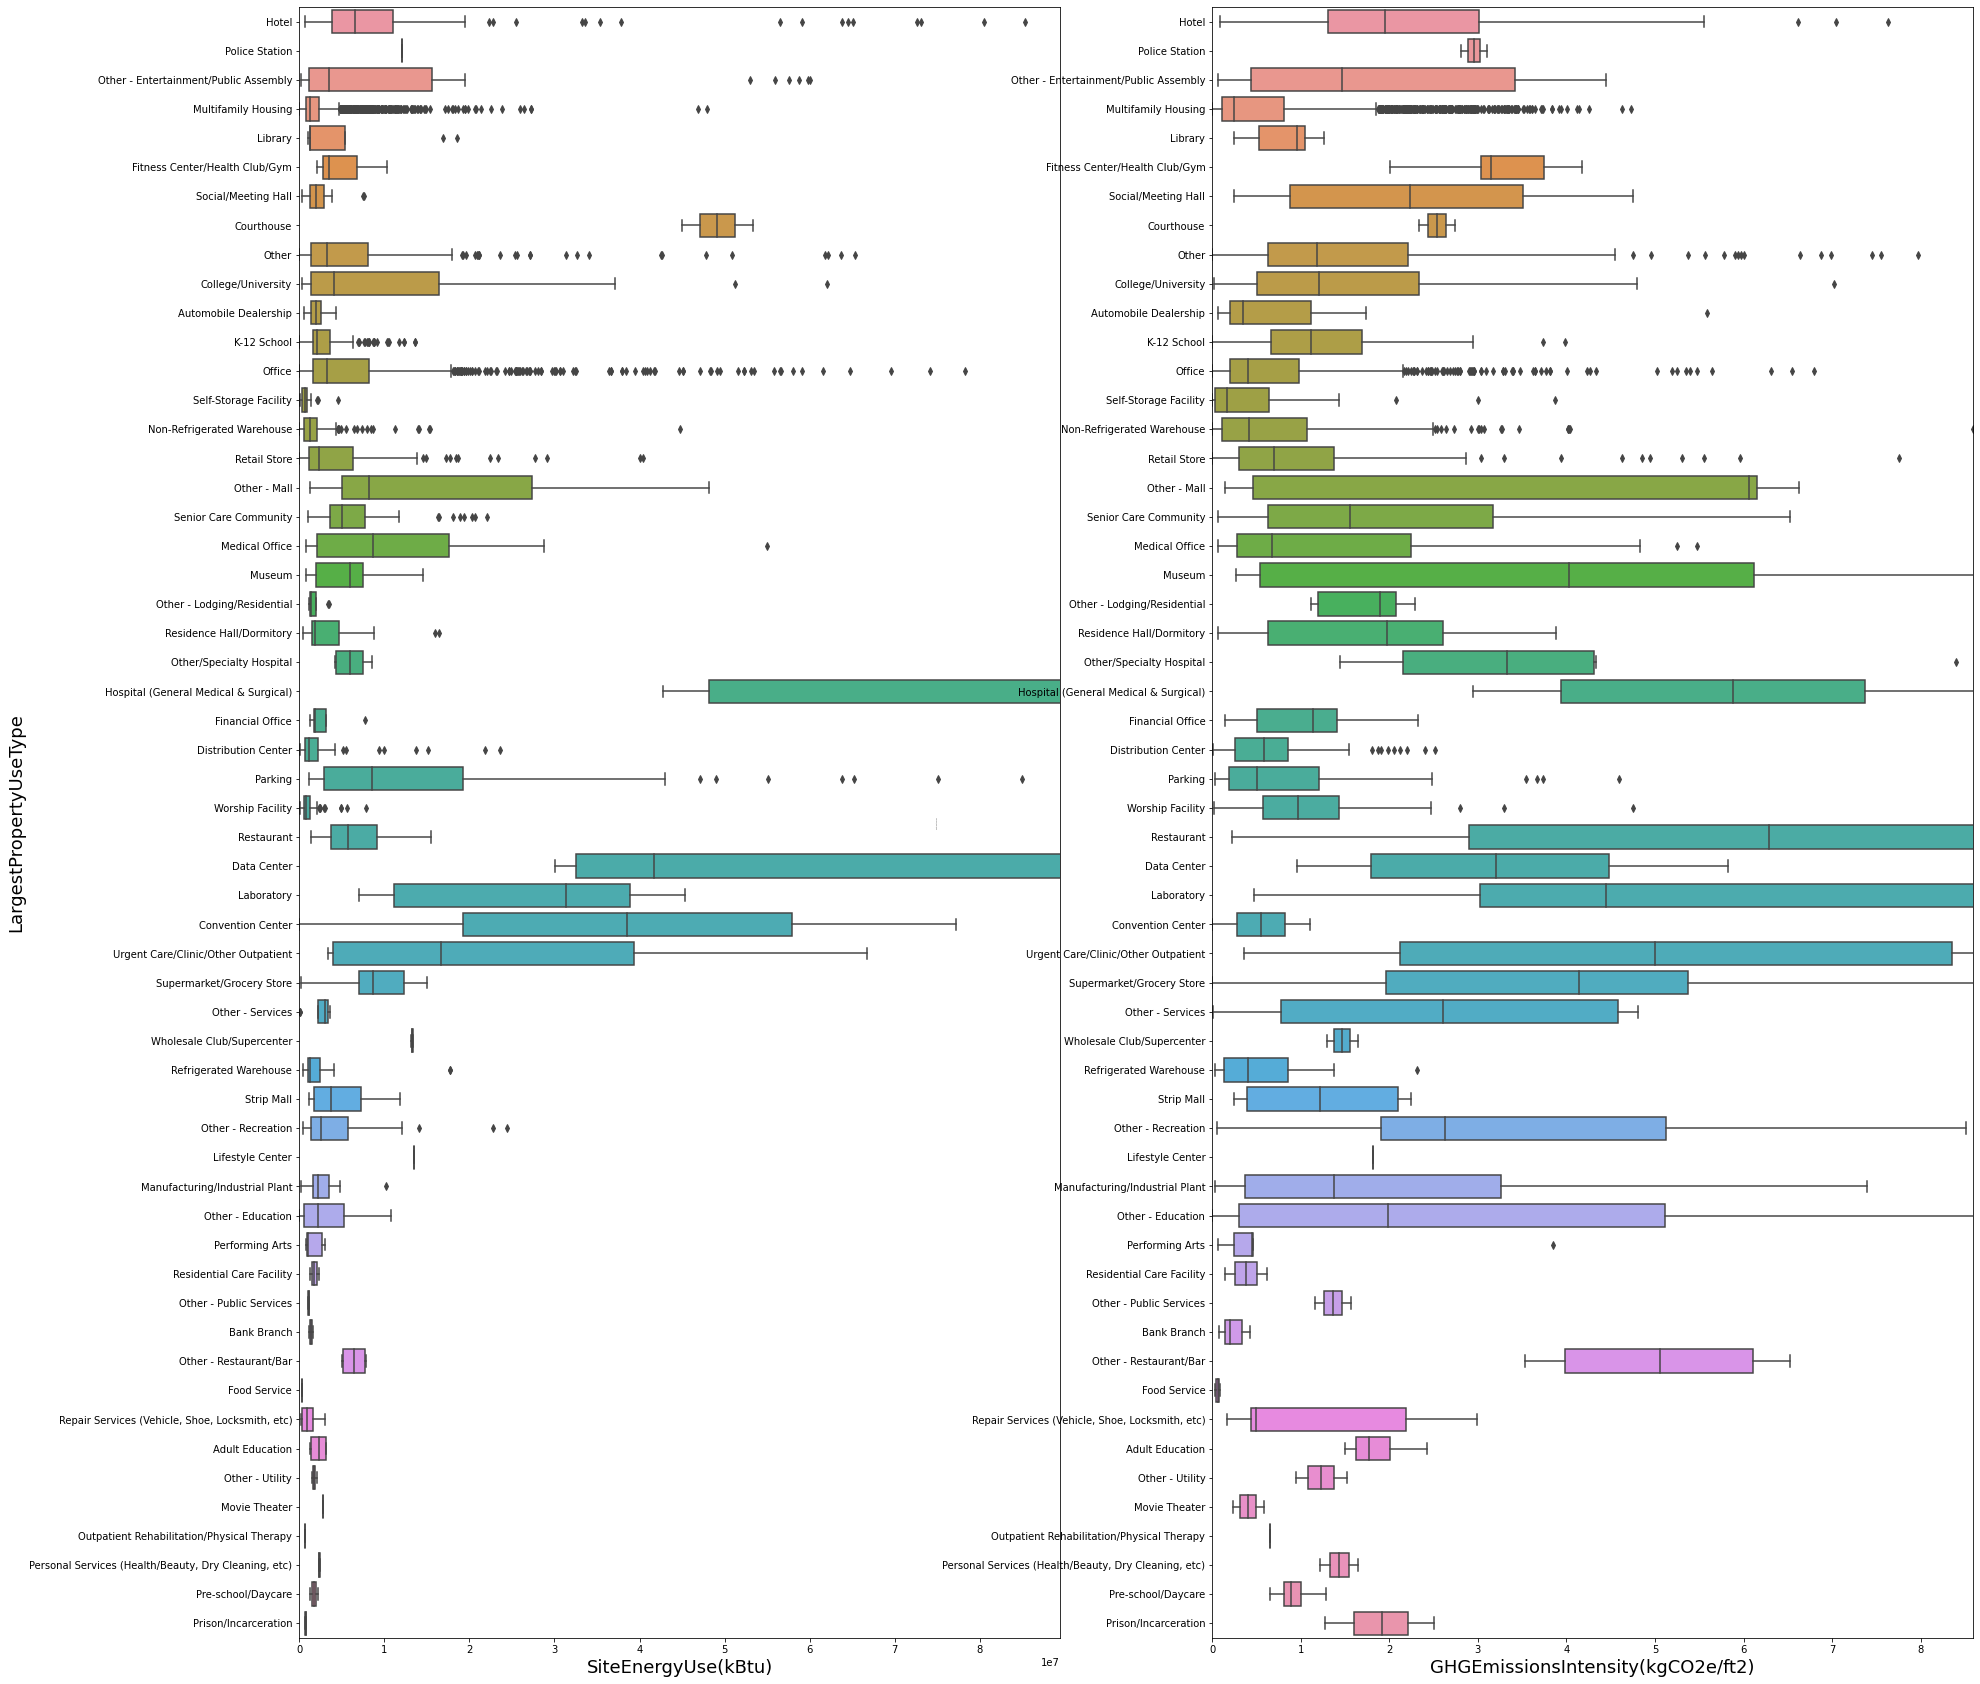

In [83]:
for Y in ['LargestPropertyUseType'] :
    plt.figure('Qlqs energies = f(LargestPropertyUseType) - df_fusion - boxplot', figsize=(30,30)), plt.clf()
    for i, X in zip([1,2], ['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)']):
        axe = plt.subplot(1,2,i)
        df =  df_fusion[[X, Y]]
        if i==1 :
            axe.set_xlabel(xlabel=axe.get_xlabel(), fontsize=18), axe.set_ylabel(ylabel=axe.get_ylabel(), fontsize=18)
        else :
            axe.set_xlabel(xlabel=axe.get_xlabel(), fontsize=18), axe.set_ylabel(ylabel='', fontsize=0)
        axe.set_xlim([0, df[X].mean()+5*df[X].std()])
        sns.boxplot(data=df, x=X, y=Y)
    if Sauvegarde_figure :
        plt.savefig(abs_path_fig+'10_Boxplot_GHE_SEU=f(LargestUseType)_15et16'+'.png')
    del i, Y, axe, df, X

### On vient donc de prouver que ce niveau de description permettait des différences de distributions de paramètre du vecteur étiquette selon le type d'usage considéré.
### !!!
### <u>CHOIX IMPORTANT</u>
### On décide donc de retenir ces 6 paramètres. En effet, ilspermettent des catégorisation d'usage de bâtiments à plusieurs niveaux de précision différents, et certains d'entre eux permettent en plus de celà de conserver une information de hiérarchie des usage.
### !!!

In [84]:
### Mise à jour du tableau de rangement des paramètres sélectionnés :
for param in param_type:
    if param in tab_param_retenus :
        print(f'{param} déjà retenu.')
    else :
        tab_param_retenus.append(param)
del param

### 
### <u>4.3.c) Analayse quant aux mentions de travaux récents.</u>
### Ces informations ont disparu lorsqu'on a laissé de côté le paramètre <i>Comment</i>.

### 
### <u>4.3.d) Analayse quant aux dates de constructions.</u>

In [85]:
param_dates = df_fusion.columns[['Year' in col for col in df_fusion.columns.values]]
param_dates

Index(['DataYear', 'YearBuilt'], dtype='object')

In [86]:
param_dates = param_dates[-1]
param_dates

'YearBuilt'

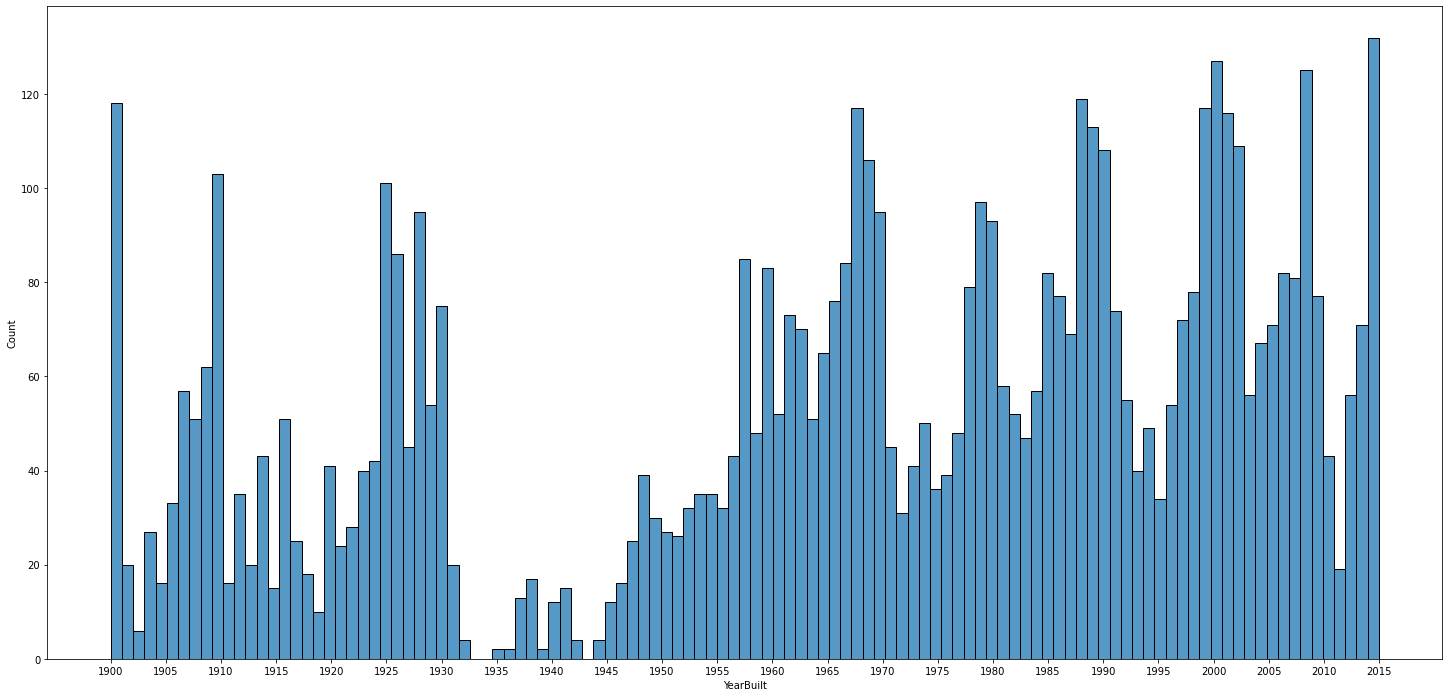

In [87]:
plt.figure('Distribution de YearBuilt', figsize=(25,12)), plt.clf()
plt.xticks(ticks=np.linspace(1900,2015,115/5+1))
sns.histplot(df_fusion, x='YearBuilt', bins=len(df_fusion['YearBuilt'].unique()))
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'11_Histplot_Yearbuilt_15et16'+'.png')

In [88]:
df_fusion[param_dates].describe(percentiles=np.linspace(0.1, 0.9, 9))

count    5955.000000
mean     1968.049034
std        33.111622
min      1900.000000
10%      1914.000000
20%      1928.000000
30%      1956.000000
40%      1966.000000
50%      1975.000000
60%      1984.000000
70%      1991.000000
80%      2000.000000
90%      2007.000000
max      2015.000000
Name: YearBuilt, dtype: float64

In [89]:
df_fusion['CategYearBuilt'] = pd.qcut(df_15['YearBuilt'], q=9)
#df_fusion[['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'CategYearBuilt']].groupby('CategYearBuilt').describe()
df_fusion[list(np.concatenate((param_target, ['CategYearBuilt'])))].groupby('CategYearBuilt').describe(percentiles=[])
#df_fusion.drop(columns=['CategYearBuilt'], inplace=True)

SiteEUI(kBtu/sf)                                        \
                              count       mean        std  min        50%   
CategYearBuilt                                                              
(1899.999, 1916.0]            337.0  56.024629  51.424907  1.0  44.299999   
(1916.0, 1930.0]              331.0  66.729607  75.349909  0.0  46.800000   
(1930.0, 1960.0]              338.0  62.489645  57.281011  0.0  45.250000   
(1960.0, 1968.0]              298.0  56.577517  63.087934  5.9  40.200000   
(1968.0, 1979.0]              334.0  60.841018  64.813914  2.1  45.050000   
(1979.0, 1989.0]              391.0  57.330946  53.674220  0.0  44.700001   
(1989.0, 1998.0]              284.0  59.920423  57.824591  3.0  44.550000   
(1998.0, 2005.0]              315.0  58.890793  53.459745  0.0  43.200001   
(2005.0, 2015.0]              322.0  47.920497  39.266294  0.0  36.250000   

                               SiteEnergyUse(kBtu)                \
                           max               count          mean   
CategYearBuilt                                                     
(1899.999, 1916.0]  663.400000               338.0  8.592728e+06   
(1916.0, 1930.0]    834.400024               331.0  5.971774e+06   
(1930.0, 1960.0]    465.500000               339.0  6.701151e+06   
(1960.0, 1968.0]    800.600000               298.0  5.767159e+06   
(1968.0, 1979.0]    707.299988               334.0  6.536772e+06   
(1979.0, 1989.0]    618.700000               391.0  6.516805e+06   
(1989.0, 1998.0]    639.700012               284.0  7.306096e+06   
(1998.0, 2005.0]    313.600000               315.0  8.178233e+06   
(2005.0, 2015.0]    349.100006               322.0  4.769482e+06   

                                                ...  \
                             std           min  ...   
CategYearBuilt                                  ...   
(1899.999, 1916.0]  2.847402e+07       0.00000  ...   
(1916.0, 1930.0]    8.329503e+06       0.00000  ...   
(1930.0, 1960.0]    1.254074e+07       0.00000  ...   
(1960.0, 1968.0]    1.164666e+07  117438.39840  ...   
(1968.0, 1979.0]    1.268083e+07  116486.60160  ...   
(1979.0, 1989.0]    1.591968e+07       0.00000  ...   
(1989.0, 1998.0]    1.931823e+07   90558.70313  ...   
(1998.0, 2005.0]    2.006494e+07       0.00000  ...   
(2005.0, 2015.0]    9.465166e+06       0.00000  ...   

                   GHGEmissions(MetricTonsCO2e)                          \
                                            std   min     50%       max   
CategYearBuilt                                                            
(1899.999, 1916.0]                   942.670073  0.00  43.355  12307.16   
(1916.0, 1930.0]                     194.480106  0.00  49.550   1623.34   
(1930.0, 1960.0]                     309.755474  0.00  47.010   4045.53   
(1960.0, 1968.0]                     255.887483  0.00  39.005   3243.48   
(1968.0, 1979.0]                     282.944501  0.81  46.310   3232.23   
(1979.0, 1989.0]                     476.248051  0.00  47.320   8145.52   
(1989.0, 1998.0]                     295.554672  0.63  49.010   2573.75   
(1998.0, 2005.0]                     572.493692  0.00  43.980   8046.70   
(2005.0, 2015.0]                     158.364484  0.40  26.325   1793.90   

                   GHGEmissionsIntensity(kgCO2e/ft2)                      \
                                               count      mean       std   
CategYearBuilt                                                             
(1899.999, 1916.0]                             338.0  0.948432  1.168914   
(1916.0, 1930.0]                               331.0  1.229124  2.038844   
(1930.0, 1960.0]                               339.0  1.099764  1.536889   
(1960.0, 1968.0]                               298.0  0.959463  1.215015   
(1968.0, 1979.0]                               334.0  1.050868  1.453538   
(1979.0, 1989.0]                               391.0  1.095780  1.673288   
(1989.0, 1998.0]               

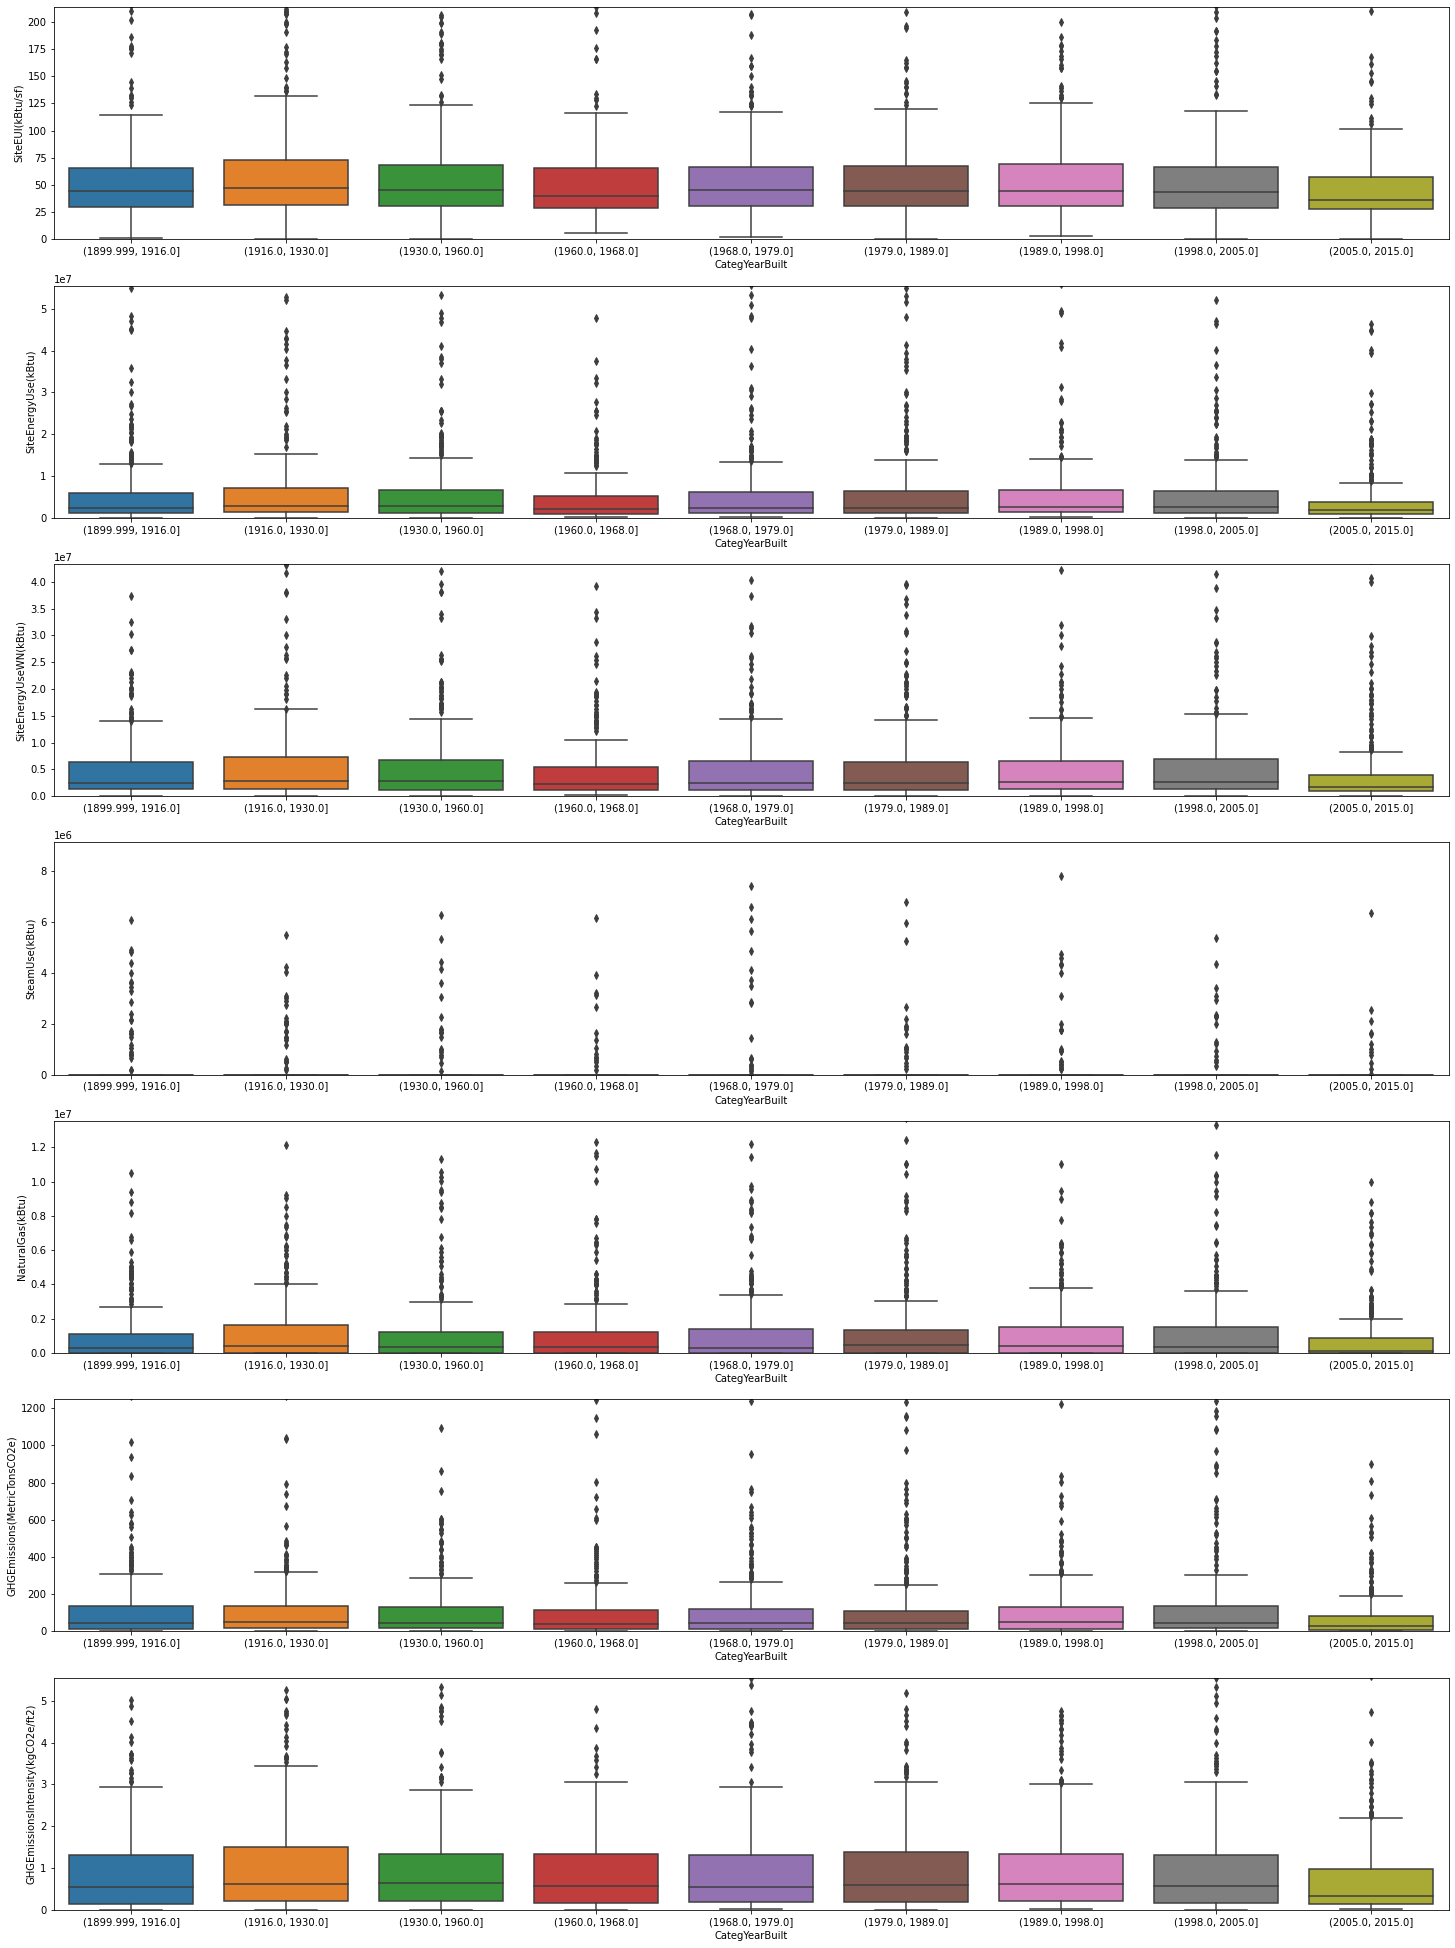

In [90]:
plt.figure('qsrvjaer', figsize=(25,5*len(param_target))), plt.clf()
X = 'CategYearBuilt'
#scaler = StandardScaler(with_mean=False)
df_plot = df_fusion#pd.DataFrame(scaler.fit_transform(df_fusion[param_target]), columns=[param_target])#
#df_plot[X] = df_fusion[X]
for i, Y in zip(range(1,len(param_target)+1), param_target) :
    axe = plt.subplot(len(param_target),1,i)
    axe.set_ylim([0, df_plot[Y].mean()+3*df_plot[Y].std()])
    sns.boxplot(data=df_plot, y=Y, x=X, ax=axe)
    if Sauvegarde_figure :
        plt.savefig(abs_path_fig+'12_Boxplot_Etiquettes=f(Yearbuilt_cat)_15et16'+'.png')
df_fusion.drop(columns=['CategYearBuilt'], inplace=True)

### RESULTAT COMPLETEMENT CONTRE INTUITIF /
### Il semblerait que les distributions des différents paramètres du vecteur étiquette soient insensibles à la différenciations par groupes d'années de construction !
### Essayons de ne plus découper les années en catégories, afin de vérifier si ce résultat est conservé :

In [91]:
#df_fusion[['SiteEnergyUse(kBtu)', 'GHGEmissionsIntensity(kgCO2e/ft2)', 'YearBuilt']].groupby('YearBuilt').describe(percentiles=[])
df_fusion[list(np.concatenate((param_target, ['YearBuilt'])))].groupby('YearBuilt').describe(percentiles=[])


SiteEUI(kBtu/sf)                                               \
                     count       mean         std        min        50%   
YearBuilt                                                                 
1900                 103.0  57.260194   46.792059   1.000000  44.800000   
1901                  15.0  53.660000   17.966191  27.100000  54.600000   
1902                  20.0  80.920000  128.414808  14.300000  36.650000   
1903                   6.0  50.633333   20.723480  26.900000  43.100000   
1904                  27.0  48.574074   25.806716   9.200000  52.700001   
...                    ...        ...         ...        ...        ...   
2011                  19.0  54.000000   59.215567  24.000000  33.700000   
2012                  56.0  61.698214  101.984609  23.400000  37.850000   
2013                  71.0  56.512676   56.374385  16.299999  34.700000   
2014                 102.0  36.612745   12.434523   9.700000  33.550000   
2015                  30.0  40.043333   23.403193  16.600000  35.400000   

                      SiteEnergyUse(kBtu)                              \
                  max               count          mean           std   
YearBuilt                                                               
1900       263.200012               103.0  1.107655e+07  8.588868e+07   
1901        94.400002                15.0  1.985755e+06  1.190452e+06   
1902       456.600006                20.0  2.371879e+06  2.510932e+06   
1903        81.599998                 6.0  1.285710e+06  5.870839e+05   
1904       104.599998                27.0  3.997218e+06  3.685896e+06   
...               ...                 ...           ...           ...   
2011       222.700000                19.0  5.060998e+06  3.904595e+06   
2012       593.599976                56.0  6.636284e+06  9.266964e+06   
2013       261.900000                71.0  6.336029e+06  1.083287e+07   
2014        78.400002               102.0  4.445639e+06  4.735006e+06   
2015       144.500000                30.0  6.524183e+06  8.160488e+06   

                         ... GHGEmissions(MetricTonsCO2e)                \
                    min  ...                          std   min     50%   
YearBuilt                ...                                              
1900       2.412600e+04  ...                  1095.909346  0.17  31.970   
1901       1.121538e+06  ...                    40.733681  7.82  42.100   
1902       3.424930e+05  ...                    98.256024  5.88  18.375   
1903       7.437390e+05  ...                    26.491115  5.18  22.100   
1904       4.139190e+05  ...                    91.616767  4.43  64.000   
...                 ...  ...                          ...   ...     ...   
2011       7.663810e+05  ...                   100.429735  5.34  95.260   
2012       6.367444e+05  ...                   299.800242  4.44  74.860   
2013       7.640080e+05  ...                   320.074689  5.33  50.420   
2014       5.441724e+05  ...                   120.397072  4.38  55.860   
2015       6.893738e+05  ...                   217.705309  4.81  86.250   

                    GHGEmissionsIntensity(kgCO2e/ft2)                      \
                max                             count      mean       std   
YearBuilt                                                                   
1900       11140.56                             103.0  1.341845  2.159620   
1901         151.91                              15.0  1.210667  1.036784   
1902         334.15                              20.0  2.221000  4.720789   
1903          63.36                               6.0  1.056667  1.006174   
1904         392.16                              27.0  1.052963  0.983001   
...             ...                               ...       ...       ...   
2011         376.46                              19.0  1.074211  1.312035   
2012        1597.56                              56.0  1.180714  2.112515   
2013        1789.69                   

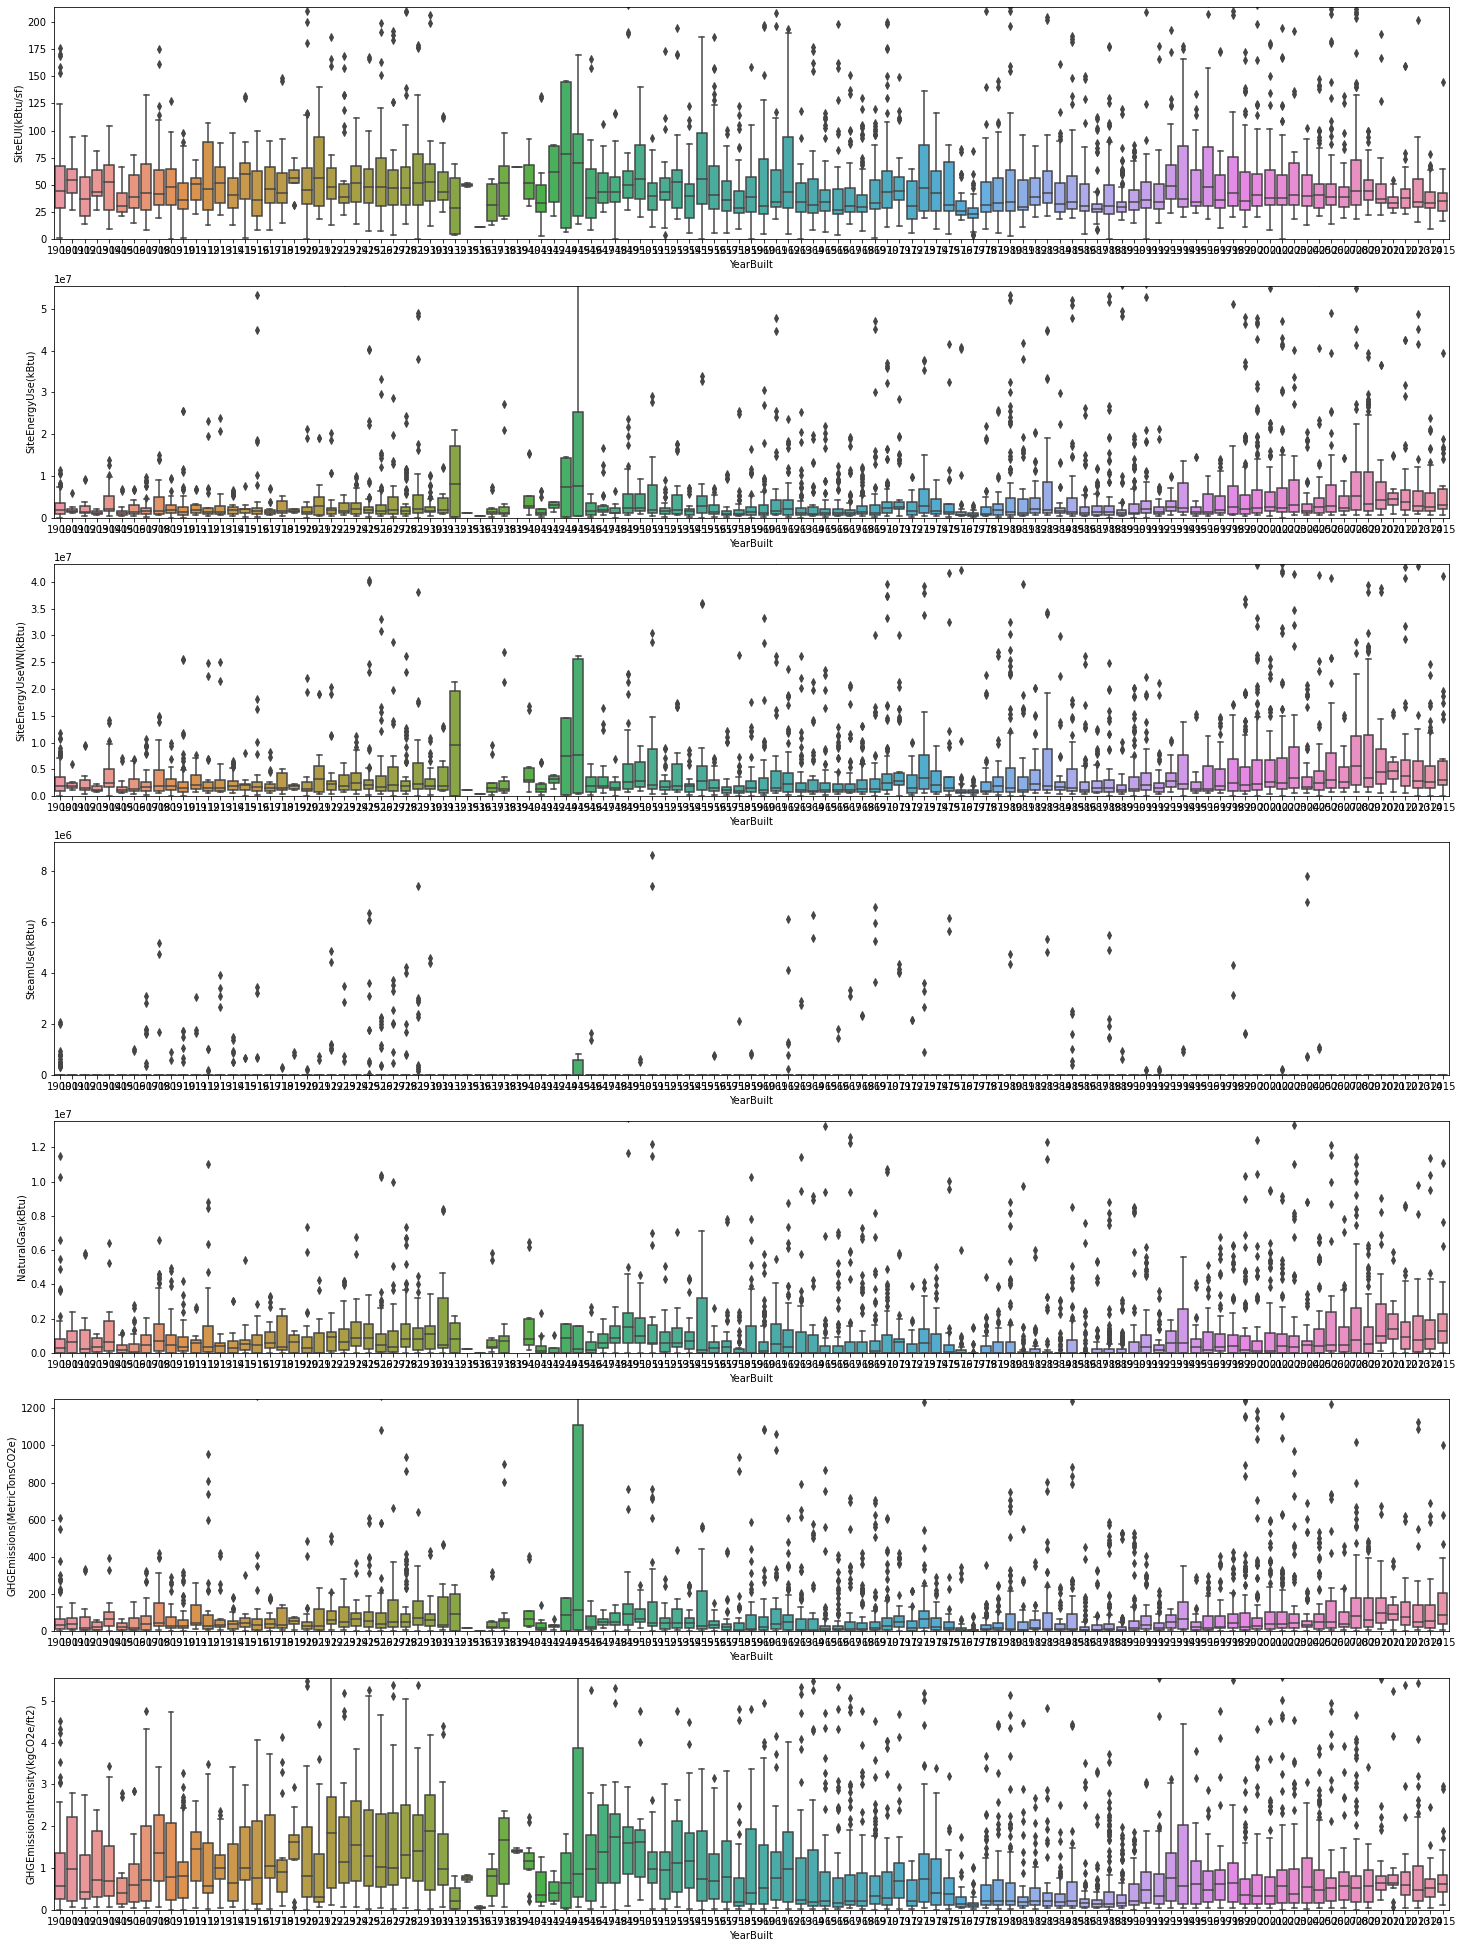

In [92]:
X = 'YearBuilt'
df_plot = df_fusion#pd.DataFrame(scaler.fit_transform(df_fusion[param_target]), columns=[param_target])#
plt.figure('Energies = f(YearBuilt, boxplot)', figsize=(25, 5*len(param_target))), plt.clf()
for i, Y in zip(range(1,len(param_target)+1), param_target) :#['SiteEnergyUse(kBtu)']):#
    axe = plt.subplot(len(param_target),1,i)
    axe.set_ylim([0, df_plot[Y].mean()+3*df_plot[Y].std()])
    sns.boxplot(data=df_plot, y=Y, x=X, ax=axe)
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'13_Boxplot_Etiquettes=f(Yearbuilt)_15et16'+'.png')
del Y, axe, i, X, df_plot

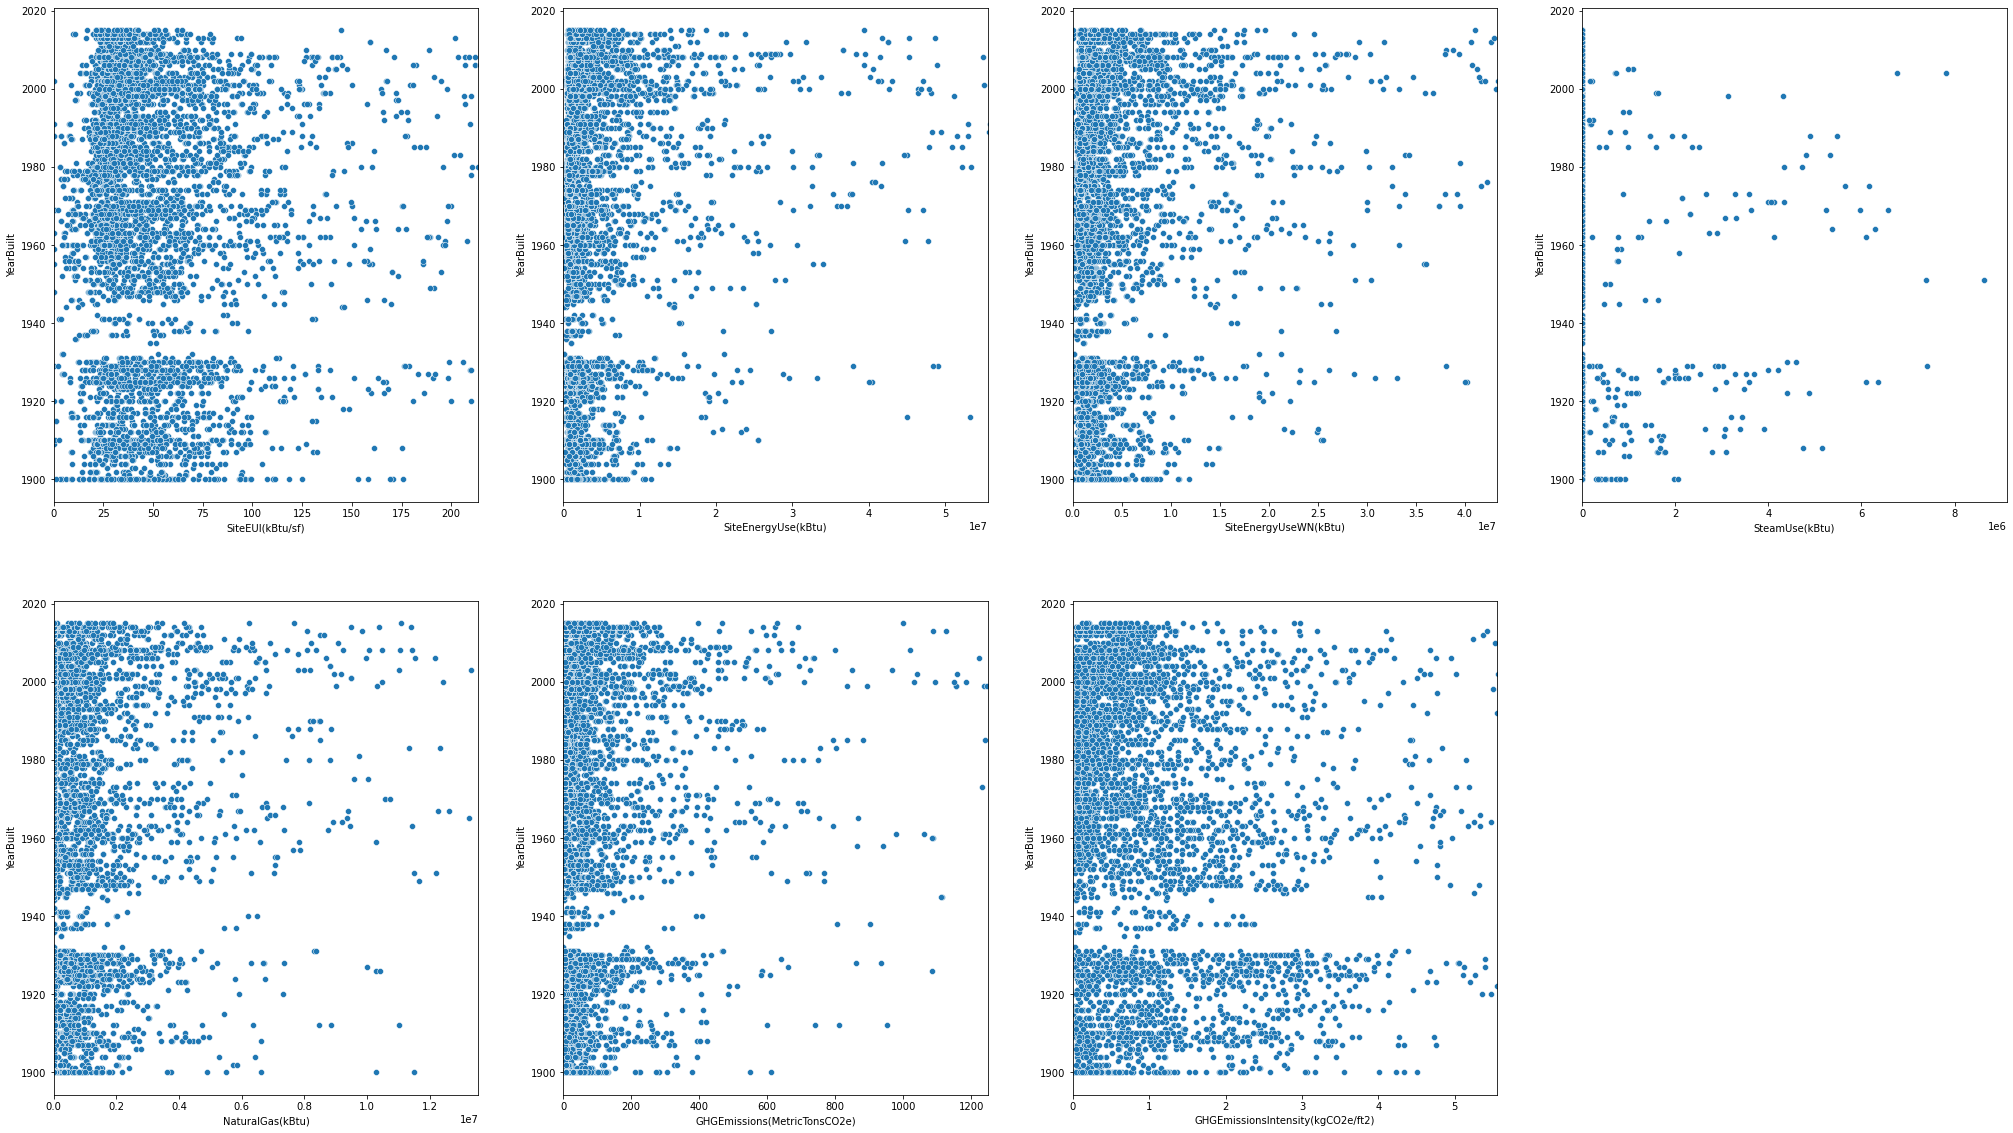

In [93]:
Y = 'YearBuilt'
df_plot = df_fusion#pd.DataFrame(scaler.fit_transform(df_fusion[param_target]), columns=[param_target])#
plt.figure('Energies = f(YearBuilt, Toutes les années)', figsize=(35, 20)), plt.clf()
for i, X in zip(range(1,len(param_target)+1), param_target) :#['SiteEnergyUse(kBtu)']):#
    axe = plt.subplot(2,4,i)
    axe.set_xlim([0, df_plot[X].mean()+3*df_plot[X].std()])
    sns.scatterplot(data=df_plot, y=Y, x=X, ax=axe)
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'13_Scatterplot_Etiquettes=f(Yearbuilt)_15et16'+'.png')
del Y, axe, i, X, df_plot

### Pas mieux : à part peut-être pour <i>SteamUse(kBtu)</i>, il y a toujours une plage de valeurs relativement importante (de l'ordre de 1 fois l'écart-type) surlaquelle les bâtiment sont relativement uniformément distribués indépendamment de l'année.
### Cela signifierait qu'en l'espèce, les données de consommation/production d'énergie seraient peu dépendantes de l'année de construction. C'est vraiment très contre-intuitif.

### On décide donc de NE PAS ranger ce paramètre 'YearBuilt' dans la liste des caractéristiques surlesquelles s'appuiera notre algorithme final.

### 
### <u>4.3.e) Analyse du nombre de Building.</u>

In [94]:
df_fusion['NumberofBuildings'].describe(percentiles=np.linspace(0.1,0.9,9))

count    5947.000000
mean        1.057340
std         1.627704
min         0.000000
10%         1.000000
20%         1.000000
30%         1.000000
40%         1.000000
50%         1.000000
60%         1.000000
70%         1.000000
80%         1.000000
90%         1.000000
max       111.000000
Name: NumberofBuildings, dtype: float64

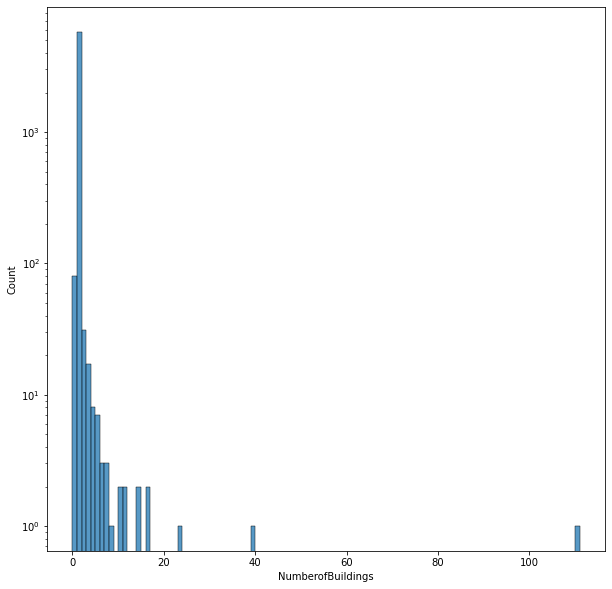

In [95]:
plt.figure('NbrBuilding, histogram', figsize=(10,10)), plt.clf()
sns.histplot(df_fusion, x='NumberofBuildings', bins=np.arange(0,df_fusion['NumberofBuildings'].max()+1), log_scale=(False, True))
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'15_Histplot_NumberOfBuildings_15et16'+'.png')

### Une écrasante majorité de bâtiments (plus de 90%) contiennent moins de 2 édifices, il y a un risque que ce paramètre ne nous aide pas à différencier les distributions des étiquettes, bien qu'intuitivement, on se doute que la consommation d'énergie/production de CO2 augmente avec le nombre d'édifice.

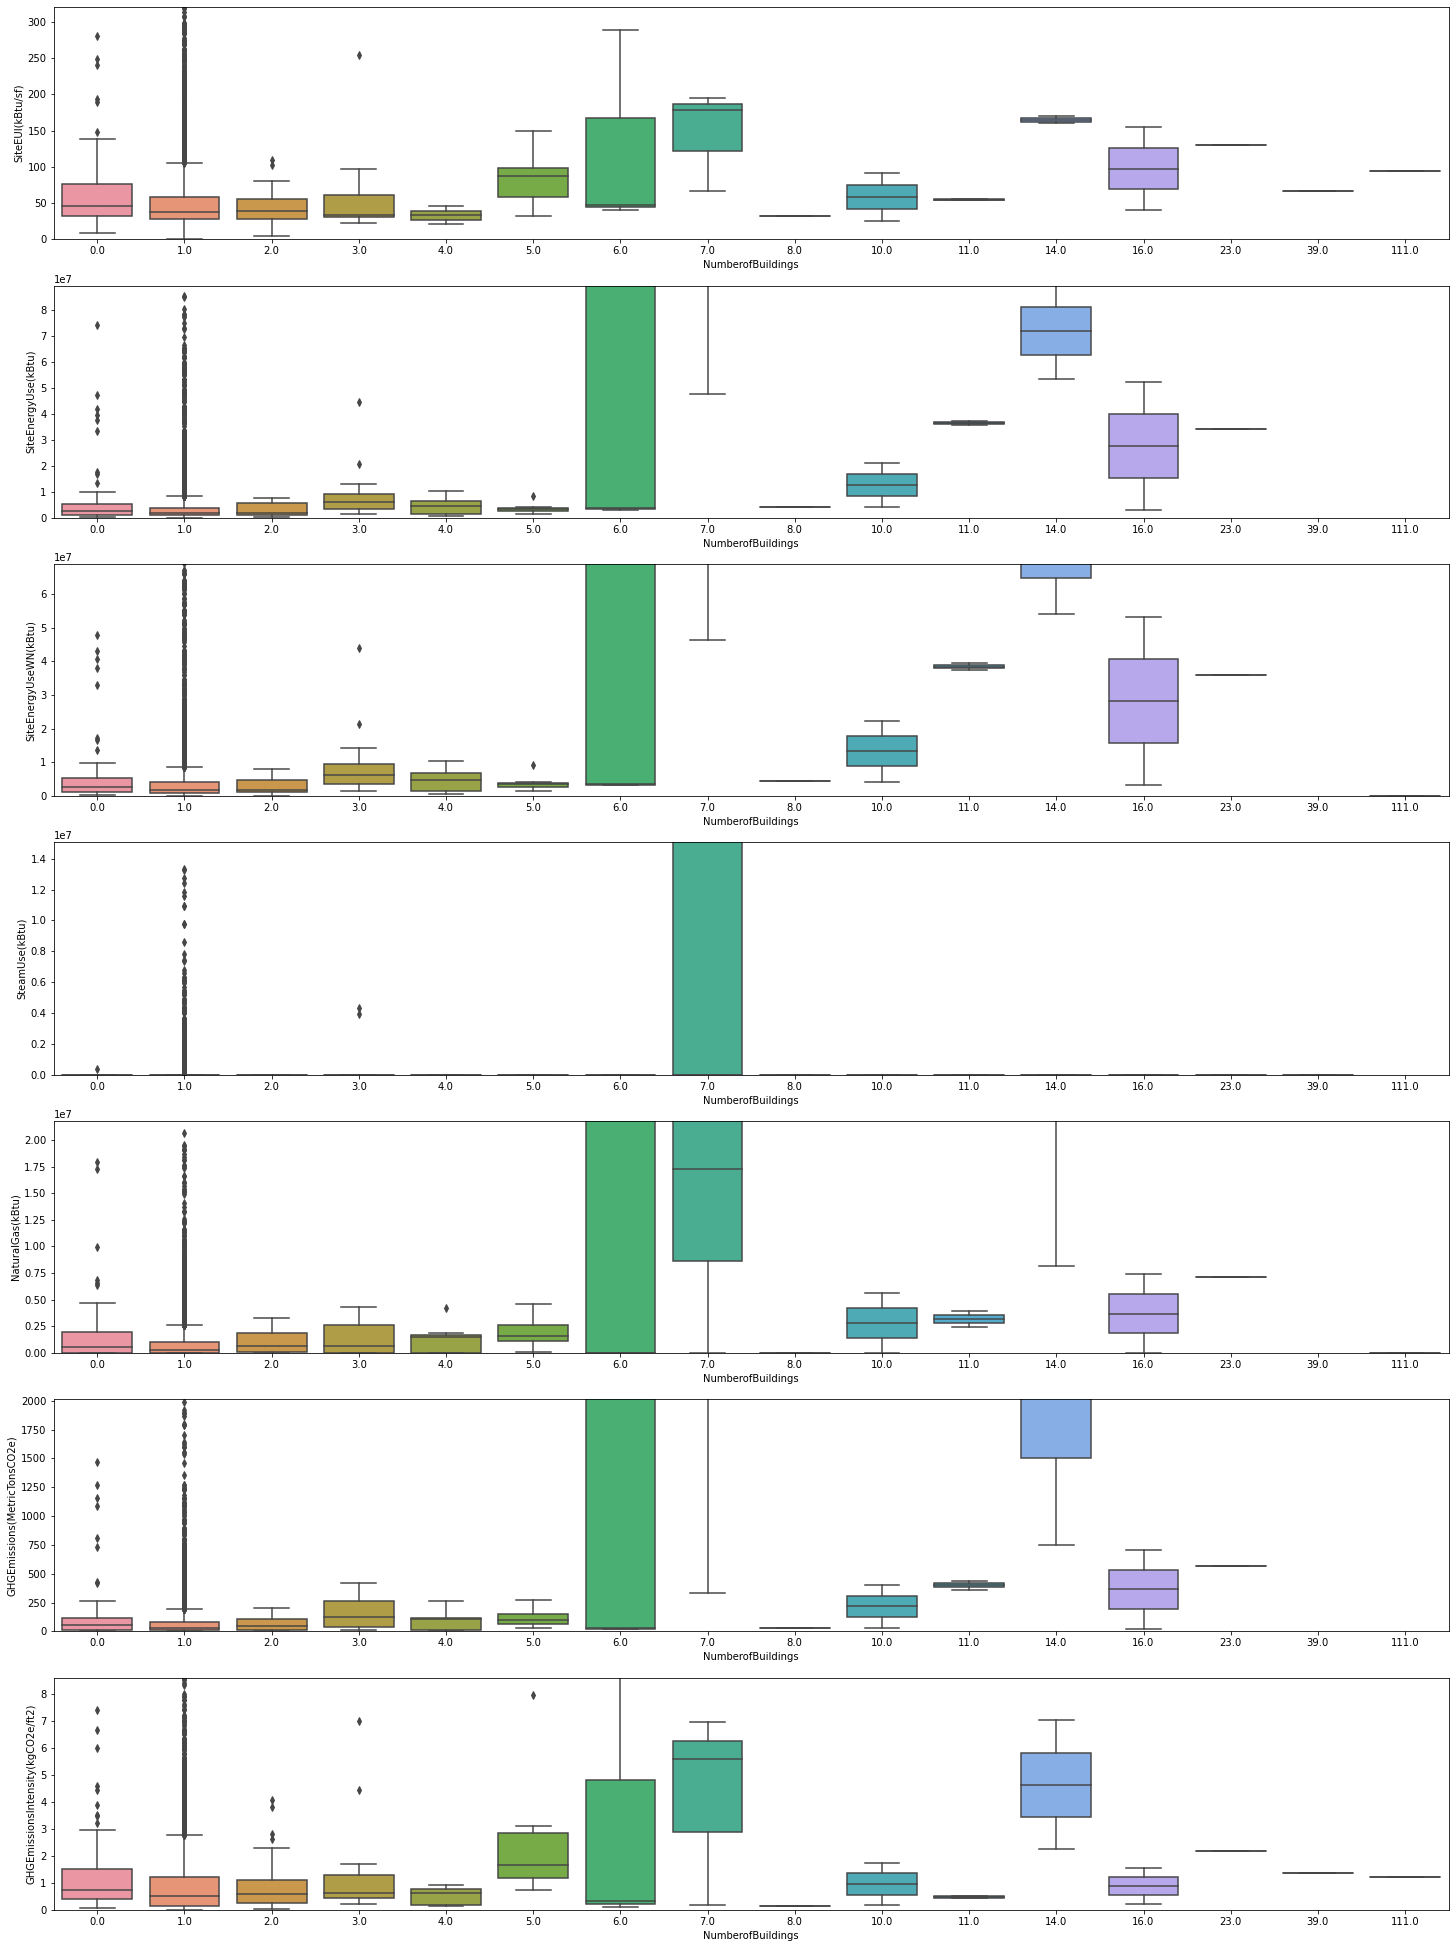

In [96]:
plt.figure('Energies = f(NbrBuilding)', figsize=(25,5*len(param_target))), plt.clf()
X = 'NumberofBuildings'
df_plot = df_fusion
for i, Y in zip(range(1,len(param_target)+1), param_target) :
    axe = plt.subplot(len(param_target),1,i)
    axe.set_ylim([0, df_plot[Y].mean()+5*df_plot[Y].std()])
    sns.boxplot(data=df_plot, y=Y, x=X, ax=axe)
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'16_Boxplot_Etiquettes=f(NumberOfBuildings)_15et16'+'.png')
del X, df_plot, i, Y, axe

### Ce graphe est trompeur, car la plupart des distributions corespondent à de très faibles nombre de représentations (<10 à partir de NumberofBuildings >= 5).
### Pire, pour NumberofBuildings = à 0 ou 2 (90 et 40 occurences, les 2ème et 3ème plus nombreuses), les distributions sont très proches de NumberofBuildings = 1.
### !!!
### <u>CHOIX FORT :</u>
### On ne retient pas ce paramètre.
### !!!

### 
### <u>4.3.f) Analyse du nombre d'étages.</u>

In [97]:
df_fusion['NumberofFloors'].describe(percentiles=np.linspace(0.1,0.9,9))

count    5951.000000
mean        4.752647
std         5.537373
min         0.000000
10%         1.000000
20%         2.000000
30%         3.000000
40%         3.000000
50%         4.000000
60%         4.000000
70%         5.000000
80%         6.000000
90%         7.000000
max        99.000000
Name: NumberofFloors, dtype: float64

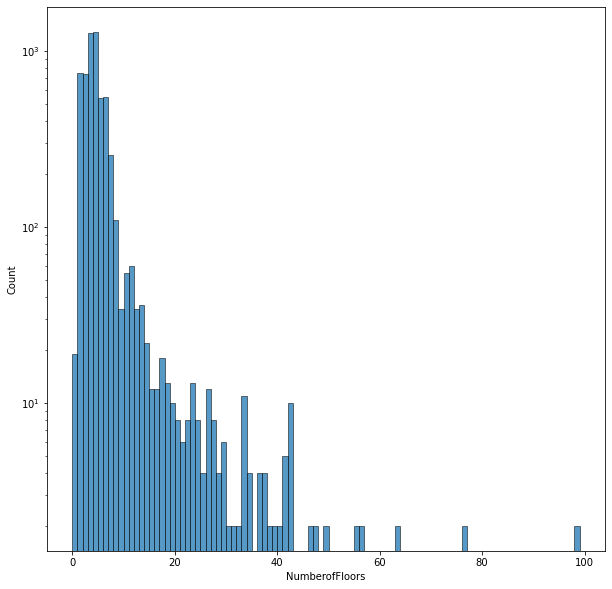

In [98]:
plt.figure('NbrFloors, histogram', figsize=(10,10)), plt.clf()
sns.histplot(df_fusion, x='NumberofFloors', bins=np.arange(0,df_fusion['NumberofFloors'].max()+1), log_scale=(False, True))
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'17_Histplot_NumberOfFloors_15et16'+'.png')

### Ca a l'air mieux que pour NumberofBuildings.
### Prenons toutefois le temps de regarder les distributions des paramètres étiquettes :

In [99]:
df_fusion[list(np.concatenate((param_target, ['NumberofFloors'])))].groupby('NumberofFloors').describe(percentiles=[])

SiteEUI(kBtu/sf)                                                \
                          count        mean         std        min        50%   
NumberofFloors                                                                  
0.0                        19.0   80.247368   26.568055  28.000000  91.000000   
1.0                       746.0   67.817158   75.193237   0.000000  42.750000   
2.0                       734.0   62.345232   60.738557   0.000000  44.650000   
3.0                      1265.0   47.447668   37.229196   0.000000  35.200001   
4.0                      1275.0   41.092392   39.516633   3.600000  30.500000   
5.0                       539.0   50.358256   50.177230   3.000000  36.200001   
6.0                       548.0   51.100547   57.301475  14.400000  38.300000   
7.0                       255.0   51.348235   56.932011   9.200000  42.000000   
8.0                       110.0   67.272727   66.522683  19.900000  44.500000   
9.0                        34.0   57.400000   23.620972  25.100000  52.650000   
10.0                       55.0   72.725455   47.227181  26.900000  57.900002   
11.0                       60.0   68.205000   45.274598  26.400000  55.350000   
12.0                       34.0   62.579412   21.337899  37.200001  56.199999   
13.0                       36.0   63.108334   38.735671  27.600000  46.450000   
14.0                       22.0   71.440909   36.033180  45.300000  58.300000   
15.0                       12.0  106.441666   97.847789  43.400002  65.349998   
16.0                       12.0   70.033333   30.838297  36.100000  60.000002   
17.0                       18.0   56.472222   20.987049  36.400000  47.100000   
18.0                       13.0   62.146154   22.084936  32.900000  66.600000   
19.0                       10.0   86.000000   32.484321  47.000000  87.600002   
20.0                        8.0   70.725000   31.692757  33.599998  67.149999   
21.0                        6.0   79.199999   18.612684  56.599998  84.049998   
22.0                        8.0   48.750000   18.961992  27.800000  42.850000   
23.0                       13.0   60.507693   14.594203  42.000000  58.200000   
24.0                        8.0   58.387500   11.936551  40.900002  59.700000   
25.0                        4.0   54.350000   11.745211  42.300000  54.550001   
26.0                       12.0   42.858333   10.308995  30.400000  41.350000   
27.0                        8.0   53.000000   24.122900   0.000000  54.650000   
28.0                        4.0   72.350001   27.199572  48.200000  72.450001   
29.0                        6.0   56.000001   25.886059  34.500000  44.650000   
30.0                        2.0   83.249999    7.283201  78.099998  83.249999   
31.0                        2.0   54.850000   18.172644  42.000000  54.850000   
32.0                        2.0   41.150000    7.566043  35.800000  41.150000   
33.0                       11.0  168.045456  239.862277  29.600000  60.299999   
34.0                        4.0   67.550001   18.487744  49.700000  67.300001   
36.0                        4.0   43.400000   10.433280  33.600000  43.400000   
37.0                        4.0   36.875000   11.292290  25.200001  37.750000   
38.0                        2.0   61.500001    1.979900  60.100000  61.500001   
39.0                        2.0   43.700000    0.989949  43.000000  43.700000   
40.0                        2.0   47.300001    7.636752  41.900002  47.300001   
41.0                        5.0   72.760000   22.359181  51.200001  67.099998   
42.0                       10.0   59.730000   24.881500  38.000000  47.350000   
46.0                        2.0   51.550001    0.494976  51.200000  51.550001   
47.0                        2.0   42.799999    0.282844  42.599998  42.799999   
49.0                        2.0   53.850000    1.626345  52.700001  53.850000   
55.0                        2.0   45.700000    1.414214  44.700000  45.700000   
56.0                        2.0   36.350000   

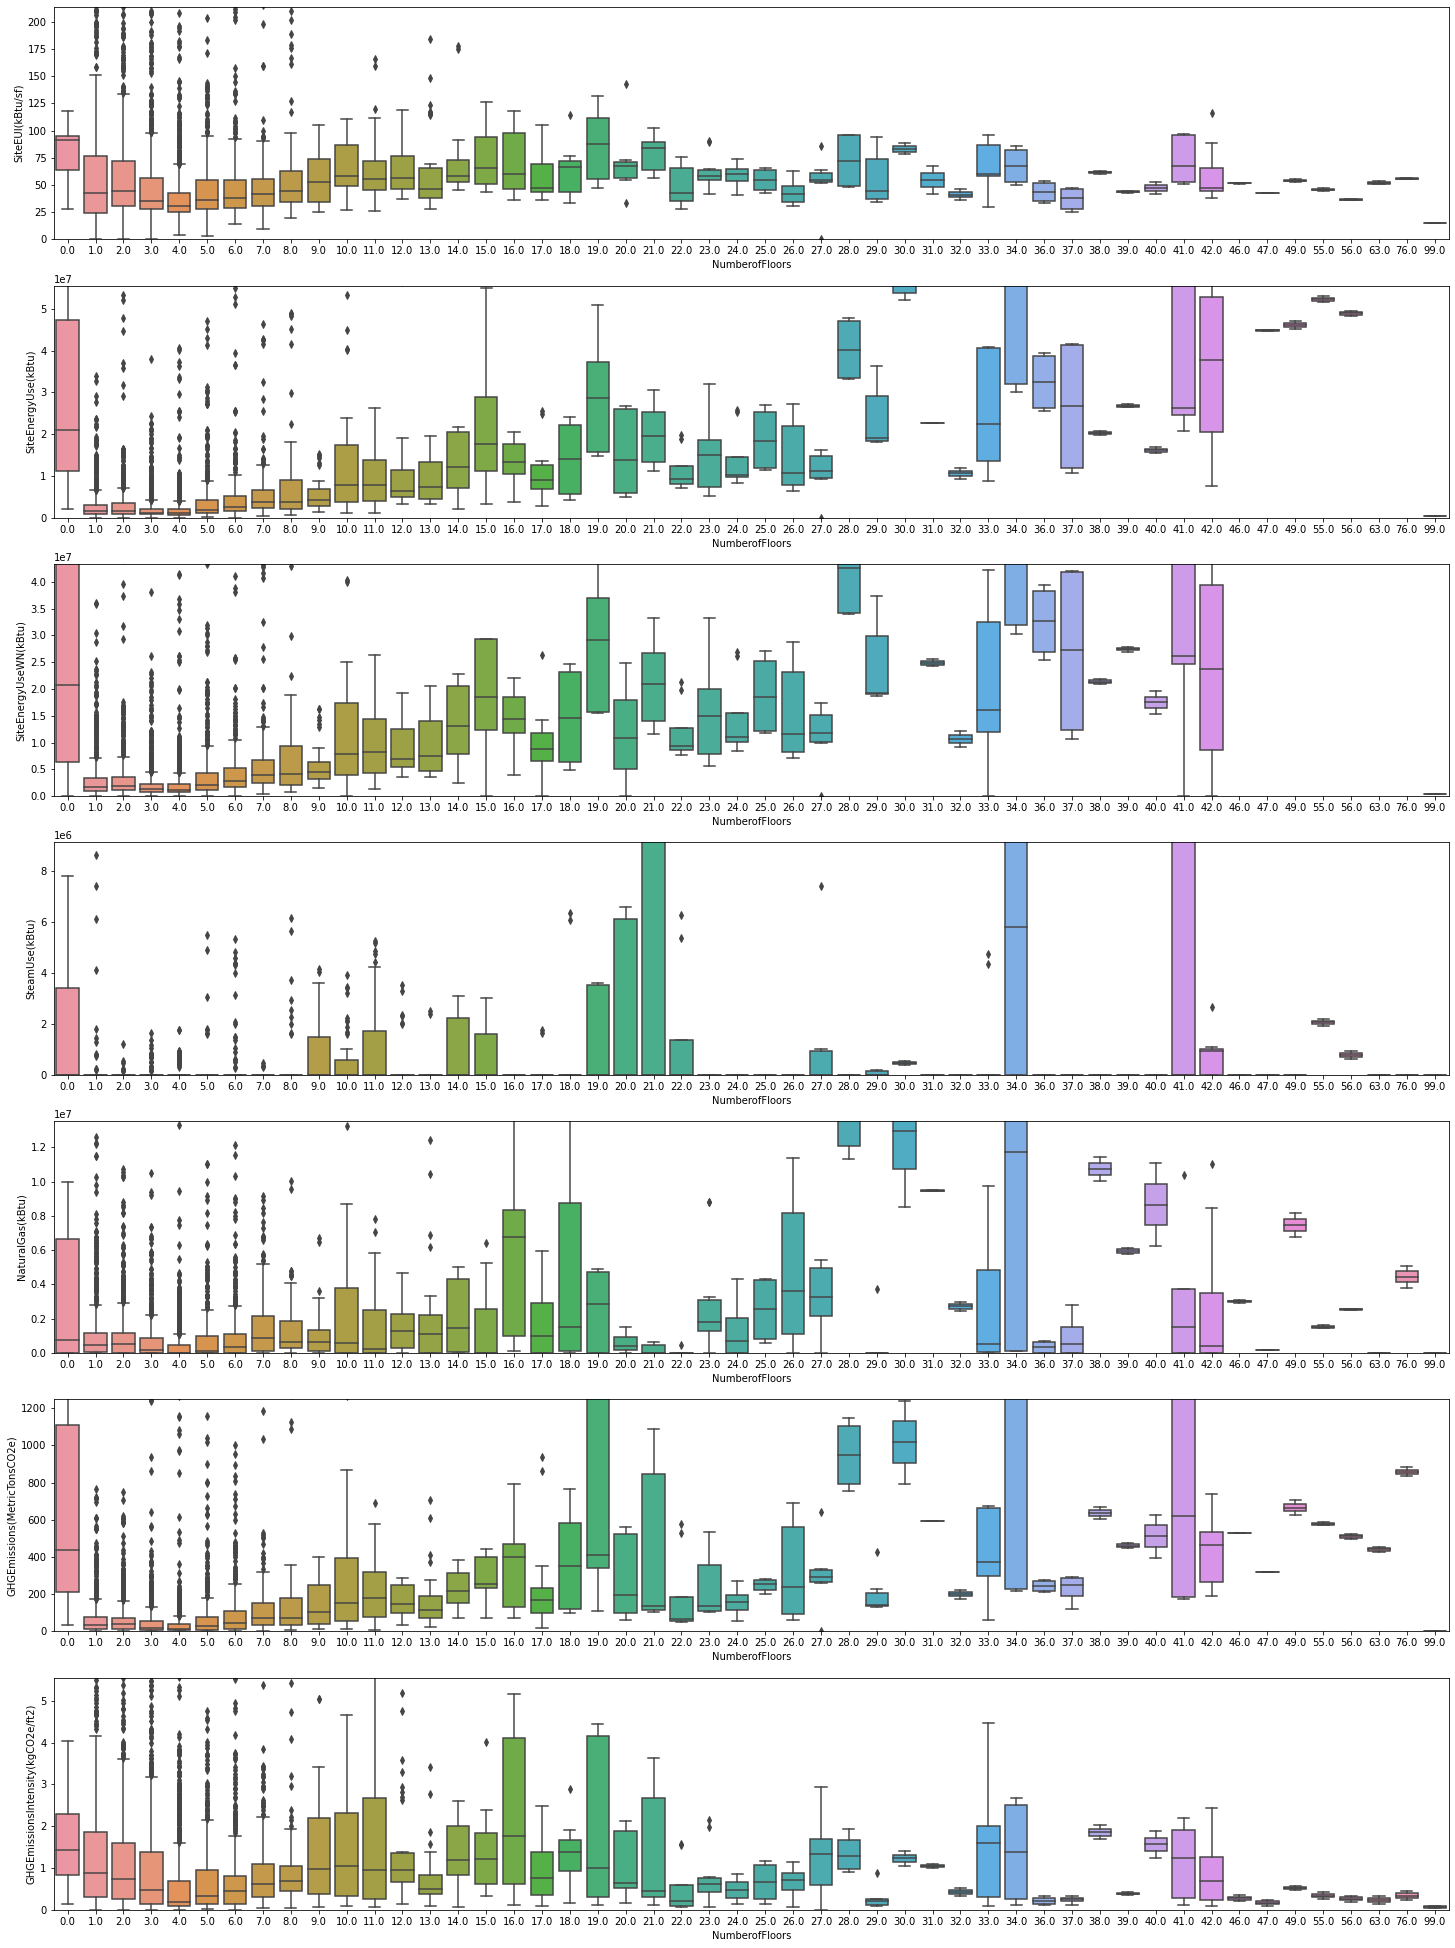

In [100]:
plt.figure('Energies = f(NbrFloors)', figsize=(25,5*len(param_target))), plt.clf()
X = 'NumberofFloors'
df_plot = df_fusion
for i, Y in zip(range(1,len(param_target)+1), param_target) :
    axe = plt.subplot(len(param_target),1,i)
    axe.set_ylim([0, df_plot[Y].mean()+3*df_plot[Y].std()])
    sns.boxplot(data=df_plot, y=Y, x=X, ax=axe)
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'18_Boxplot_Etiquettes=f(NumberOfFloors)_15et16'+'.png')
del X, df_plot, i, Y, axe

### Même si l'effet est moins fort qu'en section précédente, on n'a pas beaucoup de différence entre les distributions des étiquettes pour les nombres d'étages de plus nombreuses occurences (en gros, de 1 à 7). Au contraire, les différences nettes de distributions ne concernent que des nombre d'étages élevés mais qui ne représente même pas 10% du jeu de données...
### !!!
### <u>CHOIX FORT :</u>
### On ne retient pas ce paramètre.
### !!!

### 
### <u>4.3.g) Analyse quant à la localisation.</u>
### Outre l'adresse, qui n'est paas un paramètre facile à manipuler, il demeure 4 paramètres permetant une localisation plus ou moins précise des bâtiments :
- le couple de coordonnées GPS (paramètres quantitatifs) : <i>Latitude</i> et <i>Longitude</i> ;
- le couple de paramètres qualitatifs : <i>CouncilDistrictCode</i> et <i>Neighborhood</i>.

In [101]:
param_loc = ["Latitude", "Longitude", 'CouncilDistrictCode', 'Neighborhood']
df_fusion[param_loc].describe()

Latitude    Longitude  CouncilDistrictCode
count  5955.000000  5955.000000          5955.000000
mean     47.624139  -122.335097             4.459782
std       0.047095     0.027102             2.118790
min      47.499170  -122.414250             1.000000
25%      47.600549  -122.350768             3.000000
50%      47.618960  -122.332748             4.000000
75%      47.656745  -122.319800             7.000000
max      47.733870  -122.258640             7.000000

In [102]:
df_fusion[param_loc[-1]].describe()

count         5955
unique          19
top       DOWNTOWN
freq          1031
Name: Neighborhood, dtype: object

### Visualisons à ce titre la position géographique de chaque bâtiment, ainsi que son assignation aux districts et aux voisinages :

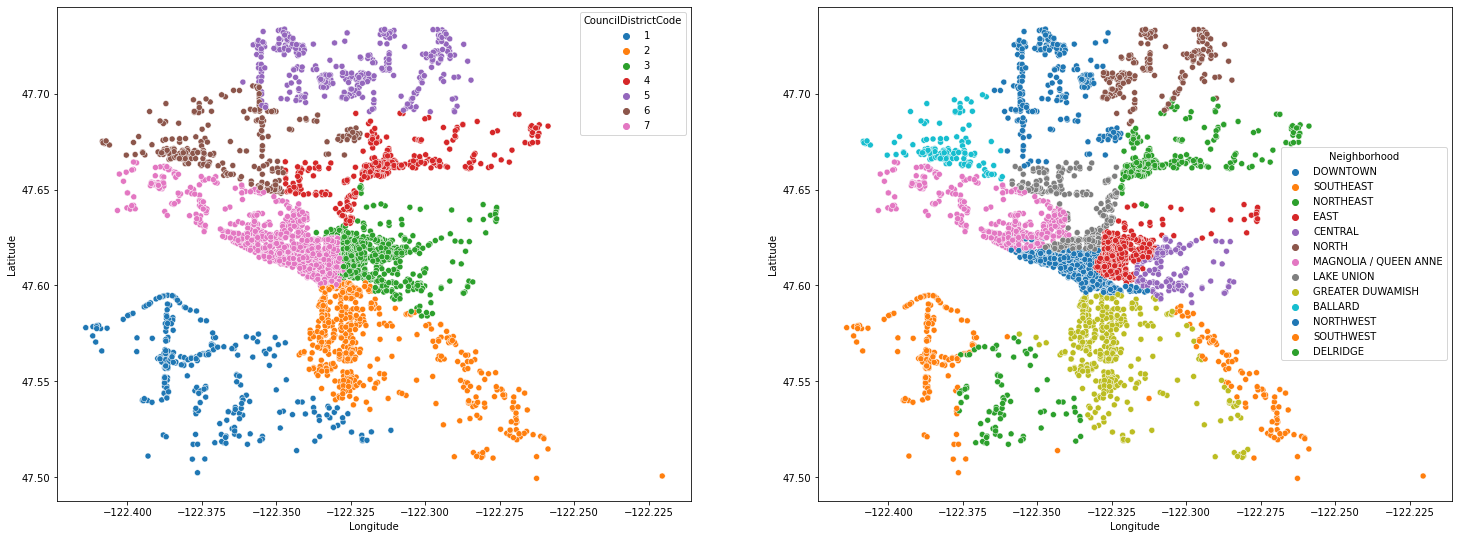

In [103]:
tab_col = ['CouncilDistrictCode', 'Neighborhood']
plt.figure('Quelques caracteristiques = f(Repartition géographique)', figsize=(25,10*int(1+len(tab_col)/2))), plt.clf()
for i, colonne in zip(range(1,len(tab_col)+1), tab_col):
    axe = plt.subplot(int(1+len(tab_col)/2),2,i)
    sns.scatterplot(data=df_15, y="Latitude", x="Longitude", hue=colonne, ax=axe, palette="tab10")
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'19_Scatterplot_f(GPS)1_15et16'+'.png')

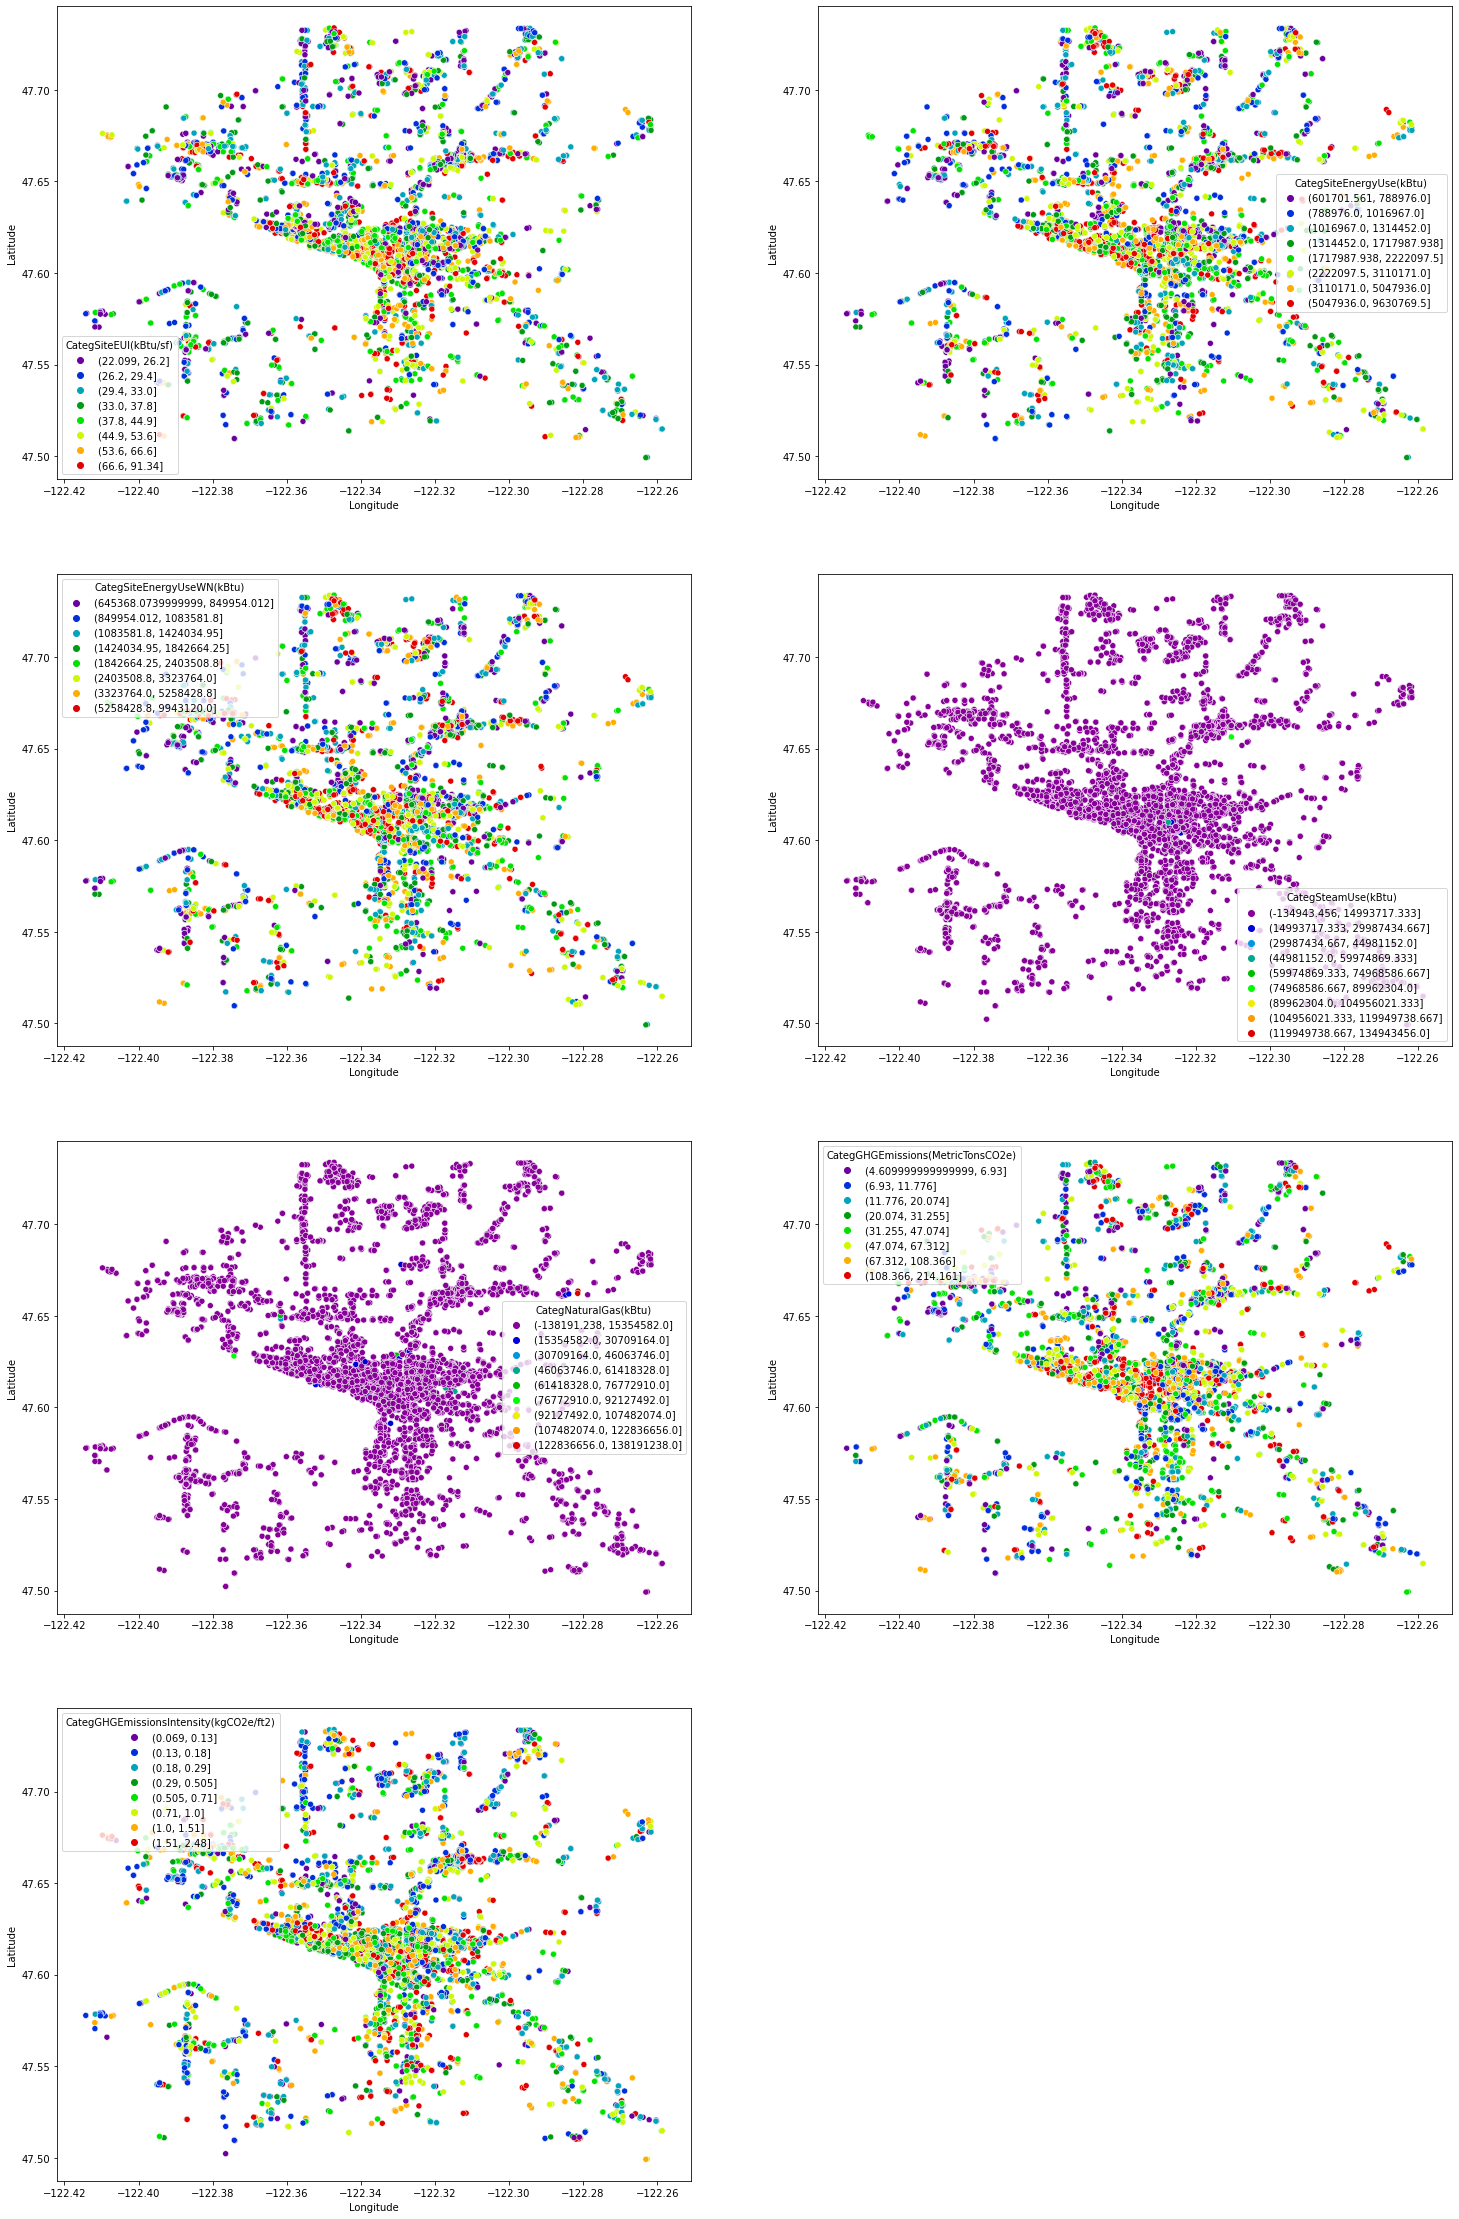

In [104]:
colonnes_numeriques = param_target
df = df_fusion
plt.figure('Categorisation de param GFA = f(Repartition géographique)', figsize=(25,10*(1+int(len(colonnes_numeriques)/2)))), plt.clf()
for i, col_num in zip(range(1, len(colonnes_numeriques)+1), colonnes_numeriques) :
    axe = plt.subplot(int(len(colonnes_numeriques)/2+1),2,i)
    nouv_col = 'Categ'+col_num
    try :
        df[nouv_col] = pd.qcut(df[col_num], q=np.linspace(0.1,0.9,9))#6)#
    except(ValueError):
        df[nouv_col] = pd.cut(df[col_num], bins=9)
    sns.scatterplot(data=df, y="Latitude", x="Longitude", hue=nouv_col, ax=axe, palette="nipy_spectral")#, size=nouv_col, sizes=(100,20))#
    df.drop(columns=[nouv_col], inplace=True)
del colonnes_numeriques, df, i, col_num, nouv_col, axe
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+'20_Scatterplot_f(GPS)2_15et16'+'.png')

### Les coordonnées GPS ont un impact clair sur les valeurs des étiquettes (sauf pour <i>SteamUse</i> et <i>NaturalGas</i>).
### De fait, les districts et les voisinages devraient aussi en avoir un :

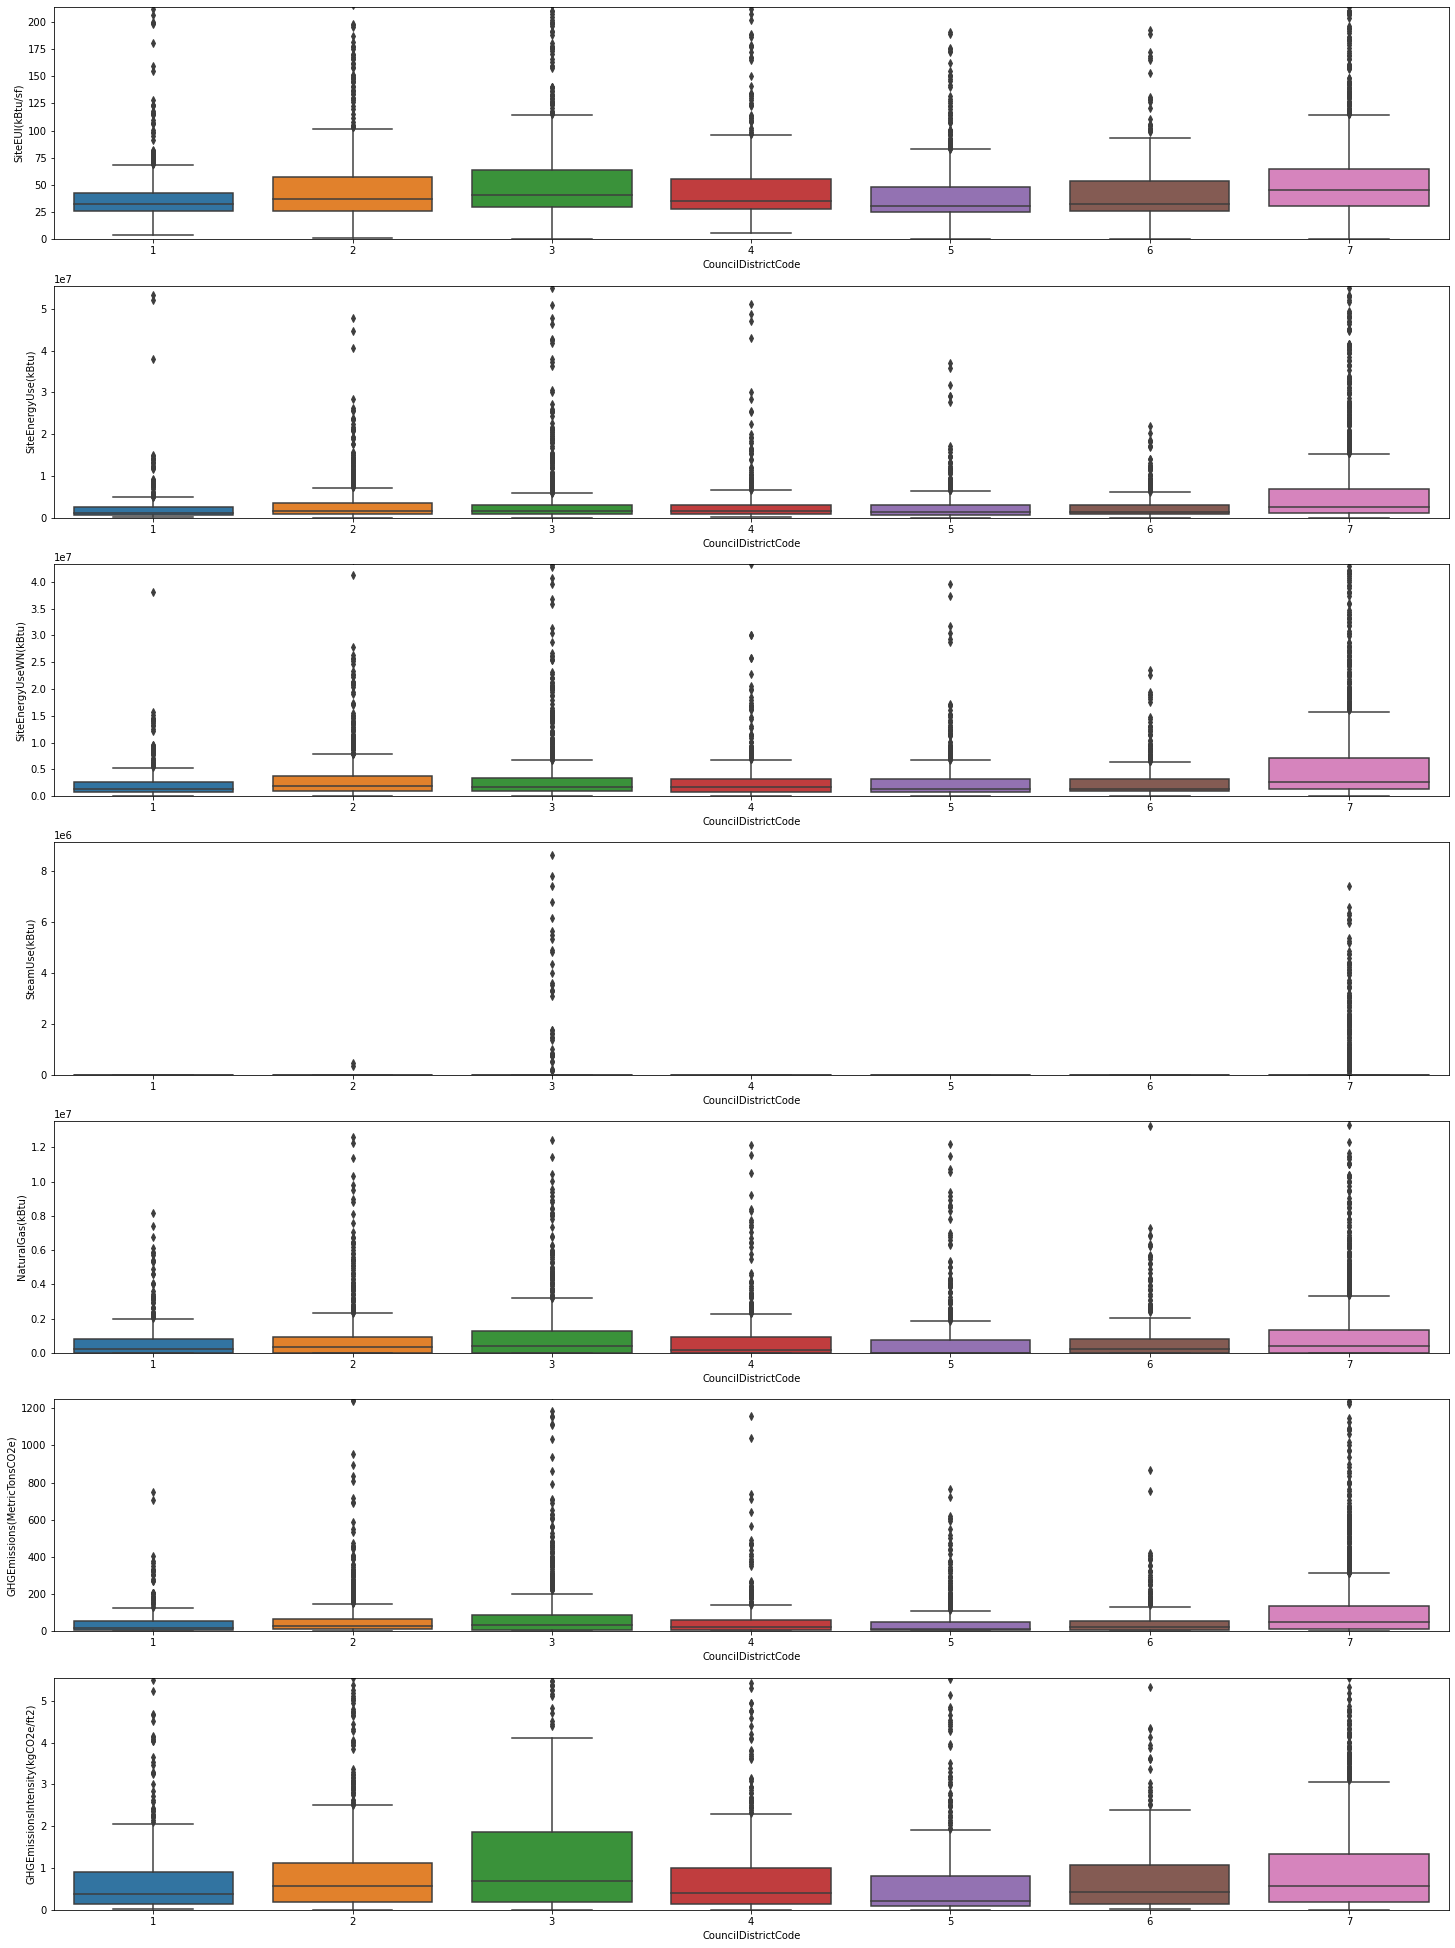

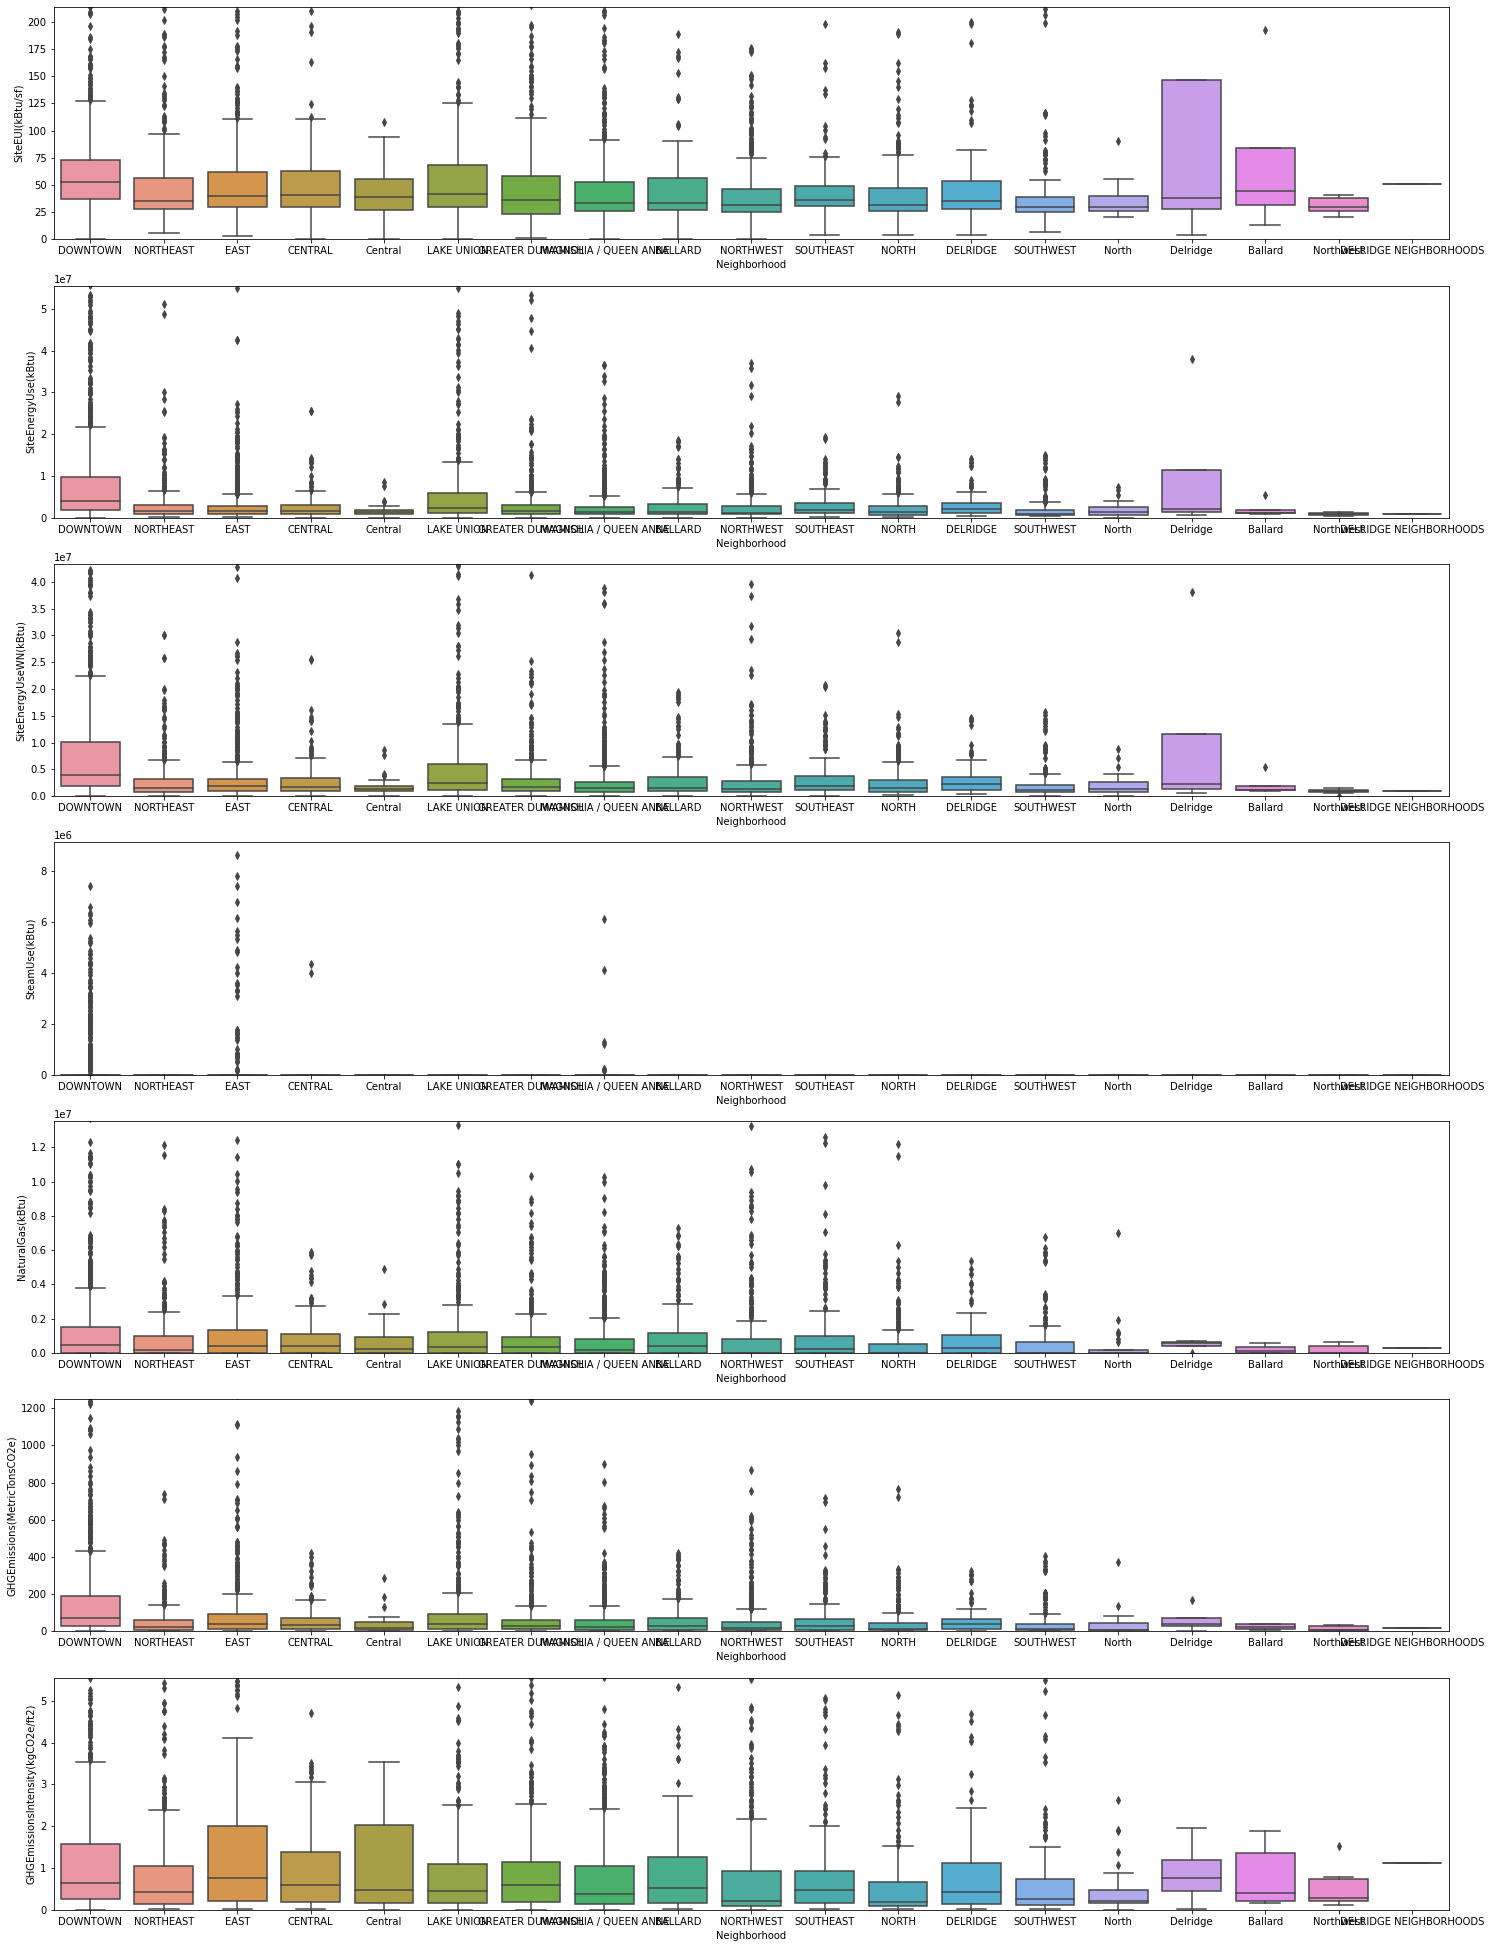

In [105]:
for X in param_loc[-2:] :
    plt.figure(f'Energies = f({X})', figsize=(25,5*len(param_target))), plt.clf()
    df_plot = df_fusion
    for i, Y in zip(range(1,len(param_target)+1), param_target) :
        axe = plt.subplot(len(param_target),1,i)
        axe.set_ylim([0, df_plot[Y].mean()+3*df_plot[Y].std()])
        sns.boxplot(data=df_plot, y=Y, x=X, ax=axe)
    if Sauvegarde_figure :
        plt.savefig(abs_path_fig+f'21_Boxplot_Energies=f({param_loc[-2:].index(X)})_15et16'+'.png')
del X, df_plot, i, Y, axe

### Ce n'est en fait pas le cas pour les districts, et assez peu le cas pour les voisinages, où seules les hautes valeurs des étiquettes permettent de faire un premier tri parmis eux. Ce qui est déjà pas mal.

### !!!
### <u>CHOIX FORT :</u>
### Sur la foi de cet argument, on devrait donc délaisser ces deux paramètres. Cependant, vu que l'on va conserver les coordonnées GPS, autant garder un de ces deux derniers paramètres, car il fournit directement une classification des localisations.
### On décide donc de conserver <i>Neighborhoods</i>, bien qu'il n'offre pas de garantie d'utilité pour l'algorithme.
### !!!

In [106]:
### Mise à jour du tableau de rangement des paramètres sélectionnés :
for param in ['Latitude', 'Longitude', 'Neighborhood']:
    if param in tab_param_retenus :
        print('Paramètre déjà retenu.')
    else :
        tab_param_retenus.append(param)
del param

### Enfin, avant de passer à la dernière étape de ce notebook, on peut voir, grâce aux figures précédentes, qu'il y a des valeurs prises par <i>Neighborhoods</i> qui ne diffrèrent d'une autre que du fait d'un format de chaîne de caractères légèrement différent.
### On se charge de modifier celà "manuellement", du fait du faible nombre de valeurs différentes et de cas nécessitant madification :

In [107]:
### On les affiche un bon coup, histoire de pouvoir rédiger les prochaines lignes :
df_fusion["Neighborhood"].value_counts()

DOWNTOWN                  1031
EAST                       806
MAGNOLIA / QUEEN ANNE      759
GREATER DUWAMISH           649
NORTHEAST                  473
LAKE UNION                 464
NORTHWEST                  379
SOUTHWEST                  293
NORTH                      283
BALLARD                    235
CENTRAL                    206
SOUTHEAST                  170
DELRIDGE                   132
North                       29
Central                     26
Northwest                   10
Ballard                      5
Delridge                     4
DELRIDGE NEIGHBORHOODS       1
Name: Neighborhood, dtype: int64

In [108]:
# On crée deux listes de même tailles : les valeurs à modifier, et les valeurs visées
valeurs_a_modifier, valeurs_visees = ['Ballard', 'Central', 'Delridge', 'DELRIDGE NEIGHBORHOODS', 'North', 'Northwest'], ['BALLARD', 'CENTRAL', 'DELRIDGE', 'DELRIDGE', 'NORTH', 'NORTHWEST']
# On crée une varaible locale pour faciliter l'écriture
df = df_fusion["Neighborhood"].copy(deep=True)
# On parcours les valeurs à modifier :
for val_mod in valeurs_a_modifier :
    # on retient les indices de la b2d où se situent ces valeurs
    liste_indices, i_mod = df.where(df==val_mod).dropna(axis=0).index, valeurs_a_modifier.index(val_mod)
    # On parcours ces indices
    for indx in liste_indices :
        # On modifie
        df.loc[indx] = valeurs_visees[i_mod]
# On efface les variables locales devenue desormais inutiles       
del val_mod, indx, i_mod

In [109]:
df.value_counts()

DOWNTOWN                 1031
EAST                      806
MAGNOLIA / QUEEN ANNE     759
GREATER DUWAMISH          649
NORTHEAST                 473
LAKE UNION                464
NORTHWEST                 389
NORTH                     312
SOUTHWEST                 293
BALLARD                   240
CENTRAL                   232
SOUTHEAST                 170
DELRIDGE                  137
Name: Neighborhood, dtype: int64

### C'est bon, on peut donc acter ces changments dans la b2d :

In [110]:
df_fusion["Neighborhood"] = df
del df, valeurs_a_modifier, valeurs_visees
df_fusion["Neighborhood"].value_counts()

DOWNTOWN                 1031
EAST                      806
MAGNOLIA / QUEEN ANNE     759
GREATER DUWAMISH          649
NORTHEAST                 473
LAKE UNION                464
NORTHWEST                 389
NORTH                     312
SOUTHWEST                 293
BALLARD                   240
CENTRAL                   232
SOUTHEAST                 170
DELRIDGE                  137
Name: Neighborhood, dtype: int64

### 
### <u>4.3.h) Ajout de l'EnergieScore.</u>
### On rajoute <i>EnergieScoreSTAR</i> car il faudra en évaluer la pertinence.

In [111]:
### Mise à jour du tableau de rangement des paramètres sélectionnés :
for param in ['ENERGYSTARScore']:
    if param in tab_param_retenus :
        print('Paramètre déjà retenu.')
    else :
        tab_param_retenus.append(param)
del param

# 
# <u>5)Traitement des NaN.</u>

In [112]:
# Copie
df_b2d_ssnan = df_fusion[tab_param_retenus].copy(deep=True)
# Réduction
df_b2d_ssnan.dropna(axis=0, how='any', inplace=True)
# On vérifie que toutes les colonnes ont été conservées 
df_b2d_ssnan.columns

Index(['OSEBuildingID', 'DataYear', 'SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'BuildingType', 'PrimaryPropertyType',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType',
       'Latitude', 'Longitude', 'Neighborhood', 'ENERGYSTARScore'],
      dtype='object')

### Commenons par voir si celà a affecté les distributions des étiquettes.

In [113]:
noms_etiquettes = ['SiteEUI(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'NaturalGas(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)']
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df, df_ssnan = df_fusion[noms_etiquettes].copy(deep=True), df_b2d_ssnan[noms_etiquettes].copy(deep=True)
### On calcule (et affiche) les écarts relatifs de certaines propriétés statistiques lors de la suppression des NaN pour chaque étiquette
for colonne in df.columns:
    moy, std, mediane = df[colonne].mean(), df[colonne].std(), df[colonne].median()
    moy_ssnan, std_ssnan, mediane_ssnan = df_ssnan[colonne].mean(), df_ssnan[colonne].std(), df_ssnan[colonne].median()
    try :
        print(f'Pour l`étiquette {colonne : >35} : Delta(moyenne) = {100*(moy-moy_ssnan)/moy : >8.2f} ; Delta(écart-type) = {100*(std-std_ssnan)/std : >8.2f} ; Delta(médiane) = {100*(mediane-mediane_ssnan)/mediane : >8.2f}.')
    except(ZeroDivisionError):
        print(f'Pour l`étiquette {colonne : >35} : Delta(moyenne) = {100*(moy-moy_ssnan)/moy : >8.2f} ; Delta(écart-type) = {100*(std-std_ssnan)/std : >8.2f} ; Médiane = 0')
### Effacement des variables désormais inutiles
del moy, std, mediane, moy_ssnan, std_ssnan, mediane_ssnan, colonne
if 1==0 :
    ### Affichage des distributions pour chaque étiquette : à gauche avec NaN, à droite sans la moindre NaN
    plt.figure('Distributions étiquettes avec et sans NaN', figsize=(20,40)), plt.clf()
    for i, colonne in zip(range(1,15), np.sort(np.concatenate((df.columns, df.columns)))):
        # avec NaN sur la 1èer ligne, sans NaN sur la seconde
        df_plot = df_ssnan[colonne] if i/2==int(i/2) else df[colonne]
        axe = plt.subplot(7,2,i)
        text, description = f'', dict(df_plot.describe(percentiles=np.linspace(0.1,0.9,9)))#[0.1, 0.25, 0.5, 0.75, 0.9]))
        # on met en légende de chaque graphes une description statistique du paramètre concerné
        for clef in description:
            text += '%s : %i\n'%(clef, description[clef]) if description[clef]==int(description[clef]) else '%s : %.3e\n'%(clef, description[clef]) if abs(description[clef])<0.1 else '%s : %.2e\n'%(clef, description[clef]) if abs(description[clef])>1000 else '%s : %.3f\n'%(clef, description[clef])
        sns.histplot(df_plot, ax=axe, kde=False, log_scale=(False, False), legend=True, label=text)
        plt.legend(loc='best', fontsize=13)
    ### Effacement des variables désormais inutiles
    del df, df_ssnan, df_plot, i, colonne, axe, text, description, clef

Pour l`étiquette                    SiteEUI(kBtu/sf) : Delta(moyenne) =   -16.70 ; Delta(écart-type) =    -9.13 ; Delta(médiane) =   -32.01.
Pour l`étiquette                 SiteEnergyUse(kBtu) : Delta(moyenne) =  -156.79 ; Delta(écart-type) =     1.41 ; Delta(médiane) =  -299.08.
Pour l`étiquette               SiteEnergyUseWN(kBtu) : Delta(moyenne) =  -157.15 ; Delta(écart-type) =   -31.50 ; Delta(médiane) =  -282.40.
Pour l`étiquette                      SteamUse(kBtu) : Delta(moyenne) =  -156.94 ; Delta(écart-type) =    13.11 ; Médiane = 0
Pour l`étiquette                    NaturalGas(kBtu) : Delta(moyenne) =   -71.66 ; Delta(écart-type) =   -17.18 ; Delta(médiane) =   -53.76.
Pour l`étiquette        GHGEmissions(MetricTonsCO2e) : Delta(moyenne) =  -112.03 ; Delta(écart-type) =    -2.37 ; Delta(médiane) =  -178.58.
Pour l`étiquette   GHGEmissionsIntensity(kgCO2e/ft2) : Delta(moyenne) =    19.74 ; Delta(écart-type) =    33.50 ; Delta(médiane) =    -0.99.


### C'est ce qu'on craignait : on a régulièrement des écarts-relatifs (en absolu) supérieurs à 20% de l'écart-type et de la moyenne et de la médiane !!! Et pour certainnes étiquettes comme <i>SiteEnergyUse</i>, on a carrément un facteur 2 entre les moyennes et les médianes !!! On ne peut donc pas se contenter de délaisser les lignes comportant des NaN...

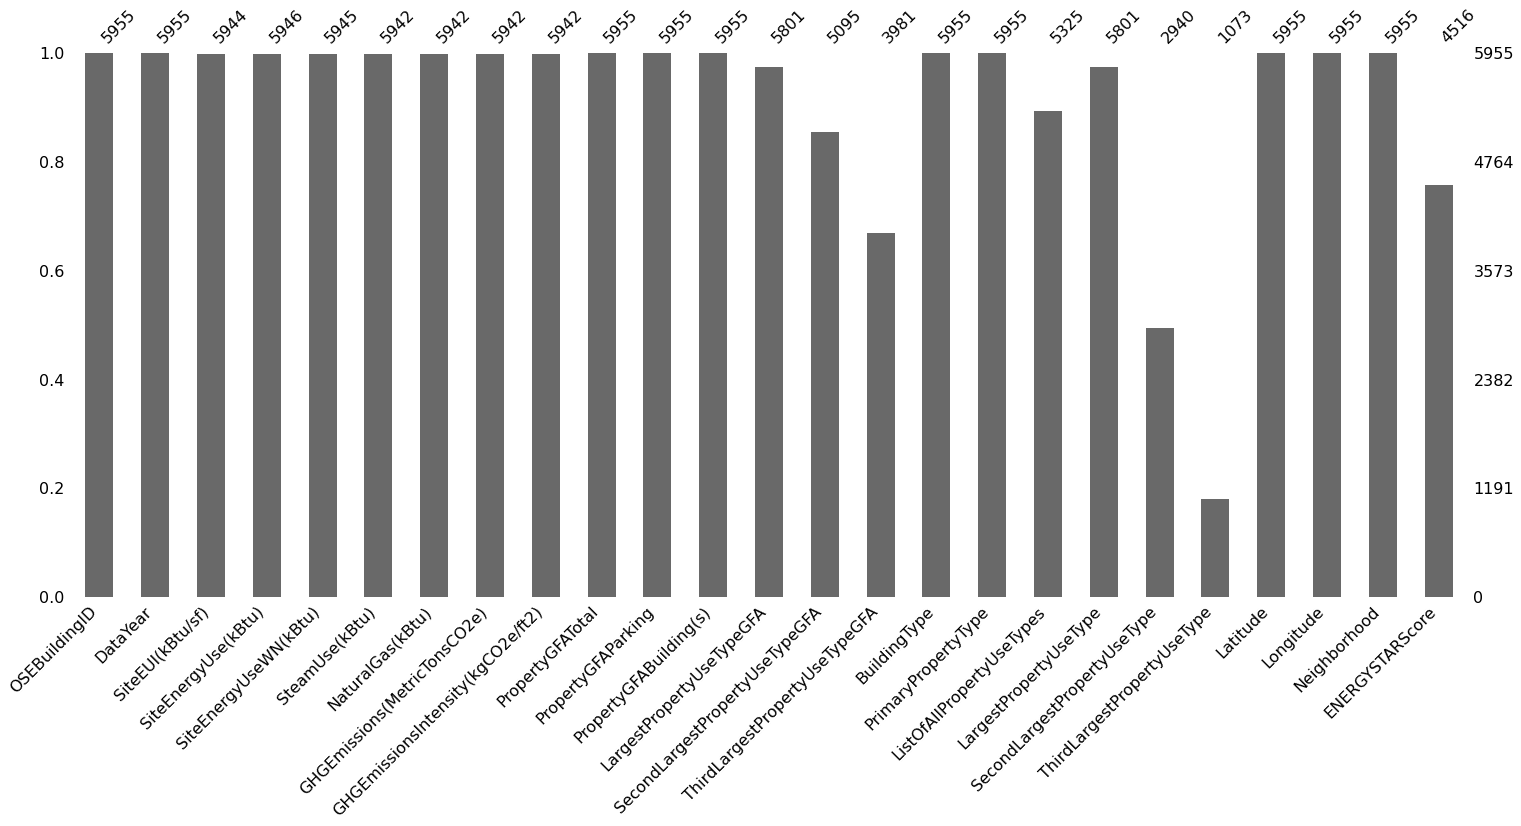

In [114]:
### Affichage de la matrice de densité de la B2D
plt.figure('Densite de remplissage param_retenus', figsize=(25,6)), plt.clf()
bar(df_fusion[tab_param_retenus])
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+f'22_Densité_replissages_param_retenus_15et16'+'.png')

### Les <i>features</i> qualitatifs et quantitatifs en rapport avec le 2nd et 3ème type d'usage/de surface sont ceux qui sont - de loin - les plus vides/les plus garnis de NaN. 
### Observons si, au moins, ces NaN se situent simultanément sur les mêmes lignes de la B2D

<Figure size 1800x432 with 0 Axes>

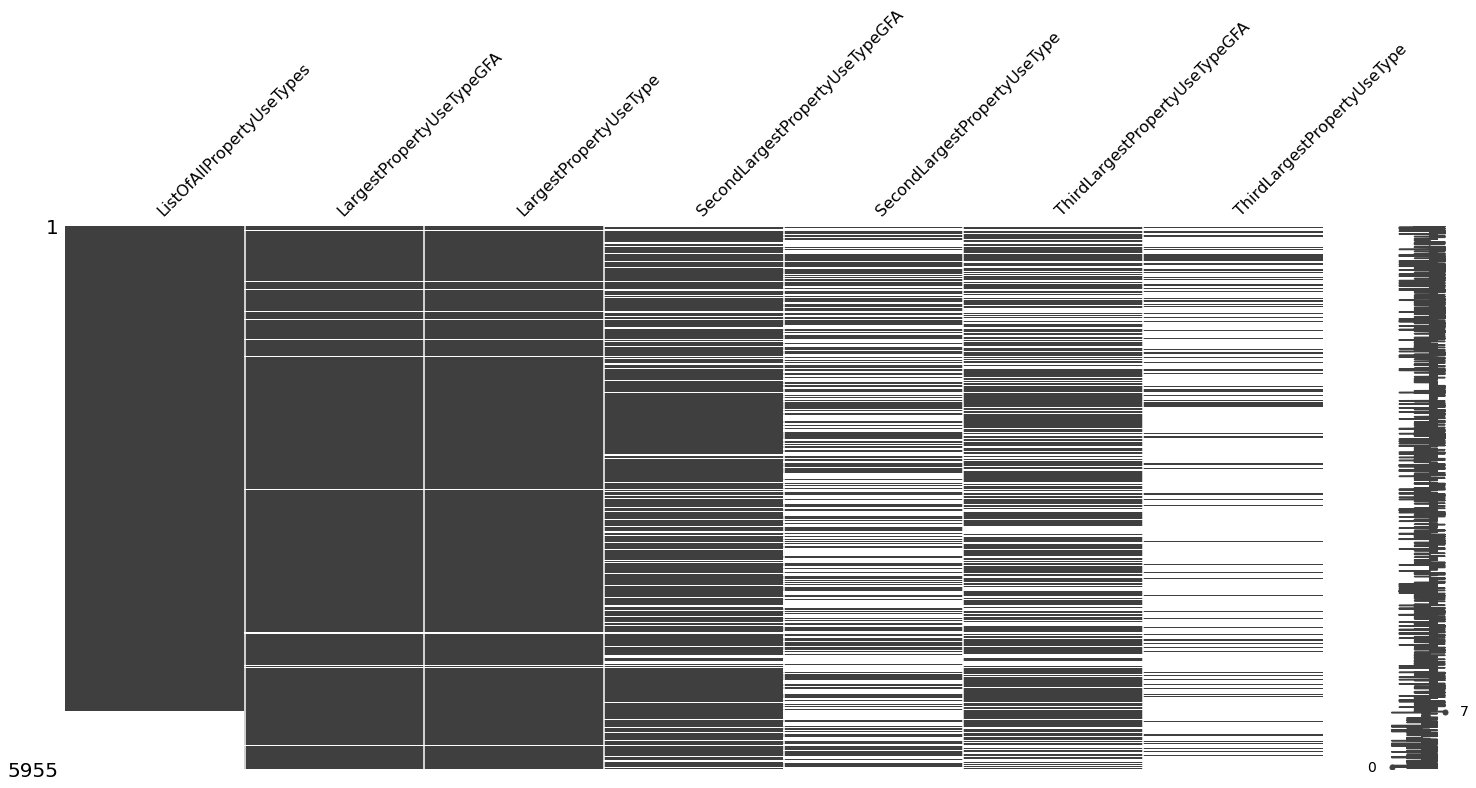

In [115]:
plt.figure('Matrice remplissage param UseType et UseTypeGFA', figsize=(25,6)), plt.clf()
matrix(df_fusion[['ListOfAllPropertyUseTypes','LargestPropertyUseTypeGFA','LargestPropertyUseType','SecondLargestPropertyUseTypeGFA','SecondLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType']])

### C'est mitigé.
### Concentrons nous sur <i>SecondLargestPropertyUseTypeGFA</i> et <i>SecondLargestPropertyUseType</i>, et regardons si les NaN de <i>SecondLargestPropertyUseType</i> correspondent à des 0 de <i>SecondLargestPropertyUseTypeGFA</i>, auquel cas, on pourra faire de l'imputation facile : si la surface est nulle, on pourra attribuer la valeur 'None' au type d'usage, car il n'y en a pas.

In [116]:
#Copie des deux features
df_2ndgfa, df_2ndtype = df_fusion['SecondLargestPropertyUseTypeGFA'].copy(deep=True), df_fusion['SecondLargestPropertyUseType'].copy(deep=True)
# recherche des indices des surfaces qui sont nulles
indices_2ndgfa_0 = df_2ndgfa.where(df_2ndgfa==0).dropna(axis=0).index
# recherche des éléments correspondant à ces indices pour lesquels le type d'usage n'est pas défini
df_2ndtype.loc[indices_2ndgfa_0].shape[0], df_2ndtype.loc[indices_2ndgfa_0].isna().value_counts()

(2325,
 True     2155
 False     170
 Name: SecondLargestPropertyUseType, dtype: int64)

### C'est le cas pour la quasi totalité des éléments concernés ! On pourra donc 2155 fois sur 2325 remplacer une NaN par la valeur 'None'.
### Cherchons à faire la même chose pour le duo <i>ThirdLargestPropertyUseTypeGFA</i> et <i>ThirdLargestPropertyUseType</i> :

In [117]:
df_3rdgfa, df_3rdtype = df_fusion['ThirdLargestPropertyUseTypeGFA'].copy(deep=True), df_fusion['ThirdLargestPropertyUseType'].copy(deep=True)
indices_3rdgfa_0 = df_3rdgfa.where(df_3rdgfa==0).dropna(axis=0).index
df_3rdtype.loc[indices_3rdgfa_0].shape[0], df_3rdtype.loc[indices_3rdgfa_0].isna().value_counts()

(2988,
 True     2908
 False      80
 Name: ThirdLargestPropertyUseType, dtype: int64)

### C'est encore le cas, et même d'avantage !
### On créée donc deux varaibles contenant les indices des éléments qui vérifient cette égalité et vont permettre de telles imputations pour <i>SecondLargestPropertyUseType</i> et <i>ThirdLargestPropertyUseType</i> :

In [118]:
### On relève les indices des éléments qui vérifient cette égalité pour le second type de surface/d'usage
indices_2ndtype_nan_2ndgfa_0 = indices_2ndgfa_0.copy(deep=True)
for indx in indices_2ndgfa_0 :
    if df_2ndtype.loc[indices_2ndgfa_0].isna().loc[indx] == False :
        indices_2ndtype_nan_2ndgfa_0 = indices_2ndtype_nan_2ndgfa_0.drop(indx) 
#On affiche la liste de ces indices, et celle des indices qui correspondent à une surface nulle, afin de vérifier par leur longueur
indices_2ndgfa_0, indices_2ndtype_nan_2ndgfa_0

(Int64Index([   0,    1,    7,   14,   15,   16,   17,   24,   25,   39,
             ...
             6694, 6701, 6702, 6703, 6706, 6707, 6709, 6710, 6711, 6712],
            dtype='int64', length=2325),
 Int64Index([   0,    1,    7,   14,   15,   16,   17,   24,   25,   39,
             ...
             6694, 6701, 6702, 6703, 6706, 6707, 6709, 6710, 6711, 6712],
            dtype='int64', length=2155))

In [119]:
### On relève les indices des éléments qui vérifient cette égalité pour le troisème type de surface/d'usage
indices_3rdtype_nan_3rdgfa_0 = indices_3rdgfa_0.copy(deep=True)
for indx in indices_3rdgfa_0 :
    if df_3rdtype.loc[indices_3rdgfa_0].isna().loc[indx] == False :
        indices_3rdtype_nan_3rdgfa_0 = indices_3rdtype_nan_3rdgfa_0.drop(indx) 
#On affiche la liste de ces indices, et celle des indices qui correspondent à une surface nulle, afin de vérifier par leur longueur
indices_3rdgfa_0, indices_3rdtype_nan_3rdgfa_0

(Int64Index([   0,    1,    4,    7,    9,   14,   15,   16,   17,   24,
             ...
             6701, 6702, 6703, 6706, 6707, 6709, 6710, 6711, 6712, 6713],
            dtype='int64', length=2988),
 Int64Index([   0,    1,    7,   14,   15,   16,   17,   24,   25,   39,
             ...
             6694, 6701, 6702, 6703, 6706, 6707, 6709, 6710, 6711, 6712],
            dtype='int64', length=2908))

### Il n'a pas eu de PB dans la recherche de ces indices. On peut donc procéder à l'imputation, en remplaçant les NaN correspondantes par 'None' pour SecondLargestPropertyUseType et ThirdLargestPropertyUseType.

In [120]:
df_fusion.loc[indices_2ndtype_nan_2ndgfa_0, 'SecondLargestPropertyUseType'] = 'None'
df_fusion.loc[indices_3rdtype_nan_3rdgfa_0, 'ThirdLargestPropertyUseType'] = 'None'

### On affiche donc la matrice de densité des <i>features</i> maintenant que cette imputation sous contrôle a été réalisée :

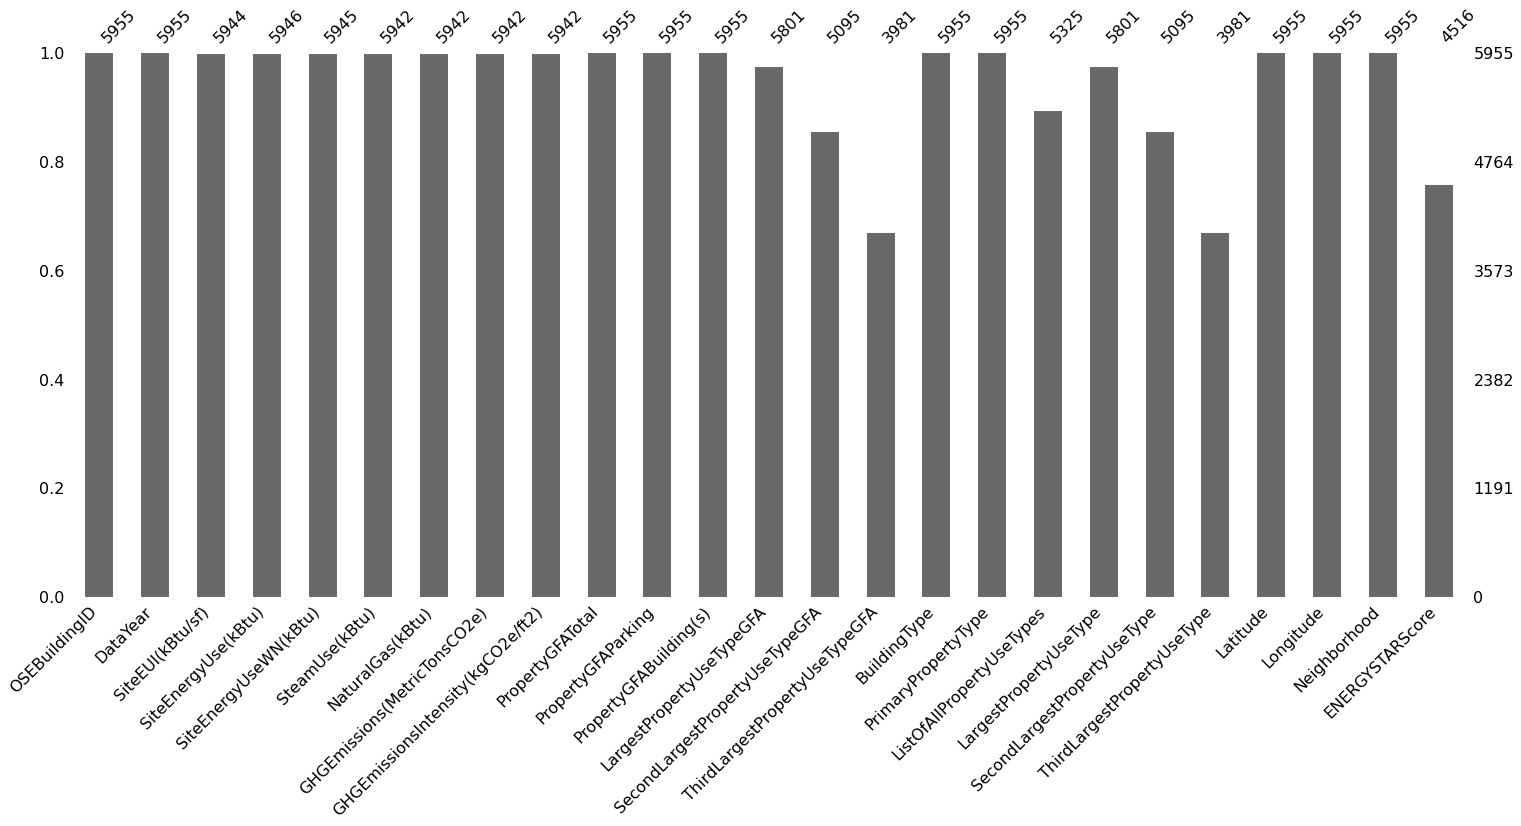

In [121]:
plt.figure('Densite de remplissage param_retenus apres corrections NaN et 0 chez 2nd 3rd LargestPropertyUseType', figsize=(25,6)), plt.clf()
bar(df_fusion[tab_param_retenus])

### Et on refait le même calcul qu'il y a quelques lignes afin d'estimer l'impact de la supression des lignes contenant des NaN (désormais moins nombreuses) sur les distributions des étiquettes :

In [122]:
# Copie
df_b2d_ssnan = df_fusion[tab_param_retenus].copy(deep=True)
# Réduction
df_b2d_ssnan.dropna(axis=0, how='any', inplace=True)
# Création d'une variable df (qui sera effacée à la fin de cette cellule) afin de se faciliter le travail à venir
df, df_ssnan = df_fusion[noms_etiquettes].copy(deep=True), df_b2d_ssnan[noms_etiquettes].copy(deep=True)
### On calcule (et affiche) les écarts relatifs de certaines propriétés statistiques lors de la suppression des NaN pour chaque étiquette
for colonne in df.columns:
    moy, std, mediane = df[colonne].mean(), df[colonne].std(), df[colonne].median()
    moy_ssnan, std_ssnan, mediane_ssnan = df_ssnan[colonne].mean(), df_ssnan[colonne].std(), df_ssnan[colonne].median()
    try :
        print(f'Pour l`étiquette {colonne : >35} : Delta(moyenne) = {100*(moy-moy_ssnan)/moy : >8.2f} ; Delta(écart-type) = {100*(std-std_ssnan)/std : >8.2f} ; Delta(médiane) = {100*(mediane-mediane_ssnan)/mediane : >8.2f}.')
    except(ZeroDivisionError):
        print(f'Pour l`étiquette {colonne : >35} : Delta(moyenne) = {100*(moy-moy_ssnan)/moy : >8.2f} ; Delta(écart-type) = {100*(std-std_ssnan)/std : >8.2f} ; Médiane = 0')
### Effacement des variables désormais inutiles
del moy, std, mediane, moy_ssnan, std_ssnan, mediane_ssnan, colonne, df, df_ssnan

Pour l`étiquette                    SiteEUI(kBtu/sf) : Delta(moyenne) =    14.34 ; Delta(écart-type) =    23.07 ; Delta(médiane) =     6.35.
Pour l`étiquette                 SiteEnergyUse(kBtu) : Delta(moyenne) =    11.44 ; Delta(écart-type) =    35.28 ; Delta(médiane) =     9.63.
Pour l`étiquette               SiteEnergyUseWN(kBtu) : Delta(moyenne) =     8.39 ; Delta(écart-type) =    13.53 ; Delta(médiane) =     9.45.
Pour l`étiquette                      SteamUse(kBtu) : Delta(moyenne) =    35.68 ; Delta(écart-type) =    56.70 ; Médiane = 0
Pour l`étiquette                    NaturalGas(kBtu) : Delta(moyenne) =     8.04 ; Delta(écart-type) =    -8.59 ; Delta(médiane) =    -1.98.
Pour l`étiquette        GHGEmissions(MetricTonsCO2e) : Delta(moyenne) =    12.89 ; Delta(écart-type) =    22.20 ; Delta(médiane) =     8.94.
Pour l`étiquette   GHGEmissionsIntensity(kgCO2e/ft2) : Delta(moyenne) =    12.91 ; Delta(écart-type) =    27.41 ; Delta(médiane) =     2.97.


### C'est nettement mieux, mais il demeure des écarts-relatifs trop important pour accepter de délaisser les lignes contenant des NaN.

<Figure size 1800x432 with 0 Axes>

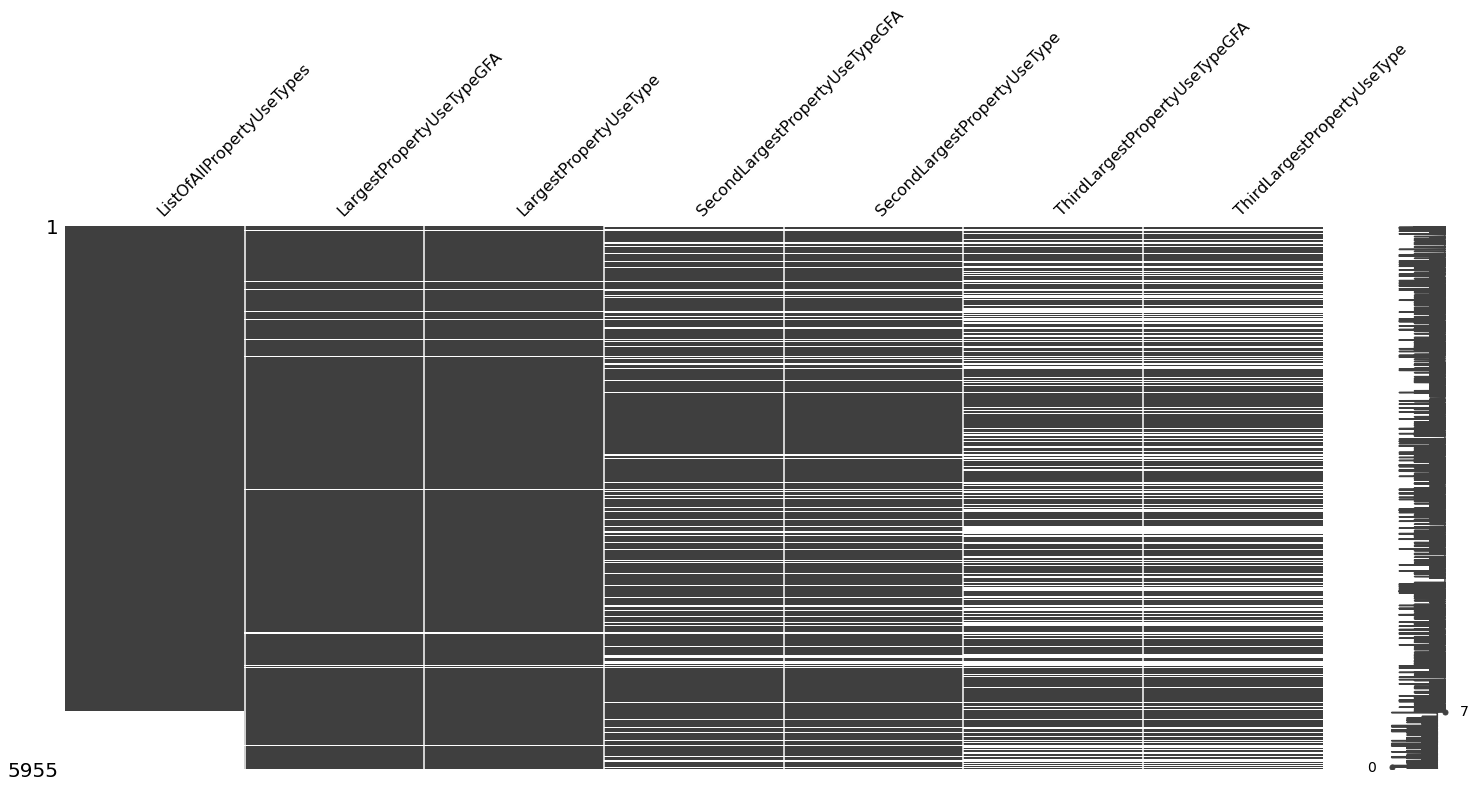

In [123]:
plt.figure('Matrice remplissage param UseType et UseTypeGFA apres corrections NaN et 0 chez 2nd 3rd LargestPropertyUseType', figsize=(25,6)), plt.clf()
matrix(df_fusion[['ListOfAllPropertyUseTypes','LargestPropertyUseTypeGFA','LargestPropertyUseType','SecondLargestPropertyUseTypeGFA','SecondLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType']])

### On va donc tenter une imputation sous contrôle suplémentaire.
### Notre attention se porte sur <i>LargestPropertyUseType</i> et <i>ListOfAllPropertyUseType</i>. On va contrôler grâce à LargestPropertyUseType, 2ndLargestPropertyUseType et 3rdLargestPropertyUseType qu'on puisse remplacer les NaN de ListOfAllPropertyUseType par des listes de 3 type d'usage.

In [124]:
df_loaut,df_1sttype = df_fusion['ListOfAllPropertyUseTypes'].copy(deep=True), df_fusion['LargestPropertyUseType'].copy(deep=True)
indices_loaut_nan = df_loaut.isna()[np.where(df_loaut.isna()==True, True, False)].index

In [125]:
df_1sttype.loc[indices_loaut_nan].isna().value_counts(), df_2ndtype.loc[indices_loaut_nan].isna().value_counts(), df_3rdtype.loc[indices_loaut_nan].isna().value_counts()

(False    615
 True      15
 Name: LargestPropertyUseType, dtype: int64,
 False    338
 True     292
 Name: SecondLargestPropertyUseType, dtype: int64,
 True     491
 False    139
 Name: ThirdLargestPropertyUseType, dtype: int64)

In [126]:
indices_1st_nan_loaut_nan = df_1sttype.loc[indices_loaut_nan].isna()[np.where(df_1sttype.loc[indices_loaut_nan].isna()==True, True, False)].index
indices_2nd_nan_loaut_nan = df_2ndtype.loc[indices_loaut_nan].isna()[np.where(df_2ndtype.loc[indices_loaut_nan].isna()==True, True, False)].index
indices_3rd_nan_loaut_nan = df_3rdtype.loc[indices_loaut_nan].isna()[np.where(df_3rdtype.loc[indices_loaut_nan].isna()==True, True, False)].index

In [127]:
np.intersect1d(indices_1st_nan_loaut_nan, indices_2nd_nan_loaut_nan) == indices_1st_nan_loaut_nan.values, np.intersect1d(indices_1st_nan_loaut_nan, indices_3rd_nan_loaut_nan) == indices_1st_nan_loaut_nan.values

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True]))

### Parfais, une NaN dans LargestPropertyUseType signifie bien -comme on pouvait le deviner- une NaN dans les 2 autres

In [128]:
np.intersect1d(indices_2nd_nan_loaut_nan, indices_3rd_nan_loaut_nan) == indices_2nd_nan_loaut_nan.values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

### Et une Nan dans 2ndLargestPropertyUseType implique bien une Nan dans 3rdLargestPropertyUseType. Tout est logique et cohérent.
### On va pouvoir remplacer les NaN de ListOfAllPropertyUseType par des listes contenant les 3 types d'usage correspondant (avec des NaN correspondant aux NaN dans l'un des 3 paramètres 1st/2nd/3rdLargestUseType).

In [129]:
Liste = []
for indx in indices_loaut_nan :
    # cas de figure à 3 nan (equivalent à une NaN dans le 1stLargestUseType) -> Nan
    if indx in indices_1st_nan_loaut_nan : #np.logical_and(np.isnan(df_2ndtype.loc[indx]), np.logical_and(np.isnan(df_2ndtype.loc[indx]), np.isnan(df_2ndtype.loc[indx]))) :
        Liste.append(np.nan)
    else :
        liste = [df_1sttype.loc[indx]]
        # cas de figure à une Nan dans 2ndLargestUseType (qui implique qu'il y en ait une également dans le 3rdLargestUseType) --> on range liste dans Liste
        if indx in indices_2nd_nan_loaut_nan :
            Liste.append(liste)
        else :
            liste.append(df_2ndtype.loc[indx])
            # cas de figure à une Nan dans le 3rdLargestUseType --> on range liste dans Liste
            if indx in indices_3rd_nan_loaut_nan :
                Liste.append(liste)
            else :
                liste.append(df_3rdtype.loc[indx])
                Liste.append(liste)
### On attribue ces valeurs aux éléments correspondant dans la colonne ListOfAllPropertyUseType
df_fusion.loc[indices_loaut_nan, 'ListOfAllPropertyUseTypes'] = Liste

In [130]:
df_fusion.loc[indices_loaut_nan, 'ListOfAllPropertyUseTypes']

5955                                [Multifamily Housing]
5956                                [Multifamily Housing]
5957                                [Multifamily Housing]
5958                     [Senior Care Community, Parking]
5959                     [Senior Care Community, Parking]
                              ...                        
6711                                             [Office]
6712                                 [Other - Recreation]
6713    [Other - Recreation, Fitness Center/Health Clu...
6714    [Other - Recreation, Fitness Center/Health Clu...
6715    [Other - Recreation, Fitness Center/Health Clu...
Name: ListOfAllPropertyUseTypes, Length: 630, dtype: object

### On regarde de nouveaux la matrice de remplissage, maintenant que quelques centaines de NaN ont encore été supprimées :

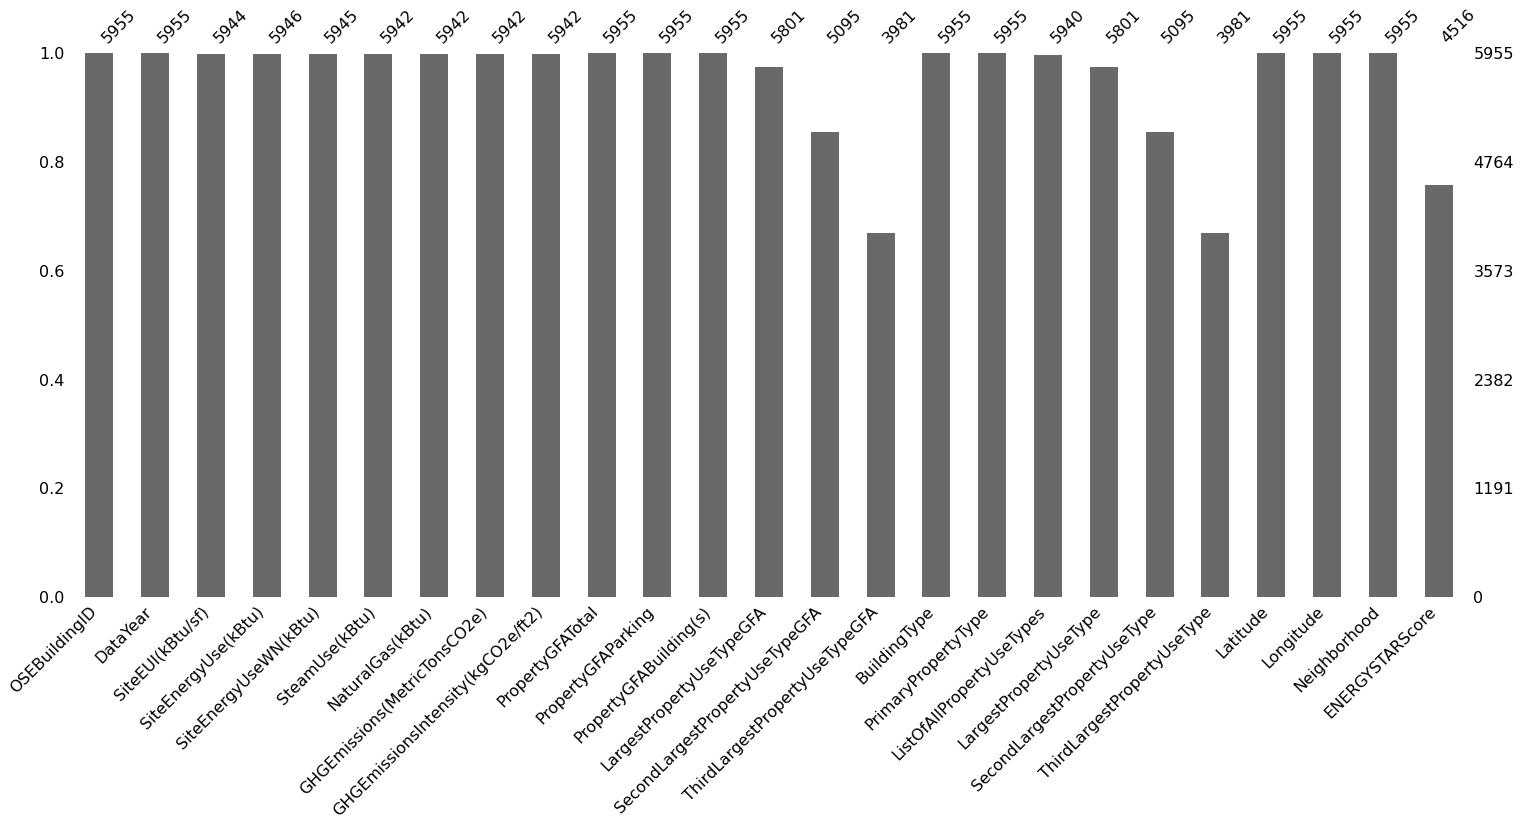

In [131]:
plt.figure('Densite de remplissage param_retenus apres corrections NaN chez ListOfAllPropertyUseType', figsize=(25,6)), plt.clf()
bar(df_fusion[tab_param_retenus])
if Sauvegarde_figure :
    plt.savefig(abs_path_fig+f'23_Densité_remplissage_param_retenus_Nan_to_0_15et16'+'.png')

# 
# <u>6)Sauvegarde de la base de données réduite et nettoyée.</u>

In [133]:
tab_param_retenus

['OSEBuildingID',
 'DataYear',
 'SiteEUI(kBtu/sf)',
 'SiteEnergyUse(kBtu)',
 'SiteEnergyUseWN(kBtu)',
 'SteamUse(kBtu)',
 'NaturalGas(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'PropertyGFABuilding(s)',
 'LargestPropertyUseTypeGFA',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'BuildingType',
 'PrimaryPropertyType',
 'ListOfAllPropertyUseTypes',
 'LargestPropertyUseType',
 'SecondLargestPropertyUseType',
 'ThirdLargestPropertyUseType',
 'Latitude',
 'Longitude',
 'Neighborhood',
 'ENERGYSTARScore']

In [134]:
# Création d'un Dataframe spécifiquement dédié à la b2d réduite et nettoyée
df_b2d_rednet = df_fusion[tab_param_retenus].copy(deep=True)
# Sauvegarde du fichier 
df_b2d_rednet.to_csv(abs_path_b2d_rednet + title_b2d_rednet)